In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import xgboost as xgb
import sklearn.metrics as mtr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pytz

In [ ]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"TotalGiros": "mean", "DuraçãoViagem": "mean"}).reset_index(drop=True)
# df_mean = df_mean.groupby(["Linha", "data"], as_index=False).agg({"TotalGiros": "mean", "DuraçãoViagem": "mean"}).reset_index(drop=True)
df_mean.rename({"TotalGiros": "TotalGirosMean", "DuraçãoViagem": "DuraçãoViagemMean"}, axis=1, inplace=True)
df_mean

In [ ]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
# df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1"], right_on=["Linha", "data"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

# Exploração e Tratamento dos dados

In [4]:
df = pd.read_csv('dados_floripa.csv')
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\2996573664.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados_floripa.csv')


DataIni   HoraIni     DataFim   HoraFim Sentido Linha NoVeículo  \
0        2019-04-14  02:29:00  2019-04-14  02:30:00     Ida   100       271   
1        2019-04-14  03:30:00  2019-04-14  03:30:00     Ida   100       271   
2        2019-04-13  01:28:00  2019-04-13  01:28:00     Ida   100       276   
3        2019-04-12  03:28:00  2019-04-12  03:28:00     Ida   100       279   
4        2019-04-07  00:31:00  2019-04-07  00:31:00     Ida   100       273   
...             ...       ...         ...       ...     ...   ...       ...   
2694355  2019-10-01  04:00:00  2019-10-01  04:34:00   Volta   477     50404   
2694356  2019-10-01  04:29:00  2019-10-01  05:12:00   Volta   477     50359   
2694357  2019-10-01  05:15:00  2019-10-01  05:47:00   Volta   477     50404   
2694358  2019-10-01  05:47:00  2019-10-01  05:47:00   Volta   477     50404   
2694359  2019-10-01  09:56:00  2019-10-01  10:32:00   Volta   477     50404   

        DuraçãoViagem  TotalGiros  KmPerc  
0            00:01:00           0   0.000  
1            00:00:00           0   0.000  
2            00:00:00           0   0.000  
3            00:00:00           0   0.000  
4            00:00:00           0   0.000  
...               ...         ...     ...  
2694355      00:34:00           5  17.294  
2694356      00:43:00           7  17.294  
2694357      00:32:00           7  17.294  
2694358      00:00:00           0  17.294  
2694359      00:36:00          11  17.294  

[2694360 rows x 10 columns]

In [5]:
# Checar o tipos dos dados
df.dtypes

DataIni           object
HoraIni           object
DataFim           object
HoraFim           object
Sentido           object
Linha             object
NoVeículo         object
DuraçãoViagem     object
TotalGiros         int64
KmPerc           float64
dtype: object

In [6]:
# Checkup geral das colunas
# Podemos ver num primeiro momento que:
# Sentido está de certa forma balanceado no geral, verificar se para todas as rotas também está próximo
# Existem 229 linhas que podem ser trabalhadas (objeto do estudo)
# Existem 1295 veículos, pode existir alguma relação do veículo com a eficiência/velocidade da rota, porém como não sabemos quem dirige o ônibus ou informações do mesmo como estado de manutenção e etc, provavelmente será um dado descartado
# Algumas rotas estão com KmPerc zerados, podem ser falhas de medição e serão descartados
# Algumas rotas estão com o tempo de viagem zerados, podem ser falhas de medição e serão descartados
# TotalGiros são o número de pessoas que passaram pela roleta podem influenciar na DuraçãoViagem das rotas, algumas estão zeradas podendo ser falha de medição
for colum in df:
    print(f'{df[colum].describe()}\n--------------------------')

count        2694360
unique           366
top       2019-10-25
freq            9276
Name: DataIni, dtype: object
--------------------------
count      2694360
unique        1440
top       07:00:00
freq          4366
Name: HoraIni, dtype: object
--------------------------
count        2694360
unique           366
top       2019-10-25
freq            9275
Name: DataFim, dtype: object
--------------------------
count      2694360
unique        1440
top       07:15:00
freq          3969
Name: HoraFim, dtype: object
--------------------------
count     2694360
unique          2
top         Volta
freq      1394073
Name: Sentido, dtype: object
--------------------------
count     2694360
unique        230
top           410
freq        68613
Name: Linha, dtype: object
--------------------------
count     2694360
unique       1301
top         11637
freq         8487
Name: NoVeículo, dtype: int64
--------------------------
count      2694360
unique         454
top       00:21:00
freq         819

In [7]:
# Id do veículos consideramos que é um informação desnecessária, visto que não temos dados dos veículos em si como modelo, motor e etc. Assim acreditamos ser um dados desnecessário para a predição
df.drop(columns='NoVeículo',inplace=True)

In [8]:
# Unindo data e hora e removendo as antigas (Visto que as datas e horas atuais estão em colunas separadas e são objetos, queremos elas como datetimes)
df['Ini'] = pd.to_datetime(df['DataIni'] + ' ' + df['HoraIni'])
df['Fim'] = pd.to_datetime(df['DataFim'] + ' ' + df['HoraFim'])
df.drop(columns=['DataIni','HoraIni','DataFim','HoraFim'],inplace=True)

In [9]:
# Transformando a DuraçãoViagem em segundos, visto que é um objeto também
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_seconds = (hours * 3600) + (minutes * 60) + seconds
    return total_seconds
df['DuraçãoViagem'] = df['DuraçãoViagem'].apply(time_to_seconds)
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0           Ida   100             60           0   0.000 2019-04-14 02:29:00   
1           Ida   100              0           0   0.000 2019-04-14 03:30:00   
2           Ida   100              0           0   0.000 2019-04-13 01:28:00   
3           Ida   100              0           0   0.000 2019-04-12 03:28:00   
4           Ida   100              0           0   0.000 2019-04-07 00:31:00   
...         ...   ...            ...         ...     ...                 ...   
2694355   Volta   477           2040           5  17.294 2019-10-01 04:00:00   
2694356   Volta   477           2580           7  17.294 2019-10-01 04:29:00   
2694357   Volta   477           1920           7  17.294 2019-10-01 05:15:00   
2694358   Volta   477              0           0  17.294 2019-10-01 05:47:00   
2694359   Volta   477           2160          11  17.294 2019-10-01 09:56:00   

                        Fim  
0       2019-04-14 02:30:00  
1       2019-04-14 03:30:00  
2       2019-04-13 01:28:00  
3       2019-04-12 03:28:00  
4       2019-04-07 00:31:00  
...                     ...  
2694355 2019-10-01 04:34:00  
2694356 2019-10-01 05:12:00  
2694357 2019-10-01 05:47:00  
2694358 2019-10-01 05:47:00  
2694359 2019-10-01 10:32:00  

[2694360 rows x 7 columns]

In [10]:
# Removendo linhas com Duração e Distância percorridas iguais a 0
df = df.loc[(df['DuraçãoViagem'] != 0) & (df['KmPerc'] != 0)]

In [11]:
# Criando uma coluna de Velocidade para identificar outliers
df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
# Removendo valores muito baixos e altos de velocidade
df = df.loc[(df['Km/H'] > 3) & (df['Km/H'] < 80)]
df.drop(columns='Km/H', inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\629631639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\629631639.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='Km/H', inplace=True)


Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
6         Volta   100           3780           3  16.308 2019-05-01 00:31:00   
7         Volta   100           3660          10  16.308 2019-05-01 01:35:00   
8         Volta   100           1800           8  16.308 2019-05-01 02:36:00   
9         Volta   100           3600           7  16.308 2019-05-01 03:30:00   
10        Volta   100           1680           7  16.308 2019-05-01 04:30:00   
...         ...   ...            ...         ...     ...                 ...   
2694352   Volta   477           1500           1  17.294 2019-10-01 03:30:00   
2694355   Volta   477           2040           5  17.294 2019-10-01 04:00:00   
2694356   Volta   477           2580           7  17.294 2019-10-01 04:29:00   
2694357   Volta   477           1920           7  17.294 2019-10-01 05:15:00   
2694359   Volta   477           2160          11  17.294 2019-10-01 09:56:00   

                        Fim  
6       2019-05-01 01:34:00  
7       2019-05-01 02:36:00  
8       2019-05-01 03:06:00  
9       2019-05-01 04:30:00  
10      2019-05-01 04:58:00  
...                     ...  
2694352 2019-10-01 03:55:00  
2694355 2019-10-01 04:34:00  
2694356 2019-10-01 05:12:00  
2694357 2019-10-01 05:47:00  
2694359 2019-10-01 10:32:00  

[2596654 rows x 7 columns]

In [12]:
# Criando novos atributos a partir da data
df['dia_semana'] = df['Ini'].dt.dayofweek + 1
df['hora_dia'] = df['Ini'].dt.hour
df['dia_ano'] = df['Ini'].dt.dayofyear
df['mes_ano'] = df['Ini'].dt.month
df['turno_dia'] = df['hora_dia'].apply(lambda x: 1 if x < 6 else 4 if x > 17 else 2 if (x > 5 & x < 12) else 3 if (x > 11 & x < 18) else None)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3472968728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dia_semana'] = df['Ini'].dt.dayofweek + 1
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3472968728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hora_dia'] = df['Ini'].dt.hour
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3472968728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [13]:
# Analisando e removendo Linhas que não tem observações nos 12 meses do ano
meses_linha = df.groupby('Linha')['mes_ano'].unique().reset_index(name='meses')
meses_linha['contagem'] = meses_linha['meses'].apply(lambda x: len(x))
linhas_com_12_meses = meses_linha.loc[meses_linha['contagem']==12]['Linha'].values
df = df.loc[df['Linha'].isin(linhas_com_12_meses)]
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
6         Volta   100           3780           3  16.308 2019-05-01 00:31:00   
7         Volta   100           3660          10  16.308 2019-05-01 01:35:00   
8         Volta   100           1800           8  16.308 2019-05-01 02:36:00   
9         Volta   100           3600           7  16.308 2019-05-01 03:30:00   
10        Volta   100           1680           7  16.308 2019-05-01 04:30:00   
...         ...   ...            ...         ...     ...                 ...   
2694235   Volta  M940            780           0   8.622 2019-09-01 17:47:00   
2694236   Volta  M940            660           0   8.622 2019-09-01 18:32:00   
2694237   Volta  M940            660           2   8.622 2019-09-01 21:20:00   
2694238   Volta  M940            660           0   8.622 2019-09-01 22:15:00   
2694239   Volta  M940            660           0   8.622 2019-09-01 23:28:00   

                        Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
6       2019-05-01 01:34:00           3         0      121        5          1  
7       2019-05-01 02:36:00           3         1      121        5          1  
8       2019-05-01 03:06:00           3         2      121        5          1  
9       2019-05-01 04:30:00           3         3      121        5          1  
10      2019-05-01 04:58:00           3         4      121        5          1  
...                     ...         ...       ...      ...      ...        ...  
2694235 2019-09-01 18:00:00           7        17      244        9          2  
2694236 2019-09-01 18:43:00           7        18      244        9          4  
2694237 2019-09-01 21:31:00           7        21      244        9          4  
2694238 2019-09-01 22:26:00           7        22      244        9          4  
2694239 2019-09-01 23:39:00           7        23      244        9          4  

[2561977 rows x 12 columns]

In [14]:
# Analisando se alguma rota tem uma discrepancia muito grande entre as observações em cada Mês. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha = df.groupby(['Linha','mes_ano'])['dia_ano'].unique().reset_index(name='dias')
dias_mes_linha['contagem'] = dias_mes_linha['dias'].apply(lambda x: len(x))
dias_mes_linha_std = dias_mes_linha.groupby('Linha')['contagem'].agg(media='mean',desvio='std').reset_index()

In [15]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha_std.sort_values(by='desvio')

Linha      media    desvio
0     100  30.416667  0.900337
34    164  30.416667  0.900337
35    165  30.416667  0.900337
37    168  30.416667  0.900337
77    270  30.416667  0.900337
..    ...        ...       ...
8    1120  26.166667  2.124889
10   1122  26.333333  2.188122
9    1121  26.333333  2.188122
134  601V  20.000000  3.567530
90    296  18.833333  6.307763

[188 rows x 3 columns]

In [16]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha.loc[dias_mes_linha['Linha']=='601V']

Linha  mes_ano                                               dias  \
1608  601V        1  [31, 30, 29, 28, 25, 24, 23, 22, 21, 18, 17, 1...   
1609  601V        2  [59, 58, 57, 56, 53, 52, 51, 50, 49, 46, 45, 4...   
1610  601V        3           [88, 87, 86, 85, 84, 67, 66, 65, 63, 60]   
1611  601V        4  [120, 119, 116, 115, 114, 113, 112, 108, 107, ...   
1612  601V        5  [151, 150, 149, 148, 147, 144, 143, 142, 141, ...   
1613  601V        6  [179, 178, 177, 176, 175, 172, 170, 169, 168, ...   
1614  601V        7  [212, 211, 210, 207, 206, 205, 204, 203, 200, ...   
1615  601V        8  [242, 241, 240, 239, 238, 235, 234, 233, 232, ...   
1616  601V        9  [273, 270, 269, 268, 267, 266, 263, 262, 261, ...   
1617  601V       10  [304, 303, 302, 301, 298, 297, 296, 295, 294, ...   
1618  601V       11  [334, 333, 332, 331, 330, 327, 326, 325, 324, ...   
1619  601V       12  [362, 361, 360, 355, 354, 353, 352, 351, 348, ...   

      contagem  
1608        22  
1609        20  
1610        10  
1611        21  
1612        22  
1613        18  
1614        23  
1615        22  
1616        21  
1617        23  
1618        20  
1619        18

In [17]:
# Removendo as linhas com maior desvio padrão entre os meses
df = df.loc[~df['Linha'].isin(['601V','296','500V'])]
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
6         Volta   100           3780           3  16.308 2019-05-01 00:31:00   
7         Volta   100           3660          10  16.308 2019-05-01 01:35:00   
8         Volta   100           1800           8  16.308 2019-05-01 02:36:00   
9         Volta   100           3600           7  16.308 2019-05-01 03:30:00   
10        Volta   100           1680           7  16.308 2019-05-01 04:30:00   
...         ...   ...            ...         ...     ...                 ...   
2694235   Volta  M940            780           0   8.622 2019-09-01 17:47:00   
2694236   Volta  M940            660           0   8.622 2019-09-01 18:32:00   
2694237   Volta  M940            660           2   8.622 2019-09-01 21:20:00   
2694238   Volta  M940            660           0   8.622 2019-09-01 22:15:00   
2694239   Volta  M940            660           0   8.622 2019-09-01 23:28:00   

                        Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
6       2019-05-01 01:34:00           3         0      121        5          1  
7       2019-05-01 02:36:00           3         1      121        5          1  
8       2019-05-01 03:06:00           3         2      121        5          1  
9       2019-05-01 04:30:00           3         3      121        5          1  
10      2019-05-01 04:58:00           3         4      121        5          1  
...                     ...         ...       ...      ...      ...        ...  
2694235 2019-09-01 18:00:00           7        17      244        9          2  
2694236 2019-09-01 18:43:00           7        18      244        9          4  
2694237 2019-09-01 21:31:00           7        21      244        9          4  
2694238 2019-09-01 22:26:00           7        22      244        9          4  
2694239 2019-09-01 23:39:00           7        23      244        9          4  

[2560255 rows x 12 columns]

count      185.000000
mean     13839.216216
std      13599.364304
min        247.000000
25%       3990.000000
50%      10699.000000
75%      16809.000000
max      67327.000000
Name: Sentido, dtype: float64


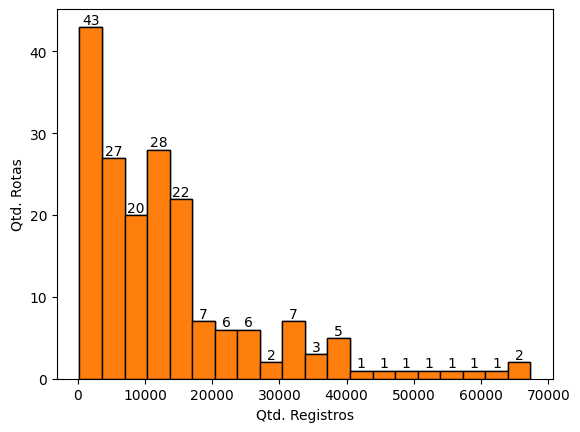

In [18]:
# Verificando a quantidade de rotas em cada Linha para removermos linhas com poucas observações ou muitas observações
qtd_rotas_p_linha = pd.DataFrame(df.groupby('Linha')['Sentido'].count())
print(qtd_rotas_p_linha['Sentido'].describe())
# Plotar o histograma
plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')  # 'data' são os dados, 'bins' é o número de intervalos
# Adicionar rótulos com o número de itens em cada bin
hist, bins, _ = plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], str(int(hist[i])),ha='center', va='bottom')
plt.xlabel('Qtd. Registros')  # Rótulo do eixo x
plt.ylabel('Qtd. Rotas')  # Rótulo do eixo y
# Exibir o histograma
plt.show()

In [19]:
# Removendo as linhas com quantidade de rotas fora do primeiro e terceiro quartil
rotas_entre_primeiro_terceiro_qaurtil = qtd_rotas_p_linha.loc[(qtd_rotas_p_linha['Sentido'] > 3900)&(qtd_rotas_p_linha['Sentido']<16900)].index.values
df = df.loc[df['Linha'].isin(rotas_entre_primeiro_terceiro_qaurtil)]
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
179       Volta   101           1320           2   5.418 2019-04-30 06:30:00   
180       Volta   101           1200          12   5.418 2019-04-30 07:10:00   
181       Volta   101           1200           4   5.418 2019-04-30 07:50:00   
182       Volta   101           2340          10   5.418 2019-04-30 08:25:00   
183       Volta   101           1440           3   5.418 2019-04-30 09:30:00   
...         ...   ...            ...         ...     ...                 ...   
2694235   Volta  M940            780           0   8.622 2019-09-01 17:47:00   
2694236   Volta  M940            660           0   8.622 2019-09-01 18:32:00   
2694237   Volta  M940            660           2   8.622 2019-09-01 21:20:00   
2694238   Volta  M940            660           0   8.622 2019-09-01 22:15:00   
2694239   Volta  M940            660           0   8.622 2019-09-01 23:28:00   

                        Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
179     2019-04-30 06:52:00           2         6      120        4          2  
180     2019-04-30 07:30:00           2         7      120        4          2  
181     2019-04-30 08:10:00           2         7      120        4          2  
182     2019-04-30 09:04:00           2         8      120        4          2  
183     2019-04-30 09:54:00           2         9      120        4          2  
...                     ...         ...       ...      ...      ...        ...  
2694235 2019-09-01 18:00:00           7        17      244        9          2  
2694236 2019-09-01 18:43:00           7        18      244        9          4  
2694237 2019-09-01 21:31:00           7        21      244        9          4  
2694238 2019-09-01 22:26:00           7        22      244        9          4  
2694239 2019-09-01 23:39:00           7        23      244        9          4  

[973610 rows x 12 columns]

In [20]:
# Analisando se a quantidade de idas e voltas de cada linha está Ok. Concluimos que está ok e não removemos nenhum linha
ida_voltas_linhas = df.groupby('Linha')['Sentido'].value_counts().unstack(fill_value=0)
ida_voltas_linhas['Diferenca'] = ida_voltas_linhas['Ida'] - ida_voltas_linhas['Volta']
ida_voltas_linhas.sort_values(by='Diferenca')

Sentido   Ida  Volta  Diferenca
Linha                          
138         0  16346     -16346
136         0  16296     -16296
137         0  15949     -15949
135         0  15936     -15936
772         0  10950     -10950
...       ...    ...        ...
274      2790   2202        588
281      8657   7953        704
330V     6235   5511        724
1129     6954   6226        728
605      3916      0       3916

[95 rows x 3 columns]

In [21]:
# Fazendo um encoding da coluna Sentido, pois o modelo XGB não aceita informações categoricas.
df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\2206277558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})


In [22]:
# Analisando número de Giros por linhas. Tem valores estranhos e que não fazem sentido, porém de decidimos deixar para rodar nos modelos, retimos apenas a linha 110 que estava toda zerada
df.groupby(['Linha'])['TotalGiros'].mean().reset_index().sort_values(by='TotalGiros')

Linha  TotalGiros
2    110    0.003722
58   362    4.119939
40   180    4.325447
38   178    5.977037
91   943    6.096262
..   ...         ...
17   136   44.577320
54   294   46.153422
19   138   48.245626
16   135   50.508471
86   840   56.329857

[95 rows x 2 columns]

In [23]:
# Olhando na mão linha a linha
df.loc[df['Linha']=='110']#.groupby('turno_dia').size()

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
1164           0   110           1140           0   7.629 2019-04-30 08:34:00   
1165           0   110           1200           0   7.629 2019-04-30 12:25:00   
1166           0   110           1500           0   7.629 2019-04-30 13:02:00   
1167           0   110           1500           0   7.629 2019-04-30 13:40:00   
1168           0   110           1680           0   7.629 2019-04-30 14:23:00   
...          ...   ...            ...         ...     ...                 ...   
2475219        1   110            780           0   7.713 2019-09-02 18:10:00   
2475220        1   110           1800           0   7.713 2019-09-02 18:11:00   
2475221        1   110            720           0   7.713 2019-09-02 18:46:00   
2475222        1   110            840           0   7.713 2019-09-02 19:06:00   
2475223        1   110           1920           0   7.713 2019-09-02 19:12:00   

                        Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
1164    2019-04-30 08:53:00           2         8      120        4          2  
1165    2019-04-30 12:45:00           2        12      120        4          2  
1166    2019-04-30 13:27:00           2        13      120        4          2  
1167    2019-04-30 14:05:00           2        13      120        4          2  
1168    2019-04-30 14:51:00           2        14      120        4          2  
...                     ...         ...       ...      ...      ...        ...  
2475219 2019-09-02 18:23:00           1        18      245        9          4  
2475220 2019-09-02 18:41:00           1        18      245        9          4  
2475221 2019-09-02 18:58:00           1        18      245        9          4  
2475222 2019-09-02 19:20:00           1        19      245        9          4  
2475223 2019-09-02 19:44:00           1        19      245        9          4  

[15585 rows x 12 columns]

In [24]:
# Remoção da linha 110
df = df.loc[df['Linha'] != '110']
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
179            1   101           1320           2   5.418 2019-04-30 06:30:00   
180            1   101           1200          12   5.418 2019-04-30 07:10:00   
181            1   101           1200           4   5.418 2019-04-30 07:50:00   
182            1   101           2340          10   5.418 2019-04-30 08:25:00   
183            1   101           1440           3   5.418 2019-04-30 09:30:00   
...          ...   ...            ...         ...     ...                 ...   
2694235        1  M940            780           0   8.622 2019-09-01 17:47:00   
2694236        1  M940            660           0   8.622 2019-09-01 18:32:00   
2694237        1  M940            660           2   8.622 2019-09-01 21:20:00   
2694238        1  M940            660           0   8.622 2019-09-01 22:15:00   
2694239        1  M940            660           0   8.622 2019-09-01 23:28:00   

                        Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
179     2019-04-30 06:52:00           2         6      120        4          2  
180     2019-04-30 07:30:00           2         7      120        4          2  
181     2019-04-30 08:10:00           2         7      120        4          2  
182     2019-04-30 09:04:00           2         8      120        4          2  
183     2019-04-30 09:54:00           2         9      120        4          2  
...                     ...         ...       ...      ...      ...        ...  
2694235 2019-09-01 18:00:00           7        17      244        9          2  
2694236 2019-09-01 18:43:00           7        18      244        9          4  
2694237 2019-09-01 21:31:00           7        21      244        9          4  
2694238 2019-09-01 22:26:00           7        22      244        9          4  
2694239 2019-09-01 23:39:00           7        23      244        9          4  

[958025 rows x 12 columns]

   Linha  DuraçãoViagem
83   769     299.285125
25   162     307.003065
51   282     308.414705
57   362     320.880172
45   263     322.334440
..   ...            ...
15   135     969.436064
16   136    1033.633614
18   138    1056.295415
41  2120    1126.105276
85   840    1149.508023

[94 rows x 2 columns]


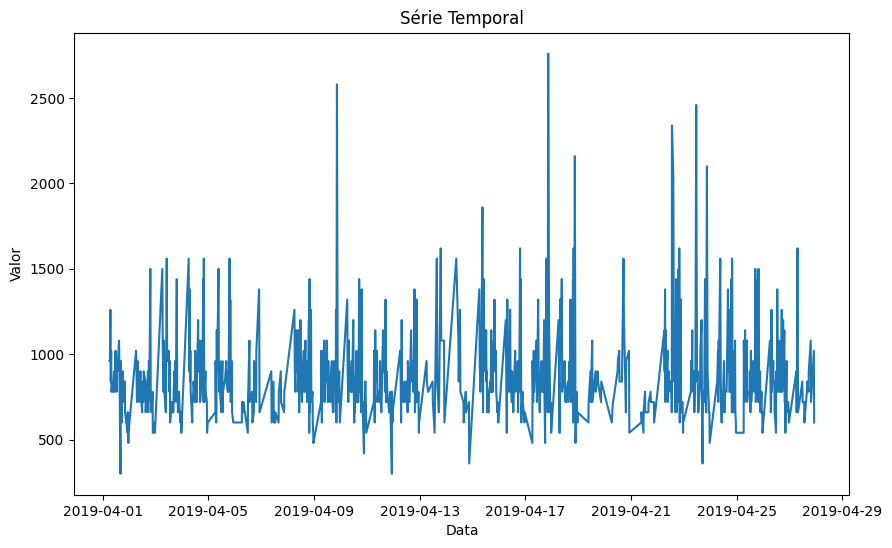

In [25]:
# Analisando o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico
print(df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem'))
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()

In [26]:
#Remoção dos outliers de cada Linha
# IQR Method (Interquartile Range):
def remove_outlier(valores):
    Q1 = np.percentile(valores,25)
    Q3 = np.percentile(valores,75)
    intervalo = Q3-Q1
    limite_superior = Q3+intervalo*1.5
    limite_inferior = Q1-intervalo*1.5
    return limite_superior,limite_inferior

linhas = df['Linha'].unique()
outliers_indexs = []
for linha in linhas:
    aux = df.loc[df['Linha'] == linha]['DuraçãoViagem']
    limite_superior,limite_inferior = remove_outlier(aux)
    aux = aux.loc[(aux.values > limite_superior) | (aux.values < limite_inferior)]
    outliers_indexs.extend(aux.index)
df.drop(outliers_indexs,inplace=True)
df.reset_index(drop=True,inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\2474428967.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outliers_indexs,inplace=True)


Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0             1   101           1320           2   5.418 2019-04-30 06:30:00   
1             1   101           1200          12   5.418 2019-04-30 07:10:00   
2             1   101           1200           4   5.418 2019-04-30 07:50:00   
3             1   101           2340          10   5.418 2019-04-30 08:25:00   
4             1   101           1440           3   5.418 2019-04-30 09:30:00   
...         ...   ...            ...         ...     ...                 ...   
928051        1  M940            780           0   8.622 2019-09-01 17:47:00   
928052        1  M940            660           0   8.622 2019-09-01 18:32:00   
928053        1  M940            660           2   8.622 2019-09-01 21:20:00   
928054        1  M940            660           0   8.622 2019-09-01 22:15:00   
928055        1  M940            660           0   8.622 2019-09-01 23:28:00   

                       Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
0      2019-04-30 06:52:00           2         6      120        4          2  
1      2019-04-30 07:30:00           2         7      120        4          2  
2      2019-04-30 08:10:00           2         7      120        4          2  
3      2019-04-30 09:04:00           2         8      120        4          2  
4      2019-04-30 09:54:00           2         9      120        4          2  
...                    ...         ...       ...      ...      ...        ...  
928051 2019-09-01 18:00:00           7        17      244        9          2  
928052 2019-09-01 18:43:00           7        18      244        9          4  
928053 2019-09-01 21:31:00           7        21      244        9          4  
928054 2019-09-01 22:26:00           7        22      244        9          4  
928055 2019-09-01 23:39:00           7        23      244        9          4  

[928056 rows x 12 columns]

   Linha  DuraçãoViagem
0    362     180.525409
1    271     200.506881
2    169     205.213838
3    162     211.636999
4    168     211.744094
..   ...            ...
89   136     782.542959
90   135     793.372851
91   138     823.866071
92   235     842.370148
93  4122     862.373308

[94 rows x 2 columns]


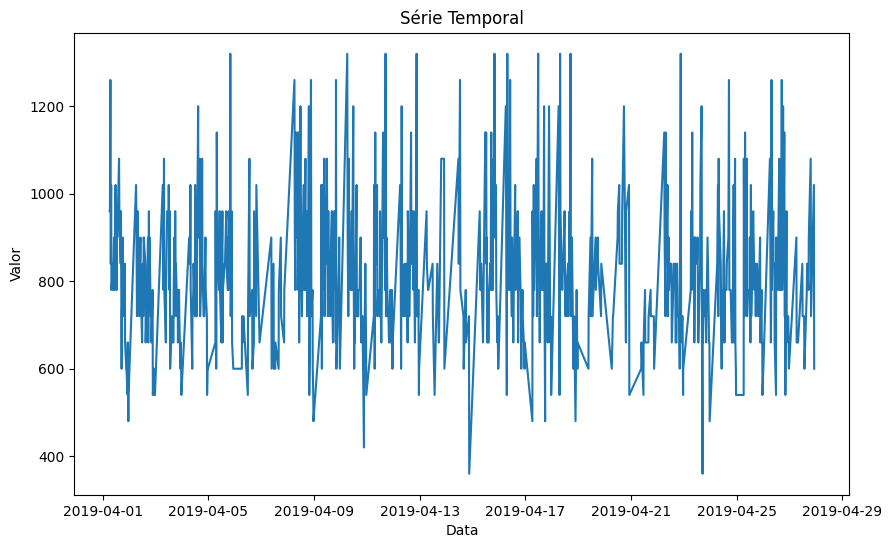

In [27]:
# Voltando a analisar o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico após a remoçao dos outliers
a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()

In [28]:
#Selecionando as rotas que serão usadas nos teste
a.iloc[[0,1,64,65,92,93]]

Linha  DuraçãoViagem
0    362     180.525409
1    271     200.506881
64   605     497.489081
65  1120     521.072152
92   235     842.370148
93  4122     862.373308

In [29]:
# Deixando o dataframe apenas com as rotas que serão utilizadas
df = df.loc[df['Linha'].isin(['362','271','605','1120','235','4122'])].reset_index(drop=True).sort_values(by=['Linha','Ini'],ascending=[True,True])
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
33734        0  1120           3600          22  31.218 2018-11-01 06:10:00   
33735        0  1120           4800          32  31.218 2018-11-01 06:43:00   
33951        1  1120           3300           2  30.640 2018-11-01 07:14:00   
33952        1  1120           3480           1  30.640 2018-11-01 08:08:00   
33736        0  1120           4800          30  31.218 2018-11-01 08:09:00   
...        ...   ...            ...         ...     ...                 ...   
40794        0   605           3360           7  19.437 2019-10-31 14:58:00   
40795        0   605           3780          18  19.437 2019-10-31 15:57:00   
40796        0   605           4440          26  19.437 2019-10-31 16:58:00   
40797        0   605           4380          24  19.437 2019-10-31 18:02:00   
40798        0   605           2580           2  19.437 2019-10-31 19:54:00   

                      Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
33734 2018-11-01 07:10:00           4         6      305       11          2  
33735 2018-11-01 08:03:00           4         6      305       11          2  
33951 2018-11-01 08:09:00           4         7      305       11          2  
33952 2018-11-01 09:06:00           4         8      305       11          2  
33736 2018-11-01 09:29:00           4         8      305       11          2  
...                   ...         ...       ...      ...      ...        ...  
40794 2019-10-31 15:54:00           4        14      304       10          2  
40795 2019-10-31 17:00:00           4        15      304       10          2  
40796 2019-10-31 18:12:00           4        16      304       10          2  
40797 2019-10-31 19:15:00           4        18      304       10          4  
40798 2019-10-31 20:37:00           4        19      304       10          4  

[44847 rows x 12 columns]

In [30]:
# Dados gerais das rotas usadas
df.groupby('Linha').agg({'KmPerc':'max', 'Sentido':'count'})

KmPerc  Sentido
Linha                 
1120   31.218     5609
235    24.110     6047
271    13.903    14393
362     4.240     9768
4122   25.244     5301
605    19.437     3729

In [31]:
print(df.shape)
len(df['Linha'].unique())

(44847, 12)


6

In [32]:
# Exportando o Dataframe
df.to_csv('dados_floripa_tratado.csv',index=False)

# Criação dos Modelos e Testes

## Teste Inicial

### Função que cria os 3 modelos e salva seus resultados

In [33]:
predictions = []
metrics = []
def cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome):

    #Treino do Modelo XGB e salvamento do tempo
    inicio_tempo_treino_xgb = datetime.now()
    modelo_xgb = xgb.XGBRegressor(
        # gamma = 0.0,
        # learning_rate = 0.01,
        # max_depth = 4,
        # min_child_weight = 8,
        # n_estimators = 500
    )
    modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

    fim_tempo_treino_xgb = datetime.now()
    tempo_treino_xgb = fim_tempo_treino_xgb - inicio_tempo_treino_xgb
    tempo_treino_xgb = float(f"{str(tempo_treino_xgb.seconds)}.{str(tempo_treino_xgb.microseconds)}")

    #Treino do Modelo RF e salvamento do tempo
    inicio_tempo_treino_rf = datetime.now()
    modelo_rf = RandomForestRegressor(
        # bootstrap = True,
        # max_depth = 11,
        # max_features = 'log2',
        # min_samples_leaf = 7,
        # min_samples_split = 6,
        # n_estimators = 500
    )
    modelo_rf.fit(x_treino, y_treino)

    fim_tempo_treino_rf = datetime.now()
    tempo_treino_rf = fim_tempo_treino_rf - inicio_tempo_treino_rf
    tempo_treino_rf = float(f"{str(tempo_treino_rf.seconds)}.{str(tempo_treino_rf.microseconds)}")

    #Treino do Modelo LR e salvamento do tempo
    inicio_tempo_treino_lr = datetime.now()
    modelo_lr = LinearRegression()
    modelo_lr.fit(x_treino, y_treino)

    fim_tempo_treino_lr = datetime.now()
    tempo_treino_lr = fim_tempo_treino_lr - inicio_tempo_treino_lr
    tempo_treino_lr = float(f"{str(tempo_treino_lr.seconds)}.{str(tempo_treino_lr.microseconds)}")

    #Nomeando a coluna que receberá as previsões
    TesteNomeXGB = f"XGB - {teste_nome}"
    TesteNomeRF = f"RF - {teste_nome}"
    TesteNomeLR = f"LR - {teste_nome}"

    #Predição do XGB e salvamento do tempo
    inicio_tempo_previsao_xgb = datetime.now()
    df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
    fim_tempo_previsao_xgb = datetime.now()
    tempo_previsao_xgb = fim_tempo_previsao_xgb - inicio_tempo_previsao_xgb
    tempo_previsao_xgb = float(f"{str(tempo_previsao_xgb.seconds)}.{str(tempo_previsao_xgb.microseconds)}")

    #Predição do RF e salvamento do tempo
    inicio_tempo_previsao_rf = datetime.now()
    df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
    fim_tempo_previsao_rf = datetime.now()
    tempo_previsao_rf = fim_tempo_previsao_rf - inicio_tempo_previsao_rf
    tempo_previsao_rf = float(f"{str(tempo_previsao_rf.seconds)}.{str(tempo_previsao_rf.microseconds)}")

    #Predição do LR e salvamento do tempo
    inicio_tempo_previsao_lr = datetime.now()
    df_teste[f'{TesteNomeLR}'] = modelo_lr.predict(x_teste)
    fim_tempo_previsao_lr = datetime.now()
    tempo_previsao_lr = fim_tempo_previsao_lr - inicio_tempo_previsao_lr
    tempo_previsao_lr = float(f"{str(tempo_previsao_lr.seconds)}.{str(tempo_previsao_lr.microseconds)}")

    #Métricas do XGB
    RRSE_xgb = np.sqrt(sum((df_teste["DuraçãoViagem"] - df_teste[f"{TesteNomeXGB}"]) ** 2) / sum((df_teste["DuraçãoViagem"] - np.mean(df_teste["DuraçãoViagem"])) ** 2))
    MAPE_xgb = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"])

    #Métricas do RF
    RRSE_rf = np.sqrt(sum((df_teste["DuraçãoViagem"] - df_teste[f"{TesteNomeRF}"]) ** 2) / sum((df_teste["DuraçãoViagem"] - np.mean(df_teste["DuraçãoViagem"])) ** 2))
    MAPE_rf = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"])

    #Métricas do LR
    RRSE_lr = np.sqrt(sum((df_teste["DuraçãoViagem"] - df_teste[f"{TesteNomeLR}"]) ** 2) / sum((df_teste["DuraçãoViagem"] - np.mean(df_teste["DuraçãoViagem"])) ** 2))
    MAPE_lr = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"])

    #Salvando as métricas num DataFrame Bonitinho
    metrics.append([f'{teste_nome}', rota,'XGBoost','RRSE',RRSE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'XGBoost','MAPE',MAPE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'Random Forest','RRSE',RRSE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Random Forest','MAPE',MAPE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','RRSE',RRSE_lr, tempo_treino_lr, tempo_previsao_lr])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','MAPE',MAPE_lr, tempo_treino_lr, tempo_previsao_lr])

    #Salvando as predições num DataFrame Bonitinho
    for i in range(df_teste.shape[0]):
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'XGBoost',df_teste[f"{TesteNomeXGB}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Random Forest',df_teste[f"{TesteNomeRF}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Linear Regression',df_teste[f"{TesteNomeLR}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Tempo real',df_teste["DuraçãoViagem"].iloc[i]])

    fi_xgb = pd.DataFrame(data=modelo_xgb.feature_importances_, index=modelo_xgb.feature_names_in_, columns=["importance"])
    fi_xgb.sort_values("importance").plot(kind="barh", title=f"Importância Dados XGB {rota}")
    #plt.savefig(f"Images/FI_XGB_{rota}_{teste_nome}.jpg")

    fi_rf = pd.DataFrame(data=modelo_rf.feature_importances_, index=x_treino.columns, columns=["importance"])
    fi_rf.sort_values("importance").plot(kind="barh", title=f"Importância Dados RF {rota}")
    #plt.savefig(f"Images/FI_RF_{rota}_{teste_nome}.jpg")

### Execuções por rotas

[0]	validation_0-rmse:2745.87974
[1]	validation_0-rmse:1943.53296
[2]	validation_0-rmse:1387.68833
[3]	validation_0-rmse:1006.32581
[4]	validation_0-rmse:749.10335
[5]	validation_0-rmse:579.66931
[6]	validation_0-rmse:471.83577
[7]	validation_0-rmse:405.94169
[8]	validation_0-rmse:365.43787
[9]	validation_0-rmse:340.96364
[10]	validation_0-rmse:328.39240
[11]	validation_0-rmse:319.71708
[12]	validation_0-rmse:313.83635
[13]	validation_0-rmse:310.34462
[14]	validation_0-rmse:306.70710
[15]	validation_0-rmse:302.01084
[16]	validation_0-rmse:298.16911
[17]	validation_0-rmse:294.36644
[18]	validation_0-rmse:292.67155
[19]	validation_0-rmse:290.05872
[20]	validation_0-rmse:286.71065
[21]	validation_0-rmse:285.51248
[22]	validation_0-rmse:281.77675
[23]	validation_0-rmse:280.64581
[24]	validation_0-rmse:277.51919
[25]	validation_0-rmse:276.03233
[26]	validation_0-rmse:273.09035
[27]	validation_0-rmse:269.98771
[28]	validation_0-rmse:267.70848
[29]	validation_0-rmse:266.01499
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1927.11408
[1]	validation_0-rmse:1375.36832
[2]	validation_0-rmse:996.46082
[3]	validation_0-rmse:739.34327
[4]	validation_0-rmse:568.17531
[5]	validation_0-rmse:457.78233
[6]	validation_0-rmse:386.72801
[7]	validation_0-rmse:345.35359
[8]	validation_0-rmse:320.83808
[9]	validation_0-rmse:305.68421
[10]	validation_0-rmse:293.04832
[11]	validation_0-rmse:286.51042
[12]	validation_0-rmse:280.44759
[13]	validation_0-rmse:274.88960
[14]	validation_0-rmse:272.02213
[15]	validation_0-rmse:267.92702
[16]	validation_0-rmse:266.39593
[17]	validation_0-rmse:264.12645
[18]	validation_0-rmse:262.89972
[19]	validation_0-rmse:258.01553
[20]	validation_0-rmse:252.22449
[21]	validation_0-rmse:249.23973
[22]	validation_0-rmse:248.07140
[23]	validation_0-rmse:246.24790
[24]	validation_0-rmse:242.27031
[25]	validation_0-rmse:238.95944
[26]	validation_0-rmse:238.02140
[27]	validation_0-rmse:235.72666
[28]	validation_0-rmse:233.59254
[29]	validation_0-rmse:231.73019
[30]	validation_0-

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.08266
[1]	validation_0-rmse:719.22435
[2]	validation_0-rmse:516.90274
[3]	validation_0-rmse:379.62333
[4]	validation_0-rmse:289.02635
[5]	validation_0-rmse:231.30885
[6]	validation_0-rmse:195.66208
[7]	validation_0-rmse:175.69191
[8]	validation_0-rmse:163.22036
[9]	validation_0-rmse:156.29512
[10]	validation_0-rmse:153.06444
[11]	validation_0-rmse:150.61432
[12]	validation_0-rmse:149.06689
[13]	validation_0-rmse:148.21234
[14]	validation_0-rmse:145.66986
[15]	validation_0-rmse:143.51304
[16]	validation_0-rmse:142.62120
[17]	validation_0-rmse:142.18939
[18]	validation_0-rmse:141.30512
[19]	validation_0-rmse:140.50743
[20]	validation_0-rmse:140.22681
[21]	validation_0-rmse:139.41017
[22]	validation_0-rmse:138.29394
[23]	validation_0-rmse:137.37022
[24]	validation_0-rmse:136.75849
[25]	validation_0-rmse:136.11486
[26]	validation_0-rmse:135.63785
[27]	validation_0-rmse:135.44947
[28]	validation_0-rmse:134.76133
[29]	validation_0-rmse:133.83752
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:601.38111
[1]	validation_0-rmse:435.42730
[2]	validation_0-rmse:323.37999
[3]	validation_0-rmse:249.57293
[4]	validation_0-rmse:203.04141
[5]	validation_0-rmse:175.53953
[6]	validation_0-rmse:159.30246
[7]	validation_0-rmse:150.02434
[8]	validation_0-rmse:144.06254
[9]	validation_0-rmse:140.73732
[10]	validation_0-rmse:138.79877
[11]	validation_0-rmse:136.94832
[12]	validation_0-rmse:135.74492
[13]	validation_0-rmse:135.23831
[14]	validation_0-rmse:134.21688
[15]	validation_0-rmse:133.85238
[16]	validation_0-rmse:133.28242
[17]	validation_0-rmse:132.25349
[18]	validation_0-rmse:131.97162
[19]	validation_0-rmse:131.05125
[20]	validation_0-rmse:130.69286
[21]	validation_0-rmse:130.37471
[22]	validation_0-rmse:129.98270
[23]	validation_0-rmse:129.45398
[24]	validation_0-rmse:128.43698
[25]	validation_0-rmse:128.07084
[26]	validation_0-rmse:127.26752
[27]	validation_0-rmse:126.83248
[28]	validation_0-rmse:126.07133
[29]	validation_0-rmse:125.41195
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2245.07952
[1]	validation_0-rmse:1608.08796
[2]	validation_0-rmse:1170.62354
[3]	validation_0-rmse:877.20704
[4]	validation_0-rmse:683.32980
[5]	validation_0-rmse:560.88281
[6]	validation_0-rmse:483.85816
[7]	validation_0-rmse:438.61740
[8]	validation_0-rmse:412.55460
[9]	validation_0-rmse:396.53711
[10]	validation_0-rmse:384.34483
[11]	validation_0-rmse:376.90725
[12]	validation_0-rmse:371.63830
[13]	validation_0-rmse:365.48042
[14]	validation_0-rmse:362.89756
[15]	validation_0-rmse:360.25896
[16]	validation_0-rmse:358.17593
[17]	validation_0-rmse:355.52269
[18]	validation_0-rmse:355.01230
[19]	validation_0-rmse:352.05102
[20]	validation_0-rmse:349.34086
[21]	validation_0-rmse:344.44638
[22]	validation_0-rmse:343.74656
[23]	validation_0-rmse:339.75001
[24]	validation_0-rmse:337.42050
[25]	validation_0-rmse:335.90747
[26]	validation_0-rmse:333.80990
[27]	validation_0-rmse:329.99765
[28]	validation_0-rmse:328.01426
[29]	validation_0-rmse:327.53065
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2330.94275
[1]	validation_0-rmse:1651.77786
[2]	validation_0-rmse:1182.30330
[3]	validation_0-rmse:860.35267
[4]	validation_0-rmse:643.20440
[5]	validation_0-rmse:499.97058
[6]	validation_0-rmse:409.82351
[7]	validation_0-rmse:353.77053
[8]	validation_0-rmse:318.74275
[9]	validation_0-rmse:297.19506
[10]	validation_0-rmse:285.73857
[11]	validation_0-rmse:277.50367
[12]	validation_0-rmse:272.72821
[13]	validation_0-rmse:267.50209
[14]	validation_0-rmse:264.42743
[15]	validation_0-rmse:262.70867
[16]	validation_0-rmse:258.48946
[17]	validation_0-rmse:257.55570
[18]	validation_0-rmse:253.76637
[19]	validation_0-rmse:250.27685
[20]	validation_0-rmse:247.45539
[21]	validation_0-rmse:245.94892
[22]	validation_0-rmse:242.76191
[23]	validation_0-rmse:240.14974
[24]	validation_0-rmse:239.54226
[25]	validation_0-rmse:238.70965
[26]	validation_0-rmse:236.93242
[27]	validation_0-rmse:235.02414
[28]	validation_0-rmse:231.55555
[29]	validation_0-rmse:229.77188
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

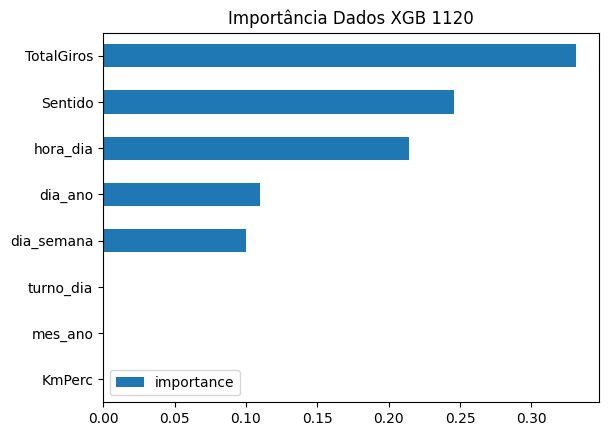

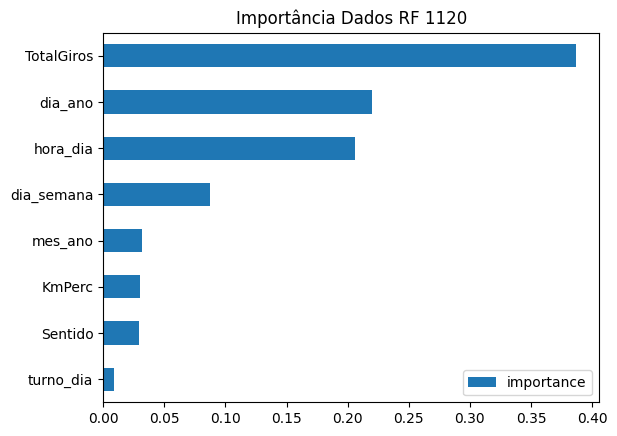

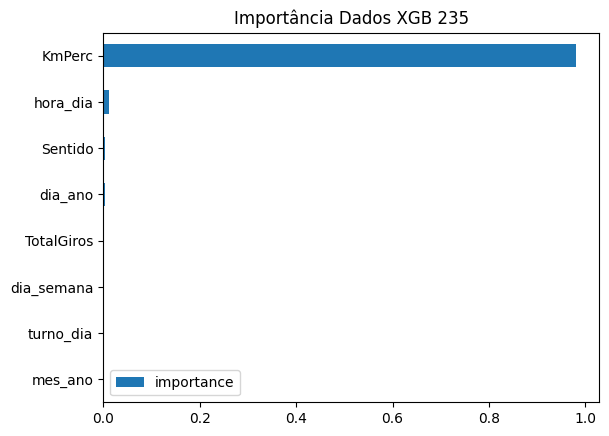

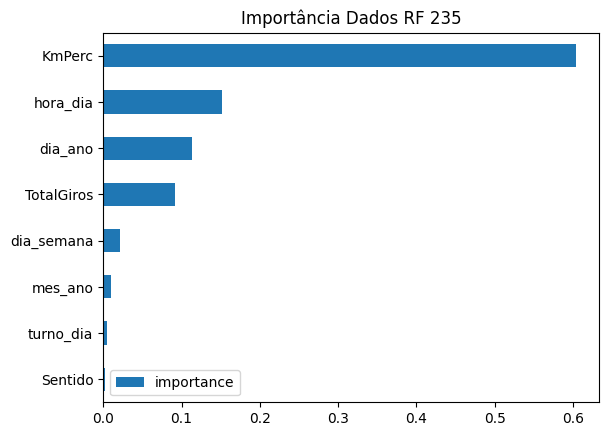

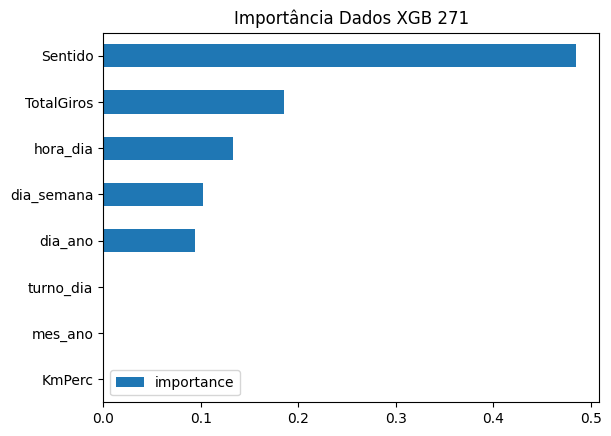

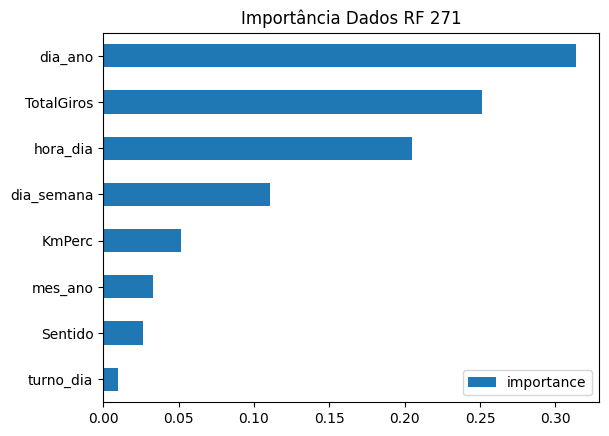

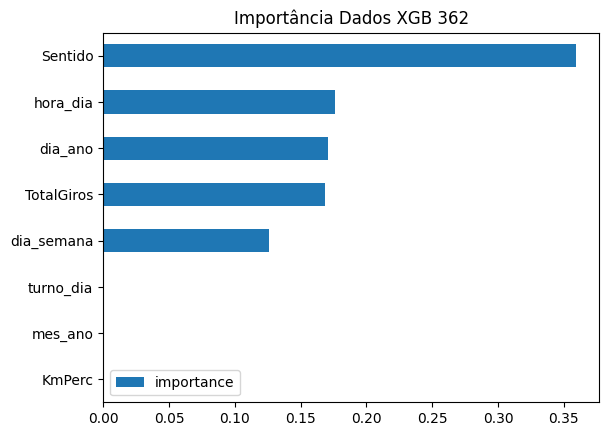

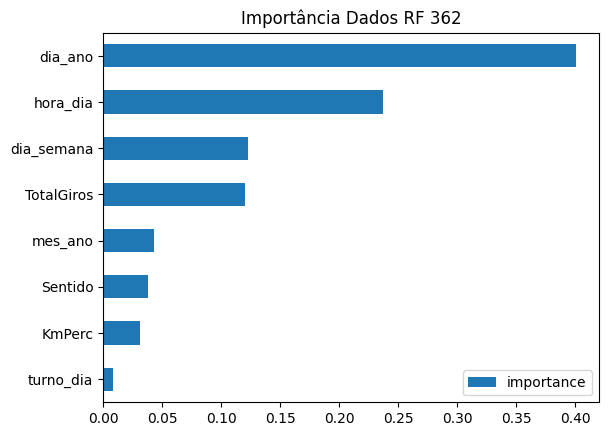

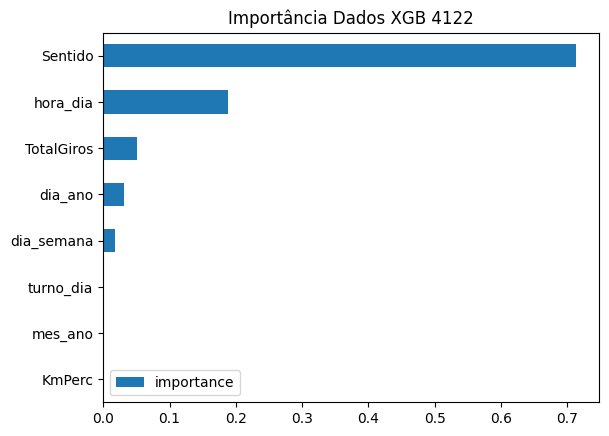

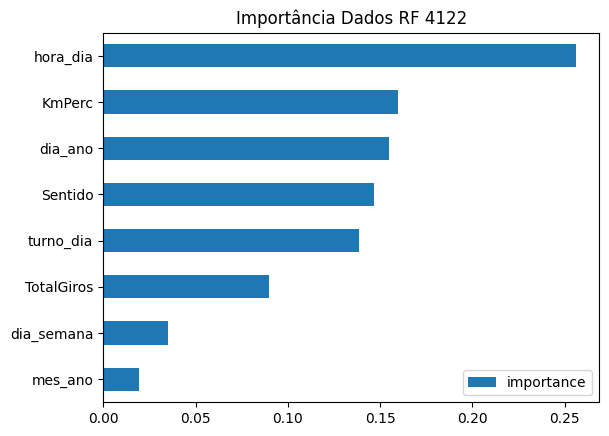

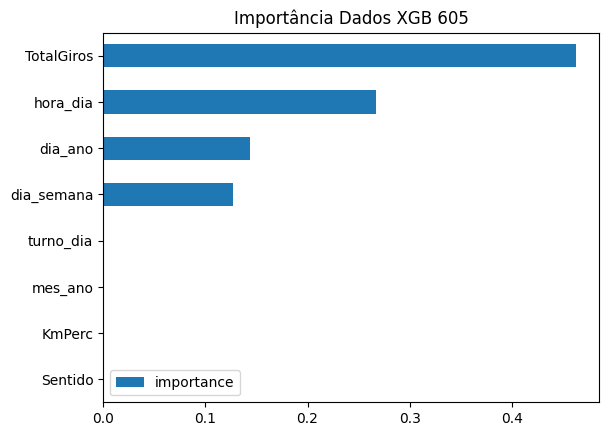

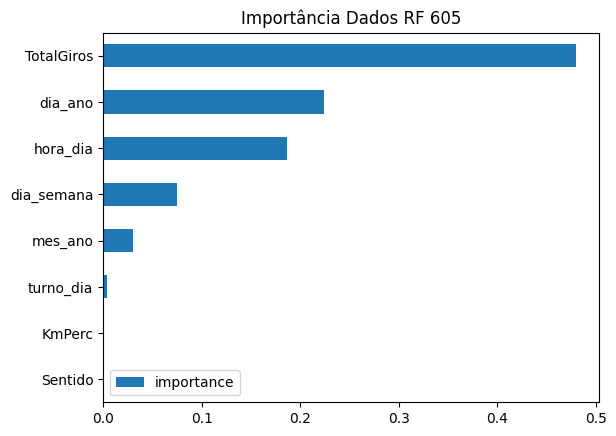

In [34]:
Colunas = [
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia']
]
TestesNome = [
    "0 Teste de Colunas - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)


In [35]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RRSE'].sort_values(by='Valor')

Teste  Rota  \
10  0 Teste de Colunas - ['Sentido','TotalGiros','...   235   
6   0 Teste de Colunas - ['Sentido','TotalGiros','...   235   
8   0 Teste de Colunas - ['Sentido','TotalGiros','...   235   
28  0 Teste de Colunas - ['Sentido','TotalGiros','...  4122   
26  0 Teste de Colunas - ['Sentido','TotalGiros','...  4122   
0   0 Teste de Colunas - ['Sentido','TotalGiros','...  1120   
2   0 Teste de Colunas - ['Sentido','TotalGiros','...  1120   
24  0 Teste de Colunas - ['Sentido','TotalGiros','...  4122   
4   0 Teste de Colunas - ['Sentido','TotalGiros','...  1120   
30  0 Teste de Colunas - ['Sentido','TotalGiros','...   605   
34  0 Teste de Colunas - ['Sentido','TotalGiros','...   605   
16  0 Teste de Colunas - ['Sentido','TotalGiros','...   271   
32  0 Teste de Colunas - ['Sentido','TotalGiros','...   605   
22  0 Teste de Colunas - ['Sentido','TotalGiros','...   362   
20  0 Teste de Colunas - ['Sentido','TotalGiros','...   362   
14  0 Teste de Colunas - ['Sentido','TotalGiros','...   271   
12  0 Teste de Colunas - ['Sentido','TotalGiros','...   271   
18  0 Teste de Colunas - ['Sentido','TotalGiros','...   362   

               Modelo Métrica     Valor  Tempo de treino  Tempo de previsão  
10  Linear Regression    RRSE  0.465795         0.203100            0.10000  
6             XGBoost    RRSE  0.467932         0.207042            0.29820  
8       Random Forest    RRSE  0.470944         0.873070            0.33507  
28  Linear Regression    RRSE  0.626787         0.200100            0.10000  
26      Random Forest    RRSE  0.654194         0.721242            0.28999  
0             XGBoost    RRSE  0.713069         0.250179            0.29970  
2       Random Forest    RRSE  0.717686         0.793280            0.35510  
24            XGBoost    RRSE  0.727654         0.178553            0.29690  
4   Linear Regression    RRSE  0.776848         0.297200            0.20000  
30            XGBoost    RRSE  0.858714         0.164046            0.29650  
34  Linear Regression    RRSE  0.872126         0.300500            0.10010  
16  Linear Regression    RRSE  0.886951         0.300100            0.19990  
32      Random Forest    RRSE  0.906933         0.513107            0.24000  
22  Linear Regression    RRSE  0.913072         0.301600            0.20010  
20      Random Forest    RRSE  0.976755         1.265517            0.51508  
14      Random Forest    RRSE  0.989880         1.891775            0.76000  
12            XGBoost    RRSE  1.004537         0.275037            0.39980  
18            XGBoost    RRSE  1.008496         0.216970            0.29840

  Linha  DuraçãoViagem
0   362     180.525409
1   271     200.506881
2   605     497.489081
3  1120     521.072152
4   235     842.370148
5  4122     862.373308


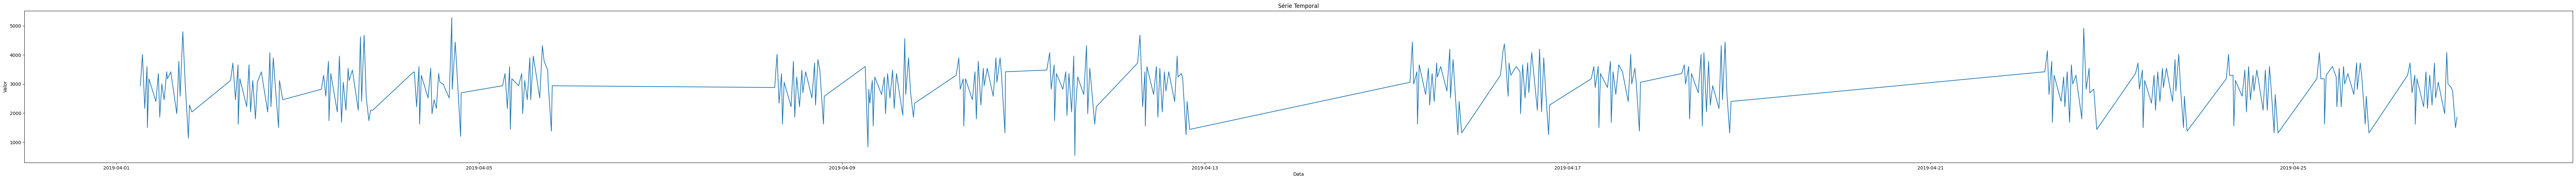

<Figure size 640x480 with 0 Axes>

In [36]:

a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == '4122'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(100, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()
plt.savefig(f"Images/rota_4122.jpg")

In [37]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b

Teste                Data  \
0      0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-10-31 19:44:00   
1      0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-10-31 19:44:00   
2      0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-10-31 19:44:00   
3      0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-10-31 19:44:00   
4      0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-10-31 18:26:00   
...                                                  ...                 ...   
53799  0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-07-16 09:39:00   
53800  0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-07-16 08:37:00   
53801  0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-07-16 08:37:00   
53802  0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-07-16 08:37:00   
53803  0 Teste de Colunas - ['Sentido','TotalGiros','... 2019-07-16 08:37:00   

       Rota             Modelo        Valor  
0      1120            XGBoost  3774.097168  
1      1120      Random Forest  3876.000000  
2      1120  Linear Regression  4127.066903  
3      1120         Tempo real  3600.000000  
4      1120            XGBoost  4085.954102  
...     ...                ...          ...  
53799   605         Tempo real  2640.000000  
53800   605            XGBoost  3238.745850  
53801   605      Random Forest  3385.200000  
53802   605  Linear Regression  3207.493110  
53803   605         Tempo real  2760.000000  

[53804 rows x 5 columns]

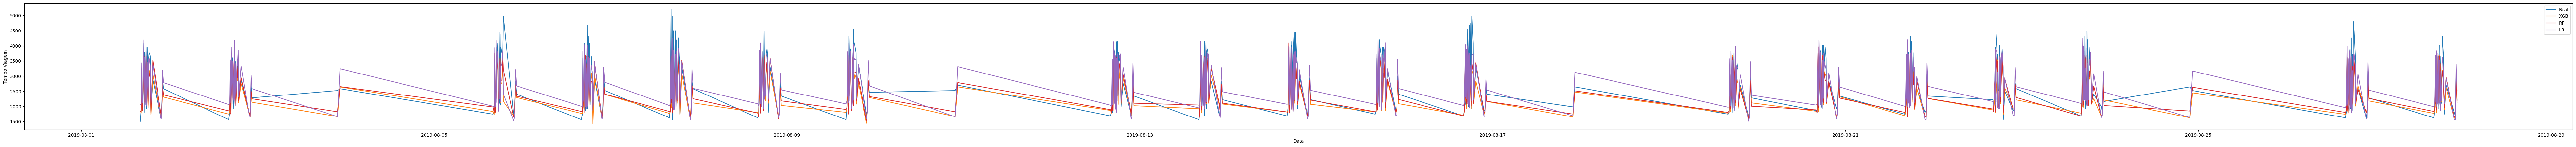

In [38]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b["Data"] = pd.to_datetime(b["Data"]) 
b = b.sort_values(by=["Data"], ascending=False)

plt.figure(figsize=(100, 5))

plt.xlabel("Data")
plt.ylabel("Tempo Viagem")

b = b.loc[(b["Data"] > "2019-08-01") & (b["Data"] < "2019-08-28") & (b['Rota'] == '235')]

real_plor = b.loc[b['Modelo'] == 'Tempo real']
plt.plot(real_plor["Data"], real_plor["Valor"], color="#1f77b4", label="Real")

xgb_plot = b.loc[b['Modelo'] == 'XGBoost']
plt.plot(xgb_plot["Data"], xgb_plot["Valor"], color="#ff7f0e", label="XGB")

rf_plot = b.loc[b['Modelo'] == 'Random Forest']
plt.plot(rf_plot["Data"], rf_plot["Valor"], color="#d62728", label="RF")

lr_plot = b.loc[b['Modelo'] == 'Linear Regression']
plt.plot(lr_plot["Data"], lr_plot["Valor"], color="#9467bd", label="LR")

plt.legend()
plt.show()
#plt.savefig(f"Images/previsao_235.jpg")

In [39]:
df.loc[df['Linha'] == '235']['KmPerc'].unique()

array([21.021, 20.596, 24.11 ])

In [40]:
df.corr()

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


Sentido  DuraçãoViagem  TotalGiros    KmPerc  dia_semana  \
Sentido        1.000000      -0.042329   -0.084571 -0.086509    0.001985   
DuraçãoViagem -0.042329       1.000000    0.380658  0.856472   -0.088650   
TotalGiros    -0.084571       0.380658    1.000000  0.327231   -0.084803   
KmPerc        -0.086509       0.856472    0.327231  1.000000   -0.059518   
dia_semana     0.001985      -0.088650   -0.084803 -0.059518    1.000000   
hora_dia       0.076112      -0.104872    0.068316 -0.065384   -0.007482   
dia_ano        0.001260      -0.030359   -0.011723 -0.023239   -0.007341   
mes_ano        0.001344      -0.030067   -0.011076 -0.023337   -0.007908   
turno_dia      0.071856      -0.150296   -0.044490 -0.087825    0.008228   

               hora_dia   dia_ano   mes_ano  turno_dia  
Sentido        0.076112  0.001260  0.001344   0.071856  
DuraçãoViagem -0.104872 -0.030359 -0.030067  -0.150296  
TotalGiros     0.068316 -0.011723 -0.011076  -0.044490  
KmPerc        -0.065384 -0.023239 -0.023337  -0.087825  
dia_semana    -0.007482 -0.007341 -0.007908   0.008228  
hora_dia       1.000000 -0.000257 -0.000287   0.726953  
dia_ano       -0.000257  1.000000  0.996468   0.001444  
mes_ano       -0.000287  0.996468  1.000000   0.001553  
turno_dia      0.726953  0.001444  0.001553   1.000000

[0]	validation_0-rmse:2745.87974
[1]	validation_0-rmse:1943.53296
[2]	validation_0-rmse:1387.68833
[3]	validation_0-rmse:1006.32581
[4]	validation_0-rmse:749.10335
[5]	validation_0-rmse:579.66931
[6]	validation_0-rmse:471.83577
[7]	validation_0-rmse:405.94169
[8]	validation_0-rmse:365.43787
[9]	validation_0-rmse:340.96364
[10]	validation_0-rmse:328.39240
[11]	validation_0-rmse:319.71708
[12]	validation_0-rmse:313.83635
[13]	validation_0-rmse:310.34462
[14]	validation_0-rmse:306.70710
[15]	validation_0-rmse:302.01084
[16]	validation_0-rmse:298.16911
[17]	validation_0-rmse:294.36644
[18]	validation_0-rmse:292.67155
[19]	validation_0-rmse:290.05872
[20]	validation_0-rmse:286.71065
[21]	validation_0-rmse:285.51248
[22]	validation_0-rmse:281.77675


[23]	validation_0-rmse:280.64581
[24]	validation_0-rmse:277.51919
[25]	validation_0-rmse:276.03233
[26]	validation_0-rmse:273.09035
[27]	validation_0-rmse:269.98771
[28]	validation_0-rmse:267.70848
[29]	validation_0-rmse:266.01499
[30]	validation_0-rmse:264.10248
[31]	validation_0-rmse:262.91246
[32]	validation_0-rmse:261.48523
[33]	validation_0-rmse:258.96345
[34]	validation_0-rmse:257.77978
[35]	validation_0-rmse:256.33569
[36]	validation_0-rmse:255.81174
[37]	validation_0-rmse:253.63757
[38]	validation_0-rmse:251.75700
[39]	validation_0-rmse:250.22266
[40]	validation_0-rmse:248.00097
[41]	validation_0-rmse:242.76506
[42]	validation_0-rmse:240.95862
[43]	validation_0-rmse:238.98644
[44]	validation_0-rmse:236.57400
[45]	validation_0-rmse:235.19412
[46]	validation_0-rmse:233.32238
[47]	validation_0-rmse:232.82138
[48]	validation_0-rmse:230.13639
[49]	validation_0-rmse:229.39108
[50]	validation_0-rmse:227.98172
[51]	validation_0-rmse:227.47660
[52]	validation_0-rmse:227.10658
[53]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2750.70491
[1]	validation_0-rmse:1955.88154
[2]	validation_0-rmse:1408.53794
[3]	validation_0-rmse:1036.17288
[4]	validation_0-rmse:790.37680
[5]	validation_0-rmse:632.90867
[6]	validation_0-rmse:536.36231
[7]	validation_0-rmse:480.76835
[8]	validation_0-rmse:448.94534
[9]	validation_0-rmse:429.92435
[10]	validation_0-rmse:419.26416
[11]	validation_0-rmse:412.68859
[12]	validation_0-rmse:409.44806
[13]	validation_0-rmse:406.01180
[14]	validation_0-rmse:403.52352
[15]	validation_0-rmse:401.19613
[16]	validation_0-rmse:400.29011
[17]	validation_0-rmse:399.17630
[18]	validation_0-rmse:397.47310
[19]	validation_0-rmse:394.75642
[20]	validation_0-rmse:393.90254
[21]	validation_0-rmse:393.23613
[22]	validation_0-rmse:392.07910
[23]	validation_0-rmse:390.38287
[24]	validation_0-rmse:388.74012
[25]	validation_0-rmse:387.72481
[26]	validation_0-rmse:386.47101
[27]	validation_0-rmse:384.71368
[28]	validation_0-rmse:383.83166
[29]	validation_0-rmse:383.32471
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2745.87974
[1]	validation_0-rmse:1943.53296
[2]	validation_0-rmse:1387.68833
[3]	validation_0-rmse:1006.32581
[4]	validation_0-rmse:749.10335
[5]	validation_0-rmse:579.66931
[6]	validation_0-rmse:471.83577
[7]	validation_0-rmse:405.94169
[8]	validation_0-rmse:365.43787
[9]	validation_0-rmse:340.96364
[10]	validation_0-rmse:328.39240
[11]	validation_0-rmse:319.71708
[12]	validation_0-rmse:313.83635
[13]	validation_0-rmse:310.34462
[14]	validation_0-rmse:306.70710
[15]	validation_0-rmse:302.01084
[16]	validation_0-rmse:298.16911
[17]	validation_0-rmse:294.36644
[18]	validation_0-rmse:292.67155
[19]	validation_0-rmse:290.05872
[20]	validation_0-rmse:286.71065
[21]	validation_0-rmse:285.51248
[22]	validation_0-rmse:281.77675
[23]	validation_0-rmse:280.64581
[24]	validation_0-rmse:277.51919
[25]	validation_0-rmse:276.03233
[26]	validation_0-rmse:273.09035
[27]	validation_0-rmse:269.98771
[28]	validation_0-rmse:267.70848
[29]	validation_0-rmse:266.01499
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2746.25736
[1]	validation_0-rmse:1944.77978
[2]	validation_0-rmse:1390.45267
[3]	validation_0-rmse:1010.75800
[4]	validation_0-rmse:754.60508
[5]	validation_0-rmse:587.64226
[6]	validation_0-rmse:482.13152
[7]	validation_0-rmse:418.75896
[8]	validation_0-rmse:379.28263
[9]	validation_0-rmse:357.84717
[10]	validation_0-rmse:344.91603
[11]	validation_0-rmse:337.97694
[12]	validation_0-rmse:329.28313
[13]	validation_0-rmse:326.97023
[14]	validation_0-rmse:325.08522
[15]	validation_0-rmse:322.30510
[16]	validation_0-rmse:321.05612
[17]	validation_0-rmse:316.18112
[18]	validation_0-rmse:313.49602
[19]	validation_0-rmse:309.12535
[20]	validation_0-rmse:306.38249
[21]	validation_0-rmse:302.57362
[22]	validation_0-rmse:301.11979
[23]	validation_0-rmse:299.47078
[24]	validation_0-rmse:298.44192
[25]	validation_0-rmse:295.44562
[26]	validation_0-rmse:292.32129
[27]	validation_0-rmse:291.01971
[28]	validation_0-rmse:289.28938
[29]	validation_0-rmse:288.43098
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2747.12832
[1]	validation_0-rmse:1946.74000
[2]	validation_0-rmse:1393.40347
[3]	validation_0-rmse:1014.18745
[4]	validation_0-rmse:759.60110
[5]	validation_0-rmse:593.75756
[6]	validation_0-rmse:488.54200
[7]	validation_0-rmse:424.78452
[8]	validation_0-rmse:385.50426
[9]	validation_0-rmse:364.04440
[10]	validation_0-rmse:351.19294
[11]	validation_0-rmse:342.96300
[12]	validation_0-rmse:337.78621
[13]	validation_0-rmse:334.79278
[14]	validation_0-rmse:331.85916
[15]	validation_0-rmse:329.53777
[16]	validation_0-rmse:325.25308
[17]	validation_0-rmse:322.00105
[18]	validation_0-rmse:320.29634
[19]	validation_0-rmse:318.94832
[20]	validation_0-rmse:317.47259
[21]	validation_0-rmse:316.43550
[22]	validation_0-rmse:314.73035
[23]	validation_0-rmse:311.03260
[24]	validation_0-rmse:310.33556
[25]	validation_0-rmse:308.11027
[26]	validation_0-rmse:303.58098
[27]	validation_0-rmse:301.46904
[28]	validation_0-rmse:300.22920
[29]	validation_0-rmse:297.39879
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2745.87974
[1]	validation_0-rmse:1943.53296
[2]	validation_0-rmse:1387.68833
[3]	validation_0-rmse:1006.32581
[4]	validation_0-rmse:749.10335
[5]	validation_0-rmse:579.66931
[6]	validation_0-rmse:471.83577
[7]	validation_0-rmse:405.94169
[8]	validation_0-rmse:365.43787
[9]	validation_0-rmse:340.96364
[10]	validation_0-rmse:328.39240
[11]	validation_0-rmse:319.71708
[12]	validation_0-rmse:313.83635
[13]	validation_0-rmse:310.34462
[14]	validation_0-rmse:306.70710
[15]	validation_0-rmse:302.01084
[16]	validation_0-rmse:298.16911
[17]	validation_0-rmse:294.36644
[18]	validation_0-rmse:292.67155
[19]	validation_0-rmse:290.05872
[20]	validation_0-rmse:286.71065
[21]	validation_0-rmse:285.51248
[22]	validation_0-rmse:281.77675
[23]	validation_0-rmse:280.64581
[24]	validation_0-rmse:277.51919
[25]	validation_0-rmse:276.03233
[26]	validation_0-rmse:273.09035
[27]	validation_0-rmse:269.98771
[28]	validation_0-rmse:267.70848
[29]	validation_0-rmse:266.01499
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2747.12832
[1]	validation_0-rmse:1946.74000
[2]	validation_0-rmse:1393.40347
[3]	validation_0-rmse:1014.18745
[4]	validation_0-rmse:759.60110
[5]	validation_0-rmse:593.75756
[6]	validation_0-rmse:488.54200
[7]	validation_0-rmse:424.78452
[8]	validation_0-rmse:385.50426
[9]	validation_0-rmse:364.04440
[10]	validation_0-rmse:351.19294
[11]	validation_0-rmse:342.96300
[12]	validation_0-rmse:337.78621
[13]	validation_0-rmse:334.79278
[14]	validation_0-rmse:331.85916
[15]	validation_0-rmse:329.53777
[16]	validation_0-rmse:325.25308
[17]	validation_0-rmse:322.00105
[18]	validation_0-rmse:320.29634
[19]	validation_0-rmse:318.94832
[20]	validation_0-rmse:317.47259
[21]	validation_0-rmse:316.43550
[22]	validation_0-rmse:314.73035
[23]	validation_0-rmse:311.03260
[24]	validation_0-rmse:310.33556
[25]	validation_0-rmse:308.11027
[26]	validation_0-rmse:303.58098
[27]	validation_0-rmse:301.46904
[28]	validation_0-rmse:300.22920
[29]	validation_0-rmse:297.39879
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2745.87974
[1]	validation_0-rmse:1943.53296
[2]	validation_0-rmse:1387.68833
[3]	validation_0-rmse:1006.32581
[4]	validation_0-rmse:749.10335
[5]	validation_0-rmse:579.66931
[6]	validation_0-rmse:471.83577
[7]	validation_0-rmse:405.94169
[8]	validation_0-rmse:365.43787
[9]	validation_0-rmse:340.96364
[10]	validation_0-rmse:328.39240
[11]	validation_0-rmse:319.71708
[12]	validation_0-rmse:313.83635
[13]	validation_0-rmse:310.34462
[14]	validation_0-rmse:306.70710
[15]	validation_0-rmse:302.01084
[16]	validation_0-rmse:298.16911
[17]	validation_0-rmse:294.36644
[18]	validation_0-rmse:292.67155
[19]	validation_0-rmse:290.05872
[20]	validation_0-rmse:286.71065
[21]	validation_0-rmse:285.51248
[22]	validation_0-rmse:281.77675
[23]	validation_0-rmse:280.64581
[24]	validation_0-rmse:277.51919
[25]	validation_0-rmse:276.03233
[26]	validation_0-rmse:273.09035
[27]	validation_0-rmse:269.98771
[28]	validation_0-rmse:267.70848
[29]	validation_0-rmse:266.01499
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1927.11408
[1]	validation_0-rmse:1375.36832
[2]	validation_0-rmse:996.46082
[3]	validation_0-rmse:739.34327
[4]	validation_0-rmse:568.17531
[5]	validation_0-rmse:457.78233
[6]	validation_0-rmse:386.72801
[7]	validation_0-rmse:345.35359
[8]	validation_0-rmse:320.83808
[9]	validation_0-rmse:305.68421
[10]	validation_0-rmse:293.04832
[11]	validation_0-rmse:286.51042
[12]	validation_0-rmse:280.44759
[13]	validation_0-rmse:274.88960
[14]	validation_0-rmse:272.02213
[15]	validation_0-rmse:267.92702
[16]	validation_0-rmse:266.39593
[17]	validation_0-rmse:264.12645
[18]	validation_0-rmse:262.89972
[19]	validation_0-rmse:258.01553
[20]	validation_0-rmse:252.22449
[21]	validation_0-rmse:249.23973
[22]	validation_0-rmse:248.07140
[23]	validation_0-rmse:246.24790
[24]	validation_0-rmse:242.27031
[25]	validation_0-rmse:238.95944
[26]	validation_0-rmse:238.02140
[27]	validation_0-rmse:235.72666
[28]	validation_0-rmse:233.59254
[29]	validation_0-rmse:231.73019
[30]	validation_0-

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1975.92812
[1]	validation_0-rmse:1477.32936
[2]	validation_0-rmse:1155.36044
[3]	validation_0-rmse:957.49834
[4]	validation_0-rmse:841.58807
[5]	validation_0-rmse:777.77107
[6]	validation_0-rmse:742.08767
[7]	validation_0-rmse:723.84762
[8]	validation_0-rmse:712.53313
[9]	validation_0-rmse:705.89124
[10]	validation_0-rmse:702.58453
[11]	validation_0-rmse:699.32098
[12]	validation_0-rmse:697.22788
[13]	validation_0-rmse:695.58212
[14]	validation_0-rmse:694.55420
[15]	validation_0-rmse:694.02530
[16]	validation_0-rmse:693.13575
[17]	validation_0-rmse:692.60827
[18]	validation_0-rmse:691.86695
[19]	validation_0-rmse:691.31604
[20]	validation_0-rmse:690.88315
[21]	validation_0-rmse:690.03143
[22]	validation_0-rmse:689.46503
[23]	validation_0-rmse:689.03959
[24]	validation_0-rmse:688.65975
[25]	validation_0-rmse:688.40978
[26]	validation_0-rmse:687.96610
[27]	validation_0-rmse:687.68794
[28]	validation_0-rmse:687.48489
[29]	validation_0-rmse:687.19155
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1927.11408
[1]	validation_0-rmse:1375.36832
[2]	validation_0-rmse:996.46082
[3]	validation_0-rmse:739.34327
[4]	validation_0-rmse:568.17531
[5]	validation_0-rmse:457.78233
[6]	validation_0-rmse:386.72801
[7]	validation_0-rmse:345.35359
[8]	validation_0-rmse:320.83808
[9]	validation_0-rmse:305.68421
[10]	validation_0-rmse:293.04832
[11]	validation_0-rmse:286.51042
[12]	validation_0-rmse:280.44759
[13]	validation_0-rmse:274.88960
[14]	validation_0-rmse:272.02213
[15]	validation_0-rmse:267.92702
[16]	validation_0-rmse:266.39593
[17]	validation_0-rmse:264.12645
[18]	validation_0-rmse:262.89972
[19]	validation_0-rmse:258.01553
[20]	validation_0-rmse:252.22449
[21]	validation_0-rmse:249.23973
[22]	validation_0-rmse:248.07140
[23]	validation_0-rmse:246.24790
[24]	validation_0-rmse:242.27031
[25]	validation_0-rmse:238.95944
[26]	validation_0-rmse:238.02140
[27]	validation_0-rmse:235.72666
[28]	validation_0-rmse:233.59254
[29]	validation_0-rmse:231.73019
[30]	validation_0-

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1937.34202
[1]	validation_0-rmse:1397.37108
[2]	validation_0-rmse:1030.15908
[3]	validation_0-rmse:786.27739
[4]	validation_0-rmse:630.22505
[5]	validation_0-rmse:531.98823
[6]	validation_0-rmse:471.75531
[7]	validation_0-rmse:436.25026
[8]	validation_0-rmse:417.58935
[9]	validation_0-rmse:403.86819
[10]	validation_0-rmse:395.93964
[11]	validation_0-rmse:385.99794
[12]	validation_0-rmse:379.74381
[13]	validation_0-rmse:377.29605
[14]	validation_0-rmse:370.36381
[15]	validation_0-rmse:368.88351
[16]	validation_0-rmse:364.78621
[17]	validation_0-rmse:361.79203
[18]	validation_0-rmse:360.09692
[19]	validation_0-rmse:357.46531
[20]	validation_0-rmse:354.79010
[21]	validation_0-rmse:353.78569
[22]	validation_0-rmse:351.98044
[23]	validation_0-rmse:350.01590
[24]	validation_0-rmse:345.44767
[25]	validation_0-rmse:343.71501
[26]	validation_0-rmse:342.79062
[27]	validation_0-rmse:341.59201
[28]	validation_0-rmse:337.54180
[29]	validation_0-rmse:336.52450
[30]	validation_0

c:\Users\Thiago\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


[69]	validation_0-rmse:278.09792
[70]	validation_0-rmse:277.66060
[71]	validation_0-rmse:276.04252
[72]	validation_0-rmse:275.02021
[73]	validation_0-rmse:272.28697
[74]	validation_0-rmse:270.16124
[75]	validation_0-rmse:269.71846
[76]	validation_0-rmse:269.16911
[77]	validation_0-rmse:268.19279
[78]	validation_0-rmse:267.85914
[79]	validation_0-rmse:267.59559
[80]	validation_0-rmse:266.56883
[81]	validation_0-rmse:265.85205
[82]	validation_0-rmse:265.35462
[83]	validation_0-rmse:264.07906
[84]	validation_0-rmse:261.96267
[85]	validation_0-rmse:260.63639
[86]	validation_0-rmse:260.19214
[87]	validation_0-rmse:258.88504
[88]	validation_0-rmse:257.57259
[89]	validation_0-rmse:257.20286
[90]	validation_0-rmse:256.67130
[91]	validation_0-rmse:255.99136
[92]	validation_0-rmse:255.81509
[93]	validation_0-rmse:253.42761
[94]	validation_0-rmse:252.40787
[95]	validation_0-rmse:251.67682
[96]	validation_0-rmse:251.29077
[97]	validation_0-rmse:250.44520
[98]	validation_0-rmse:250.09992
[99]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1927.29632
[1]	validation_0-rmse:1377.93191
[2]	validation_0-rmse:1000.79098
[3]	validation_0-rmse:746.35367
[4]	validation_0-rmse:579.83527
[5]	validation_0-rmse:470.79729
[6]	validation_0-rmse:404.00116
[7]	validation_0-rmse:365.16045
[8]	validation_0-rmse:343.00024
[9]	validation_0-rmse:327.40155
[10]	validation_0-rmse:317.62436
[11]	validation_0-rmse:310.52789
[12]	validation_0-rmse:306.08858
[13]	validation_0-rmse:302.43615
[14]	validation_0-rmse:298.55663
[15]	validation_0-rmse:294.60046
[16]	validation_0-rmse:291.90964
[17]	validation_0-rmse:288.90490
[18]	validation_0-rmse:286.63264
[19]	validation_0-rmse:283.95593
[20]	validation_0-rmse:281.25151
[21]	validation_0-rmse:278.01873
[22]	validation_0-rmse:276.70661
[23]	validation_0-rmse:275.46451
[24]	validation_0-rmse:274.53093
[25]	validation_0-rmse:273.40915
[26]	validation_0-rmse:272.39362
[27]	validation_0-rmse:271.26168
[28]	validation_0-rmse:269.09945
[29]	validation_0-rmse:268.37794
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1927.11408
[1]	validation_0-rmse:1375.36832
[2]	validation_0-rmse:996.46082
[3]	validation_0-rmse:739.34327
[4]	validation_0-rmse:568.17531
[5]	validation_0-rmse:457.78233
[6]	validation_0-rmse:386.72801
[7]	validation_0-rmse:345.35359
[8]	validation_0-rmse:321.57564
[9]	validation_0-rmse:308.40536
[10]	validation_0-rmse:295.29178
[11]	validation_0-rmse:287.49469
[12]	validation_0-rmse:282.64971
[13]	validation_0-rmse:278.89715
[14]	validation_0-rmse:273.31235
[15]	validation_0-rmse:267.16923
[16]	validation_0-rmse:264.97501
[17]	validation_0-rmse:261.52093
[18]	validation_0-rmse:258.65215
[19]	validation_0-rmse:256.46672
[20]	validation_0-rmse:252.24390
[21]	validation_0-rmse:249.51966
[22]	validation_0-rmse:246.33393
[23]	validation_0-rmse:245.32913
[24]	validation_0-rmse:241.25442
[25]	validation_0-rmse:240.18440
[26]	validation_0-rmse:238.48819
[27]	validation_0-rmse:237.91968
[28]	validation_0-rmse:233.70200
[29]	validation_0-rmse:231.64416
[30]	validation_0-

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1927.29632
[1]	validation_0-rmse:1377.93191
[2]	validation_0-rmse:1000.79098
[3]	validation_0-rmse:746.35367
[4]	validation_0-rmse:579.83527
[5]	validation_0-rmse:470.79729
[6]	validation_0-rmse:404.00116
[7]	validation_0-rmse:365.16045
[8]	validation_0-rmse:343.00024
[9]	validation_0-rmse:327.40155
[10]	validation_0-rmse:317.25632
[11]	validation_0-rmse:310.20707
[12]	validation_0-rmse:306.07588
[13]	validation_0-rmse:301.47748
[14]	validation_0-rmse:295.69081
[15]	validation_0-rmse:292.90848
[16]	validation_0-rmse:290.30714
[17]	validation_0-rmse:287.34174
[18]	validation_0-rmse:285.31009
[19]	validation_0-rmse:282.68434
[20]	validation_0-rmse:279.42781
[21]	validation_0-rmse:278.56567
[22]	validation_0-rmse:276.86553
[23]	validation_0-rmse:274.80097
[24]	validation_0-rmse:273.25769
[25]	validation_0-rmse:272.42912
[26]	validation_0-rmse:270.83259
[27]	validation_0-rmse:269.92821
[28]	validation_0-rmse:267.42448
[29]	validation_0-rmse:266.49701
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1926.72920
[1]	validation_0-rmse:1375.49215
[2]	validation_0-rmse:995.63366
[3]	validation_0-rmse:738.60019
[4]	validation_0-rmse:567.29504
[5]	validation_0-rmse:457.59092
[6]	validation_0-rmse:389.14394
[7]	validation_0-rmse:345.11410
[8]	validation_0-rmse:316.26183
[9]	validation_0-rmse:295.98053
[10]	validation_0-rmse:286.93478
[11]	validation_0-rmse:279.65634
[12]	validation_0-rmse:273.28606
[13]	validation_0-rmse:269.65471
[14]	validation_0-rmse:267.44197
[15]	validation_0-rmse:262.78302
[16]	validation_0-rmse:260.63293
[17]	validation_0-rmse:255.07835
[18]	validation_0-rmse:254.34387
[19]	validation_0-rmse:249.55552
[20]	validation_0-rmse:247.07438
[21]	validation_0-rmse:243.48340
[22]	validation_0-rmse:241.24517
[23]	validation_0-rmse:239.27239
[24]	validation_0-rmse:238.24890
[25]	validation_0-rmse:235.80145
[26]	validation_0-rmse:234.58611
[27]	validation_0-rmse:232.43109
[28]	validation_0-rmse:230.10801
[29]	validation_0-rmse:227.74795
[30]	validation_0-

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.08266
[1]	validation_0-rmse:719.22435
[2]	validation_0-rmse:516.90274
[3]	validation_0-rmse:379.62333
[4]	validation_0-rmse:289.02635
[5]	validation_0-rmse:231.30885
[6]	validation_0-rmse:195.66208
[7]	validation_0-rmse:175.69191
[8]	validation_0-rmse:163.22036
[9]	validation_0-rmse:156.29512
[10]	validation_0-rmse:153.06444
[11]	validation_0-rmse:150.61432
[12]	validation_0-rmse:149.06689
[13]	validation_0-rmse:148.21234
[14]	validation_0-rmse:145.66986
[15]	validation_0-rmse:143.51304
[16]	validation_0-rmse:142.62120
[17]	validation_0-rmse:142.18939
[18]	validation_0-rmse:141.30512
[19]	validation_0-rmse:140.50743
[20]	validation_0-rmse:140.22681
[21]	validation_0-rmse:139.41017
[22]	validation_0-rmse:138.29394
[23]	validation_0-rmse:137.37022
[24]	validation_0-rmse:136.75849
[25]	validation_0-rmse:136.11486
[26]	validation_0-rmse:135.63785
[27]	validation_0-rmse:135.44947
[28]	validation_0-rmse:134.76133
[29]	validation_0-rmse:133.83752
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1014.80441
[1]	validation_0-rmse:723.02189
[2]	validation_0-rmse:523.04597
[3]	validation_0-rmse:388.69783
[4]	validation_0-rmse:300.90253
[5]	validation_0-rmse:246.48515
[6]	validation_0-rmse:214.34790
[7]	validation_0-rmse:196.50810
[8]	validation_0-rmse:186.30559
[9]	validation_0-rmse:180.84901
[10]	validation_0-rmse:178.17141
[11]	validation_0-rmse:176.39334
[12]	validation_0-rmse:175.53100
[13]	validation_0-rmse:174.00667
[14]	validation_0-rmse:173.39241
[15]	validation_0-rmse:173.02263
[16]	validation_0-rmse:172.27504
[17]	validation_0-rmse:171.60589
[18]	validation_0-rmse:170.98147
[19]	validation_0-rmse:170.76877
[20]	validation_0-rmse:170.47240
[21]	validation_0-rmse:170.20711
[22]	validation_0-rmse:169.93312
[23]	validation_0-rmse:169.62648
[24]	validation_0-rmse:169.00115
[25]	validation_0-rmse:168.49668
[26]	validation_0-rmse:168.38283
[27]	validation_0-rmse:168.06086
[28]	validation_0-rmse:167.58541
[29]	validation_0-rmse:167.32012
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.08266
[1]	validation_0-rmse:719.22435
[2]	validation_0-rmse:516.90274
[3]	validation_0-rmse:379.62333
[4]	validation_0-rmse:289.02635
[5]	validation_0-rmse:231.30885
[6]	validation_0-rmse:195.66208
[7]	validation_0-rmse:175.69191
[8]	validation_0-rmse:163.22036
[9]	validation_0-rmse:156.29512
[10]	validation_0-rmse:153.06444
[11]	validation_0-rmse:150.61432
[12]	validation_0-rmse:149.06689
[13]	validation_0-rmse:148.21234
[14]	validation_0-rmse:145.66986
[15]	validation_0-rmse:143.51304
[16]	validation_0-rmse:142.62120
[17]	validation_0-rmse:142.18939
[18]	validation_0-rmse:141.30512
[19]	validation_0-rmse:140.50743
[20]	validation_0-rmse:140.22681
[21]	validation_0-rmse:139.41017
[22]	validation_0-rmse:138.29394
[23]	validation_0-rmse:137.37022
[24]	validation_0-rmse:136.75849
[25]	validation_0-rmse:136.11486
[26]	validation_0-rmse:135.63785
[27]	validation_0-rmse:135.44947
[28]	validation_0-rmse:134.76133
[29]	validation_0-rmse:133.83752
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.74097
[1]	validation_0-rmse:720.87371
[2]	validation_0-rmse:519.78162
[3]	validation_0-rmse:383.79062
[4]	validation_0-rmse:293.56598
[5]	validation_0-rmse:237.00104
[6]	validation_0-rmse:202.29439
[7]	validation_0-rmse:182.68414
[8]	validation_0-rmse:171.57560
[9]	validation_0-rmse:164.50867
[10]	validation_0-rmse:160.57752
[11]	validation_0-rmse:158.31599
[12]	validation_0-rmse:157.16904
[13]	validation_0-rmse:156.30603
[14]	validation_0-rmse:155.29463
[15]	validation_0-rmse:154.82433
[16]	validation_0-rmse:153.44749
[17]	validation_0-rmse:152.88238
[18]	validation_0-rmse:151.46351
[19]	validation_0-rmse:150.36289
[20]	validation_0-rmse:150.15490
[21]	validation_0-rmse:149.21235
[22]	validation_0-rmse:148.13993
[23]	validation_0-rmse:146.62132
[24]	validation_0-rmse:145.63480
[25]	validation_0-rmse:145.24979
[26]	validation_0-rmse:144.40025
[27]	validation_0-rmse:143.87242
[28]	validation_0-rmse:143.73574
[29]	validation_0-rmse:143.19534
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.68287
[1]	validation_0-rmse:720.65835
[2]	validation_0-rmse:519.02344
[3]	validation_0-rmse:382.09065
[4]	validation_0-rmse:291.80358
[5]	validation_0-rmse:234.68704
[6]	validation_0-rmse:200.73066
[7]	validation_0-rmse:181.18297
[8]	validation_0-rmse:170.28942
[9]	validation_0-rmse:164.45071
[10]	validation_0-rmse:160.58668
[11]	validation_0-rmse:158.48013
[12]	validation_0-rmse:157.41549
[13]	validation_0-rmse:154.85135
[14]	validation_0-rmse:153.44003
[15]	validation_0-rmse:153.03201
[16]	validation_0-rmse:151.62316
[17]	validation_0-rmse:151.30264
[18]	validation_0-rmse:150.12656
[19]	validation_0-rmse:149.44762
[20]	validation_0-rmse:148.51639
[21]	validation_0-rmse:148.19088
[22]	validation_0-rmse:148.01232
[23]	validation_0-rmse:147.44826
[24]	validation_0-rmse:146.34539
[25]	validation_0-rmse:145.81918
[26]	validation_0-rmse:145.28742
[27]	validation_0-rmse:144.72958
[28]	validation_0-rmse:144.44028
[29]	validation_0-rmse:143.80838
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.08266
[1]	validation_0-rmse:719.22435
[2]	validation_0-rmse:516.90274
[3]	validation_0-rmse:379.62333
[4]	validation_0-rmse:289.02635
[5]	validation_0-rmse:231.30885
[6]	validation_0-rmse:195.66208
[7]	validation_0-rmse:175.69191
[8]	validation_0-rmse:163.22036
[9]	validation_0-rmse:156.29512
[10]	validation_0-rmse:153.06444
[11]	validation_0-rmse:150.61432
[12]	validation_0-rmse:149.06689
[13]	validation_0-rmse:148.21234
[14]	validation_0-rmse:145.66986
[15]	validation_0-rmse:143.51304
[16]	validation_0-rmse:142.62120
[17]	validation_0-rmse:142.18939
[18]	validation_0-rmse:141.30512
[19]	validation_0-rmse:140.50743
[20]	validation_0-rmse:140.22681
[21]	validation_0-rmse:139.41017
[22]	validation_0-rmse:138.29394
[23]	validation_0-rmse:137.37022
[24]	validation_0-rmse:136.75849
[25]	validation_0-rmse:136.11486
[26]	validation_0-rmse:135.63785
[27]	validation_0-rmse:135.44947
[28]	validation_0-rmse:134.76133
[29]	validation_0-rmse:133.83752
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.68287
[1]	validation_0-rmse:720.65835
[2]	validation_0-rmse:519.02344
[3]	validation_0-rmse:382.09065
[4]	validation_0-rmse:291.80358
[5]	validation_0-rmse:234.68704
[6]	validation_0-rmse:200.73066
[7]	validation_0-rmse:181.18297
[8]	validation_0-rmse:170.28942
[9]	validation_0-rmse:164.45071
[10]	validation_0-rmse:160.58668
[11]	validation_0-rmse:158.48013
[12]	validation_0-rmse:157.41549
[13]	validation_0-rmse:154.85135
[14]	validation_0-rmse:153.44003
[15]	validation_0-rmse:153.03201
[16]	validation_0-rmse:151.62316
[17]	validation_0-rmse:151.30264
[18]	validation_0-rmse:150.12656
[19]	validation_0-rmse:149.44762
[20]	validation_0-rmse:148.51639
[21]	validation_0-rmse:148.19088
[22]	validation_0-rmse:148.01232
[23]	validation_0-rmse:147.44826
[24]	validation_0-rmse:146.34539
[25]	validation_0-rmse:145.81918
[26]	validation_0-rmse:145.28742
[27]	validation_0-rmse:144.72958
[28]	validation_0-rmse:144.44028
[29]	validation_0-rmse:143.80838
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.08266
[1]	validation_0-rmse:719.22435
[2]	validation_0-rmse:516.90274
[3]	validation_0-rmse:379.62333
[4]	validation_0-rmse:289.02635
[5]	validation_0-rmse:231.30885
[6]	validation_0-rmse:195.66208
[7]	validation_0-rmse:175.69191
[8]	validation_0-rmse:163.22036
[9]	validation_0-rmse:156.29512
[10]	validation_0-rmse:153.06444
[11]	validation_0-rmse:150.61432
[12]	validation_0-rmse:149.06689
[13]	validation_0-rmse:148.21234
[14]	validation_0-rmse:145.66986
[15]	validation_0-rmse:143.51304
[16]	validation_0-rmse:142.62120
[17]	validation_0-rmse:142.18939
[18]	validation_0-rmse:141.30512
[19]	validation_0-rmse:140.50743
[20]	validation_0-rmse:140.22681
[21]	validation_0-rmse:139.41017
[22]	validation_0-rmse:138.29394
[23]	validation_0-rmse:137.37022
[24]	validation_0-rmse:136.75849
[25]	validation_0-rmse:136.11486
[26]	validation_0-rmse:135.63785
[27]	validation_0-rmse:135.44947
[28]	validation_0-rmse:134.76133
[29]	validation_0-rmse:133.83752
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:601.38111
[1]	validation_0-rmse:435.42730
[2]	validation_0-rmse:323.37999
[3]	validation_0-rmse:249.57293
[4]	validation_0-rmse:203.04141
[5]	validation_0-rmse:175.53953
[6]	validation_0-rmse:159.30246
[7]	validation_0-rmse:150.02434
[8]	validation_0-rmse:144.06254
[9]	validation_0-rmse:140.73732
[10]	validation_0-rmse:138.79877
[11]	validation_0-rmse:136.94832
[12]	validation_0-rmse:135.74492
[13]	validation_0-rmse:135.23831
[14]	validation_0-rmse:134.21688
[15]	validation_0-rmse:133.85238
[16]	validation_0-rmse:133.28242
[17]	validation_0-rmse:132.25349
[18]	validation_0-rmse:131.97162
[19]	validation_0-rmse:131.05125
[20]	validation_0-rmse:130.69286
[21]	validation_0-rmse:130.37471
[22]	validation_0-rmse:129.98270
[23]	validation_0-rmse:129.45398
[24]	validation_0-rmse:128.43698
[25]	validation_0-rmse:128.07084
[26]	validation_0-rmse:127.26752
[27]	validation_0-rmse:126.83248
[28]	validation_0-rmse:126.07133
[29]	validation_0-rmse:125.41195
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:602.61548
[1]	validation_0-rmse:438.19686
[2]	validation_0-rmse:327.75699
[3]	validation_0-rmse:256.15329
[4]	validation_0-rmse:212.18236
[5]	validation_0-rmse:185.96030
[6]	validation_0-rmse:171.26464
[7]	validation_0-rmse:162.52895
[8]	validation_0-rmse:158.33664
[9]	validation_0-rmse:155.23819
[10]	validation_0-rmse:153.69994
[11]	validation_0-rmse:152.67597
[12]	validation_0-rmse:151.38173
[13]	validation_0-rmse:150.86686
[14]	validation_0-rmse:150.50158
[15]	validation_0-rmse:150.02656
[16]	validation_0-rmse:149.71714
[17]	validation_0-rmse:148.89842
[18]	validation_0-rmse:148.45975
[19]	validation_0-rmse:147.75903
[20]	validation_0-rmse:147.45678
[21]	validation_0-rmse:146.81205
[22]	validation_0-rmse:146.22227
[23]	validation_0-rmse:145.99917
[24]	validation_0-rmse:145.86687
[25]	validation_0-rmse:145.63454
[26]	validation_0-rmse:145.48467
[27]	validation_0-rmse:145.14289
[28]	validation_0-rmse:144.78603
[29]	validation_0-rmse:144.60775
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:601.38111
[1]	validation_0-rmse:435.42730
[2]	validation_0-rmse:323.37999
[3]	validation_0-rmse:249.57293
[4]	validation_0-rmse:203.04141
[5]	validation_0-rmse:175.53953
[6]	validation_0-rmse:159.30246
[7]	validation_0-rmse:150.02434
[8]	validation_0-rmse:144.06254
[9]	validation_0-rmse:140.73732
[10]	validation_0-rmse:138.79877
[11]	validation_0-rmse:136.94832
[12]	validation_0-rmse:135.74492
[13]	validation_0-rmse:135.23831
[14]	validation_0-rmse:134.21688
[15]	validation_0-rmse:133.85238
[16]	validation_0-rmse:133.28242
[17]	validation_0-rmse:132.25349
[18]	validation_0-rmse:131.97162
[19]	validation_0-rmse:131.05125
[20]	validation_0-rmse:130.69286
[21]	validation_0-rmse:130.37471
[22]	validation_0-rmse:129.98270
[23]	validation_0-rmse:129.45398
[24]	validation_0-rmse:128.43698
[25]	validation_0-rmse:128.07084
[26]	validation_0-rmse:127.26752
[27]	validation_0-rmse:126.83248
[28]	validation_0-rmse:126.07133
[29]	validation_0-rmse:125.41195
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:602.39690
[1]	validation_0-rmse:437.37922
[2]	validation_0-rmse:326.28947
[3]	validation_0-rmse:254.63643
[4]	validation_0-rmse:209.16881
[5]	validation_0-rmse:181.91819
[6]	validation_0-rmse:166.39032
[7]	validation_0-rmse:157.86851
[8]	validation_0-rmse:152.70521
[9]	validation_0-rmse:149.47534
[10]	validation_0-rmse:147.64794
[11]	validation_0-rmse:146.32477
[12]	validation_0-rmse:145.10555
[13]	validation_0-rmse:144.13490
[14]	validation_0-rmse:143.45678
[15]	validation_0-rmse:142.95619
[16]	validation_0-rmse:142.50941
[17]	validation_0-rmse:141.47857
[18]	validation_0-rmse:140.72834
[19]	validation_0-rmse:139.51300
[20]	validation_0-rmse:139.31635
[21]	validation_0-rmse:138.91520
[22]	validation_0-rmse:138.39525
[23]	validation_0-rmse:137.70864
[24]	validation_0-rmse:137.39276
[25]	validation_0-rmse:137.03560
[26]	validation_0-rmse:136.32510
[27]	validation_0-rmse:135.86022
[28]	validation_0-rmse:135.42458
[29]	validation_0-rmse:134.82059
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:601.44295
[1]	validation_0-rmse:435.59039
[2]	validation_0-rmse:323.61563
[3]	validation_0-rmse:250.34321
[4]	validation_0-rmse:204.20168
[5]	validation_0-rmse:176.70303
[6]	validation_0-rmse:160.72688
[7]	validation_0-rmse:152.29241
[8]	validation_0-rmse:146.60098
[9]	validation_0-rmse:143.13823
[10]	validation_0-rmse:141.31185
[11]	validation_0-rmse:139.53710
[12]	validation_0-rmse:138.85015
[13]	validation_0-rmse:137.27333
[14]	validation_0-rmse:136.82298
[15]	validation_0-rmse:135.86874
[16]	validation_0-rmse:135.04133
[17]	validation_0-rmse:134.78921
[18]	validation_0-rmse:134.16087
[19]	validation_0-rmse:133.46054
[20]	validation_0-rmse:132.76600
[21]	validation_0-rmse:132.26532
[22]	validation_0-rmse:131.51888
[23]	validation_0-rmse:130.86808
[24]	validation_0-rmse:130.55638
[25]	validation_0-rmse:129.79963
[26]	validation_0-rmse:129.14148
[27]	validation_0-rmse:128.92136
[28]	validation_0-rmse:128.25172
[29]	validation_0-rmse:127.81016
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:601.38111
[1]	validation_0-rmse:435.42730
[2]	validation_0-rmse:323.37999
[3]	validation_0-rmse:249.57293
[4]	validation_0-rmse:203.04141
[5]	validation_0-rmse:175.53953
[6]	validation_0-rmse:159.30246
[7]	validation_0-rmse:150.02434
[8]	validation_0-rmse:144.06254
[9]	validation_0-rmse:140.73732
[10]	validation_0-rmse:138.79877
[11]	validation_0-rmse:136.94832
[12]	validation_0-rmse:135.74492
[13]	validation_0-rmse:135.23831
[14]	validation_0-rmse:134.21688
[15]	validation_0-rmse:133.85238
[16]	validation_0-rmse:133.28242
[17]	validation_0-rmse:132.25349
[18]	validation_0-rmse:131.97162
[19]	validation_0-rmse:131.05125
[20]	validation_0-rmse:130.69286
[21]	validation_0-rmse:130.37471
[22]	validation_0-rmse:129.98270
[23]	validation_0-rmse:129.45398
[24]	validation_0-rmse:128.43698
[25]	validation_0-rmse:128.07084
[26]	validation_0-rmse:127.26752
[27]	validation_0-rmse:126.83248
[28]	validation_0-rmse:126.07133
[29]	validation_0-rmse:125.41195
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:601.44295
[1]	validation_0-rmse:435.59039
[2]	validation_0-rmse:323.61563
[3]	validation_0-rmse:250.34321
[4]	validation_0-rmse:204.20168
[5]	validation_0-rmse:176.70303
[6]	validation_0-rmse:160.72688
[7]	validation_0-rmse:152.29241
[8]	validation_0-rmse:146.60098
[9]	validation_0-rmse:143.13823
[10]	validation_0-rmse:141.31185
[11]	validation_0-rmse:139.53710
[12]	validation_0-rmse:138.85015
[13]	validation_0-rmse:137.27333
[14]	validation_0-rmse:136.82298
[15]	validation_0-rmse:135.86874
[16]	validation_0-rmse:135.04133
[17]	validation_0-rmse:134.78921
[18]	validation_0-rmse:134.16087
[19]	validation_0-rmse:133.46054
[20]	validation_0-rmse:132.76600
[21]	validation_0-rmse:132.26532
[22]	validation_0-rmse:131.51888
[23]	validation_0-rmse:130.86808
[24]	validation_0-rmse:130.55638
[25]	validation_0-rmse:129.79963
[26]	validation_0-rmse:129.14148
[27]	validation_0-rmse:128.92136
[28]	validation_0-rmse:128.25172
[29]	validation_0-rmse:127.81016
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:601.38111
[1]	validation_0-rmse:435.42730
[2]	validation_0-rmse:323.37999
[3]	validation_0-rmse:249.57293
[4]	validation_0-rmse:203.04141
[5]	validation_0-rmse:175.53953
[6]	validation_0-rmse:159.30246
[7]	validation_0-rmse:150.02434
[8]	validation_0-rmse:144.06254
[9]	validation_0-rmse:140.73732
[10]	validation_0-rmse:138.79877
[11]	validation_0-rmse:136.94832
[12]	validation_0-rmse:135.74492
[13]	validation_0-rmse:135.23831
[14]	validation_0-rmse:134.21688
[15]	validation_0-rmse:133.85238
[16]	validation_0-rmse:133.28242
[17]	validation_0-rmse:132.25349
[18]	validation_0-rmse:131.97162
[19]	validation_0-rmse:131.05125
[20]	validation_0-rmse:130.69286
[21]	validation_0-rmse:130.37471
[22]	validation_0-rmse:129.98270
[23]	validation_0-rmse:129.45398
[24]	validation_0-rmse:128.43698
[25]	validation_0-rmse:128.07084
[26]	validation_0-rmse:127.26752
[27]	validation_0-rmse:126.83248
[28]	validation_0-rmse:126.07133
[29]	validation_0-rmse:125.41195
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2245.07952
[1]	validation_0-rmse:1608.08796
[2]	validation_0-rmse:1170.62354
[3]	validation_0-rmse:877.20704
[4]	validation_0-rmse:683.32980
[5]	validation_0-rmse:560.88281
[6]	validation_0-rmse:483.85816
[7]	validation_0-rmse:438.61740
[8]	validation_0-rmse:412.55460
[9]	validation_0-rmse:396.53711
[10]	validation_0-rmse:384.34483
[11]	validation_0-rmse:376.90725
[12]	validation_0-rmse:371.63830
[13]	validation_0-rmse:365.48042
[14]	validation_0-rmse:362.89756
[15]	validation_0-rmse:360.25896
[16]	validation_0-rmse:358.17593
[17]	validation_0-rmse:355.52269
[18]	validation_0-rmse:355.01230
[19]	validation_0-rmse:352.05102
[20]	validation_0-rmse:349.34086
[21]	validation_0-rmse:344.44638
[22]	validation_0-rmse:343.74656
[23]	validation_0-rmse:339.75001
[24]	validation_0-rmse:337.42050
[25]	validation_0-rmse:335.90747
[26]	validation_0-rmse:333.80990
[27]	validation_0-rmse:329.99765
[28]	validation_0-rmse:328.01426
[29]	validation_0-rmse:327.53065
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2282.10407
[1]	validation_0-rmse:1685.19630
[2]	validation_0-rmse:1293.24515
[3]	validation_0-rmse:1045.00543
[4]	validation_0-rmse:895.38060
[5]	validation_0-rmse:808.21982
[6]	validation_0-rmse:760.86780
[7]	validation_0-rmse:733.95876
[8]	validation_0-rmse:719.34571
[9]	validation_0-rmse:710.10818
[10]	validation_0-rmse:706.11134
[11]	validation_0-rmse:701.19758
[12]	validation_0-rmse:699.17408
[13]	validation_0-rmse:697.66453
[14]	validation_0-rmse:696.69083
[15]	validation_0-rmse:695.92619
[16]	validation_0-rmse:693.31869
[17]	validation_0-rmse:690.85403
[18]	validation_0-rmse:689.93297
[19]	validation_0-rmse:688.65590
[20]	validation_0-rmse:687.12487
[21]	validation_0-rmse:686.33528
[22]	validation_0-rmse:684.83024
[23]	validation_0-rmse:683.97117
[24]	validation_0-rmse:683.17285
[25]	validation_0-rmse:681.86858
[26]	validation_0-rmse:681.56184
[27]	validation_0-rmse:680.67749
[28]	validation_0-rmse:680.38627
[29]	validation_0-rmse:678.59099
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2245.07952
[1]	validation_0-rmse:1608.08796
[2]	validation_0-rmse:1170.62354
[3]	validation_0-rmse:877.20704
[4]	validation_0-rmse:683.32980
[5]	validation_0-rmse:560.88281
[6]	validation_0-rmse:483.85816
[7]	validation_0-rmse:438.61740
[8]	validation_0-rmse:412.55460
[9]	validation_0-rmse:396.53711
[10]	validation_0-rmse:384.34483
[11]	validation_0-rmse:376.90725
[12]	validation_0-rmse:371.63830
[13]	validation_0-rmse:365.48042
[14]	validation_0-rmse:362.89756
[15]	validation_0-rmse:360.25896
[16]	validation_0-rmse:358.17593
[17]	validation_0-rmse:355.52269
[18]	validation_0-rmse:355.01230
[19]	validation_0-rmse:352.05102
[20]	validation_0-rmse:349.34086
[21]	validation_0-rmse:344.44638
[22]	validation_0-rmse:343.74656
[23]	validation_0-rmse:339.75001
[24]	validation_0-rmse:337.42050
[25]	validation_0-rmse:335.90747
[26]	validation_0-rmse:333.80990
[27]	validation_0-rmse:329.99765
[28]	validation_0-rmse:328.01426
[29]	validation_0-rmse:327.53065
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2260.20679
[1]	validation_0-rmse:1640.99184
[2]	validation_0-rmse:1222.88646
[3]	validation_0-rmse:945.45770
[4]	validation_0-rmse:772.34364
[5]	validation_0-rmse:668.00937
[6]	validation_0-rmse:606.64918
[7]	validation_0-rmse:569.81218
[8]	validation_0-rmse:546.55710
[9]	validation_0-rmse:532.53300
[10]	validation_0-rmse:520.39982
[11]	validation_0-rmse:514.14285
[12]	validation_0-rmse:508.95436
[13]	validation_0-rmse:506.46123
[14]	validation_0-rmse:501.51346
[15]	validation_0-rmse:498.74775
[16]	validation_0-rmse:492.10800
[17]	validation_0-rmse:487.45465
[18]	validation_0-rmse:480.69210
[19]	validation_0-rmse:475.93738
[20]	validation_0-rmse:471.46879
[21]	validation_0-rmse:470.33755
[22]	validation_0-rmse:468.44766
[23]	validation_0-rmse:464.94132
[24]	validation_0-rmse:464.20481
[25]	validation_0-rmse:456.40676
[26]	validation_0-rmse:453.02298
[27]	validation_0-rmse:450.19898
[28]	validation_0-rmse:447.36534
[29]	validation_0-rmse:444.69781
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2246.19732
[1]	validation_0-rmse:1611.02878
[2]	validation_0-rmse:1177.15760
[3]	validation_0-rmse:887.02711
[4]	validation_0-rmse:697.17346
[5]	validation_0-rmse:579.42665
[6]	validation_0-rmse:507.28139
[7]	validation_0-rmse:465.16804
[8]	validation_0-rmse:440.62792
[9]	validation_0-rmse:424.89864
[10]	validation_0-rmse:413.33907
[11]	validation_0-rmse:407.86182
[12]	validation_0-rmse:401.23150
[13]	validation_0-rmse:397.78451
[14]	validation_0-rmse:394.88256
[15]	validation_0-rmse:392.47597
[16]	validation_0-rmse:391.10654
[17]	validation_0-rmse:387.54754
[18]	validation_0-rmse:382.01790
[19]	validation_0-rmse:380.36549
[20]	validation_0-rmse:378.92781
[21]	validation_0-rmse:377.73891
[22]	validation_0-rmse:376.51708
[23]	validation_0-rmse:372.45591
[24]	validation_0-rmse:369.06945
[25]	validation_0-rmse:368.16867
[26]	validation_0-rmse:365.57811
[27]	validation_0-rmse:364.26173
[28]	validation_0-rmse:361.29239
[29]	validation_0-rmse:358.09708
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2245.07952
[1]	validation_0-rmse:1608.08796
[2]	validation_0-rmse:1170.62354
[3]	validation_0-rmse:877.20704
[4]	validation_0-rmse:683.32980
[5]	validation_0-rmse:560.88281
[6]	validation_0-rmse:483.85816
[7]	validation_0-rmse:438.61740
[8]	validation_0-rmse:412.55460
[9]	validation_0-rmse:396.53711
[10]	validation_0-rmse:384.34483
[11]	validation_0-rmse:376.90725
[12]	validation_0-rmse:371.63830
[13]	validation_0-rmse:365.48042
[14]	validation_0-rmse:362.89756
[15]	validation_0-rmse:360.25896
[16]	validation_0-rmse:358.17593
[17]	validation_0-rmse:355.52269
[18]	validation_0-rmse:355.01230
[19]	validation_0-rmse:352.05102
[20]	validation_0-rmse:349.34086
[21]	validation_0-rmse:344.44638
[22]	validation_0-rmse:343.74656
[23]	validation_0-rmse:339.75001
[24]	validation_0-rmse:337.42050
[25]	validation_0-rmse:335.90747
[26]	validation_0-rmse:333.80990
[27]	validation_0-rmse:329.99765
[28]	validation_0-rmse:328.01426
[29]	validation_0-rmse:327.53065
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2246.19732
[1]	validation_0-rmse:1611.02878
[2]	validation_0-rmse:1177.15760
[3]	validation_0-rmse:887.02711
[4]	validation_0-rmse:697.17346
[5]	validation_0-rmse:579.42665
[6]	validation_0-rmse:507.28139
[7]	validation_0-rmse:465.16804
[8]	validation_0-rmse:440.62792
[9]	validation_0-rmse:424.89864
[10]	validation_0-rmse:413.33907
[11]	validation_0-rmse:407.86182
[12]	validation_0-rmse:401.23150
[13]	validation_0-rmse:397.78451
[14]	validation_0-rmse:394.88256
[15]	validation_0-rmse:392.47597
[16]	validation_0-rmse:391.10654
[17]	validation_0-rmse:387.54754
[18]	validation_0-rmse:382.01790
[19]	validation_0-rmse:380.36549
[20]	validation_0-rmse:378.92781
[21]	validation_0-rmse:377.73891
[22]	validation_0-rmse:376.51708
[23]	validation_0-rmse:372.45591
[24]	validation_0-rmse:369.06945
[25]	validation_0-rmse:368.16867
[26]	validation_0-rmse:365.57811
[27]	validation_0-rmse:364.26173
[28]	validation_0-rmse:361.29239
[29]	validation_0-rmse:358.09708
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2245.07952
[1]	validation_0-rmse:1608.08796
[2]	validation_0-rmse:1170.62354
[3]	validation_0-rmse:877.20704
[4]	validation_0-rmse:683.32980
[5]	validation_0-rmse:560.88281
[6]	validation_0-rmse:483.85816
[7]	validation_0-rmse:438.61740
[8]	validation_0-rmse:412.55460
[9]	validation_0-rmse:396.53711
[10]	validation_0-rmse:384.34483
[11]	validation_0-rmse:376.90725
[12]	validation_0-rmse:371.63830
[13]	validation_0-rmse:365.48042
[14]	validation_0-rmse:362.89756
[15]	validation_0-rmse:360.25896
[16]	validation_0-rmse:358.17593
[17]	validation_0-rmse:355.52269
[18]	validation_0-rmse:355.01230
[19]	validation_0-rmse:352.05102
[20]	validation_0-rmse:349.34086
[21]	validation_0-rmse:344.44638
[22]	validation_0-rmse:343.74656
[23]	validation_0-rmse:339.75001
[24]	validation_0-rmse:337.42050
[25]	validation_0-rmse:335.90747
[26]	validation_0-rmse:333.80990
[27]	validation_0-rmse:329.99765
[28]	validation_0-rmse:328.01426
[29]	validation_0-rmse:327.53065
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2330.94275
[1]	validation_0-rmse:1651.77786
[2]	validation_0-rmse:1182.30330
[3]	validation_0-rmse:860.35267
[4]	validation_0-rmse:643.20440
[5]	validation_0-rmse:499.97058
[6]	validation_0-rmse:409.82351
[7]	validation_0-rmse:353.77053
[8]	validation_0-rmse:318.74275
[9]	validation_0-rmse:297.19506
[10]	validation_0-rmse:285.73857
[11]	validation_0-rmse:277.50367
[12]	validation_0-rmse:272.72821
[13]	validation_0-rmse:267.50209
[14]	validation_0-rmse:264.42743
[15]	validation_0-rmse:262.70867
[16]	validation_0-rmse:258.48946
[17]	validation_0-rmse:257.55570
[18]	validation_0-rmse:253.76637
[19]	validation_0-rmse:250.27685
[20]	validation_0-rmse:247.45539
[21]	validation_0-rmse:245.94892
[22]	validation_0-rmse:242.76191
[23]	validation_0-rmse:240.14974
[24]	validation_0-rmse:239.54226
[25]	validation_0-rmse:238.70965
[26]	validation_0-rmse:236.93242
[27]	validation_0-rmse:235.02414
[28]	validation_0-rmse:231.55555
[29]	validation_0-rmse:229.77188
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2331.80326
[1]	validation_0-rmse:1652.61923
[2]	validation_0-rmse:1183.65751
[3]	validation_0-rmse:862.88225
[4]	validation_0-rmse:648.81343
[5]	validation_0-rmse:508.12584
[6]	validation_0-rmse:421.06514
[7]	validation_0-rmse:367.07714
[8]	validation_0-rmse:335.94455
[9]	validation_0-rmse:314.73180
[10]	validation_0-rmse:300.05963
[11]	validation_0-rmse:293.32411
[12]	validation_0-rmse:285.74047
[13]	validation_0-rmse:282.83579
[14]	validation_0-rmse:280.22064
[15]	validation_0-rmse:275.72177
[16]	validation_0-rmse:273.15695
[17]	validation_0-rmse:271.94687
[18]	validation_0-rmse:270.24470
[19]	validation_0-rmse:267.15933
[20]	validation_0-rmse:266.47642
[21]	validation_0-rmse:263.97830
[22]	validation_0-rmse:263.21506
[23]	validation_0-rmse:260.98659
[24]	validation_0-rmse:260.18005
[25]	validation_0-rmse:259.80642
[26]	validation_0-rmse:257.68184
[27]	validation_0-rmse:256.30624
[28]	validation_0-rmse:254.27249
[29]	validation_0-rmse:252.93232
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2330.94275
[1]	validation_0-rmse:1651.77786
[2]	validation_0-rmse:1182.30330
[3]	validation_0-rmse:860.35267
[4]	validation_0-rmse:643.20440
[5]	validation_0-rmse:499.97058
[6]	validation_0-rmse:409.82351
[7]	validation_0-rmse:353.77053
[8]	validation_0-rmse:318.74275
[9]	validation_0-rmse:297.19506
[10]	validation_0-rmse:285.73857
[11]	validation_0-rmse:277.50367
[12]	validation_0-rmse:272.72821
[13]	validation_0-rmse:267.50209
[14]	validation_0-rmse:264.42743
[15]	validation_0-rmse:262.70867
[16]	validation_0-rmse:258.48946
[17]	validation_0-rmse:257.55570
[18]	validation_0-rmse:253.76637
[19]	validation_0-rmse:250.27685
[20]	validation_0-rmse:247.45539
[21]	validation_0-rmse:245.94892
[22]	validation_0-rmse:242.76191
[23]	validation_0-rmse:240.14974
[24]	validation_0-rmse:239.54226
[25]	validation_0-rmse:238.70965
[26]	validation_0-rmse:236.93242
[27]	validation_0-rmse:235.02414
[28]	validation_0-rmse:231.55555
[29]	validation_0-rmse:229.77188
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2330.94275
[1]	validation_0-rmse:1651.77786
[2]	validation_0-rmse:1182.30330
[3]	validation_0-rmse:860.35267
[4]	validation_0-rmse:643.20440
[5]	validation_0-rmse:499.97058
[6]	validation_0-rmse:409.82351
[7]	validation_0-rmse:353.77053
[8]	validation_0-rmse:318.74275
[9]	validation_0-rmse:297.19506
[10]	validation_0-rmse:285.73857
[11]	validation_0-rmse:277.50367
[12]	validation_0-rmse:272.72821
[13]	validation_0-rmse:267.50209
[14]	validation_0-rmse:264.42743
[15]	validation_0-rmse:262.70867
[16]	validation_0-rmse:258.48946
[17]	validation_0-rmse:257.55570
[18]	validation_0-rmse:253.76637
[19]	validation_0-rmse:250.27685
[20]	validation_0-rmse:247.45539
[21]	validation_0-rmse:245.94892
[22]	validation_0-rmse:242.76191
[23]	validation_0-rmse:240.14974
[24]	validation_0-rmse:239.54226
[25]	validation_0-rmse:238.70965
[26]	validation_0-rmse:236.93242
[27]	validation_0-rmse:235.02414
[28]	validation_0-rmse:231.55555
[29]	validation_0-rmse:229.77188
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2331.80326
[1]	validation_0-rmse:1652.61923
[2]	validation_0-rmse:1183.65751
[3]	validation_0-rmse:862.88225
[4]	validation_0-rmse:648.81343
[5]	validation_0-rmse:508.12584
[6]	validation_0-rmse:421.06514
[7]	validation_0-rmse:367.07714
[8]	validation_0-rmse:335.94455
[9]	validation_0-rmse:314.73180
[10]	validation_0-rmse:300.05963
[11]	validation_0-rmse:293.32411
[12]	validation_0-rmse:285.74047
[13]	validation_0-rmse:282.83579
[14]	validation_0-rmse:280.22064
[15]	validation_0-rmse:275.72177
[16]	validation_0-rmse:273.15695
[17]	validation_0-rmse:271.94687
[18]	validation_0-rmse:270.24470
[19]	validation_0-rmse:267.15933
[20]	validation_0-rmse:266.47642
[21]	validation_0-rmse:263.97830
[22]	validation_0-rmse:263.21506
[23]	validation_0-rmse:260.98659
[24]	validation_0-rmse:260.18005
[25]	validation_0-rmse:259.80642
[26]	validation_0-rmse:257.68184
[27]	validation_0-rmse:256.30624
[28]	validation_0-rmse:254.27249
[29]	validation_0-rmse:252.93232
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2330.94275
[1]	validation_0-rmse:1651.77786
[2]	validation_0-rmse:1182.30330
[3]	validation_0-rmse:860.35267
[4]	validation_0-rmse:643.20440
[5]	validation_0-rmse:499.97058
[6]	validation_0-rmse:409.82351
[7]	validation_0-rmse:353.77053
[8]	validation_0-rmse:318.74275
[9]	validation_0-rmse:297.19506
[10]	validation_0-rmse:285.73857
[11]	validation_0-rmse:277.50367
[12]	validation_0-rmse:272.72821
[13]	validation_0-rmse:267.50209
[14]	validation_0-rmse:264.42743
[15]	validation_0-rmse:262.70867
[16]	validation_0-rmse:258.48946
[17]	validation_0-rmse:257.55570
[18]	validation_0-rmse:253.76637
[19]	validation_0-rmse:250.27685
[20]	validation_0-rmse:247.45539
[21]	validation_0-rmse:245.94892
[22]	validation_0-rmse:242.76191
[23]	validation_0-rmse:240.14974
[24]	validation_0-rmse:239.54226
[25]	validation_0-rmse:238.70965
[26]	validation_0-rmse:236.93242
[27]	validation_0-rmse:235.02414
[28]	validation_0-rmse:231.55555
[29]	validation_0-rmse:229.77188
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2331.80326
[1]	validation_0-rmse:1652.61923
[2]	validation_0-rmse:1183.65751
[3]	validation_0-rmse:862.88225
[4]	validation_0-rmse:648.81343
[5]	validation_0-rmse:508.12584
[6]	validation_0-rmse:421.06514
[7]	validation_0-rmse:367.07714
[8]	validation_0-rmse:335.94455
[9]	validation_0-rmse:314.73180
[10]	validation_0-rmse:300.05963
[11]	validation_0-rmse:293.32411
[12]	validation_0-rmse:285.74047
[13]	validation_0-rmse:282.83579
[14]	validation_0-rmse:280.22064
[15]	validation_0-rmse:275.72177
[16]	validation_0-rmse:273.15695
[17]	validation_0-rmse:271.94687
[18]	validation_0-rmse:270.24470
[19]	validation_0-rmse:267.15933
[20]	validation_0-rmse:266.47642
[21]	validation_0-rmse:263.97830
[22]	validation_0-rmse:263.21506
[23]	validation_0-rmse:260.98659
[24]	validation_0-rmse:260.18005
[25]	validation_0-rmse:259.80642
[26]	validation_0-rmse:257.68184
[27]	validation_0-rmse:256.30624
[28]	validation_0-rmse:254.27249
[29]	validation_0-rmse:252.93232
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2330.94275
[1]	validation_0-rmse:1651.77786
[2]	validation_0-rmse:1182.30330
[3]	validation_0-rmse:860.35267
[4]	validation_0-rmse:643.20440
[5]	validation_0-rmse:499.97058
[6]	validation_0-rmse:409.82351
[7]	validation_0-rmse:353.77053
[8]	validation_0-rmse:318.74275
[9]	validation_0-rmse:297.19506
[10]	validation_0-rmse:285.73857
[11]	validation_0-rmse:277.50367
[12]	validation_0-rmse:272.72821
[13]	validation_0-rmse:267.50209
[14]	validation_0-rmse:264.42743
[15]	validation_0-rmse:262.70867
[16]	validation_0-rmse:258.48946
[17]	validation_0-rmse:257.55570
[18]	validation_0-rmse:253.76637
[19]	validation_0-rmse:250.27685
[20]	validation_0-rmse:247.45539
[21]	validation_0-rmse:245.94892
[22]	validation_0-rmse:242.76191
[23]	validation_0-rmse:240.14974
[24]	validation_0-rmse:239.54226
[25]	validation_0-rmse:238.70965
[26]	validation_0-rmse:236.93242
[27]	validation_0-rmse:235.02414
[28]	validation_0-rmse:231.55555
[29]	validation_0-rmse:229.77188
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_16240\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

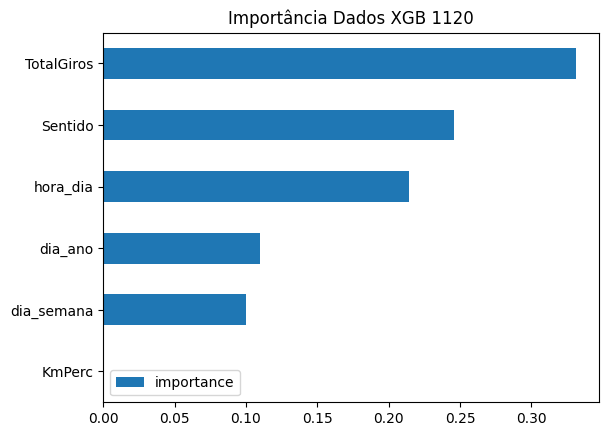

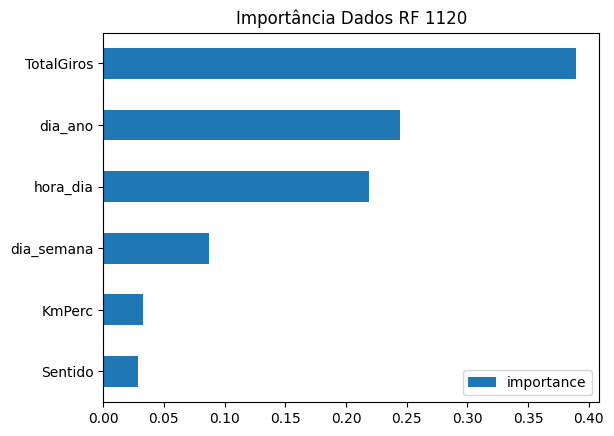

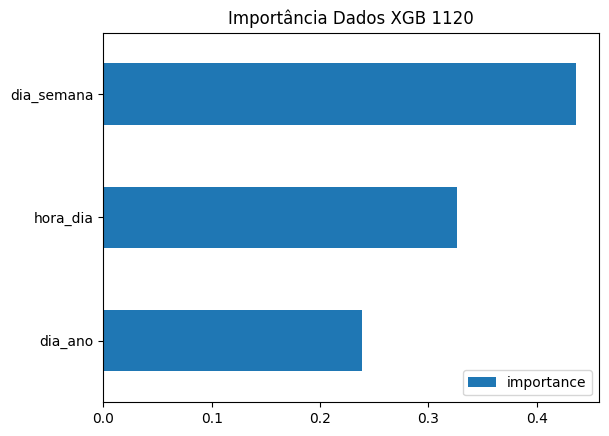

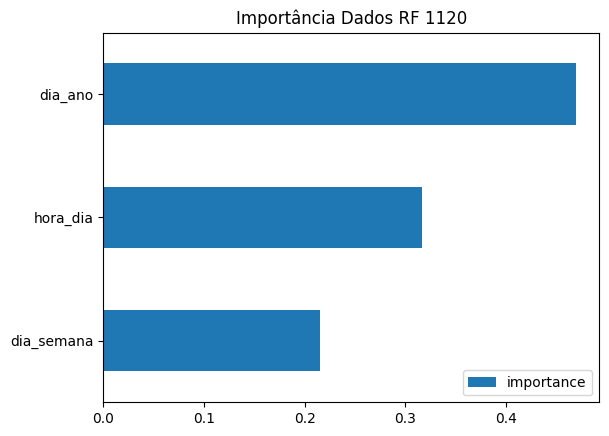

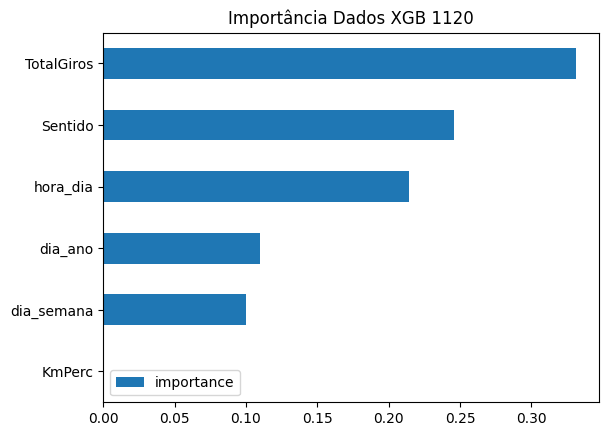

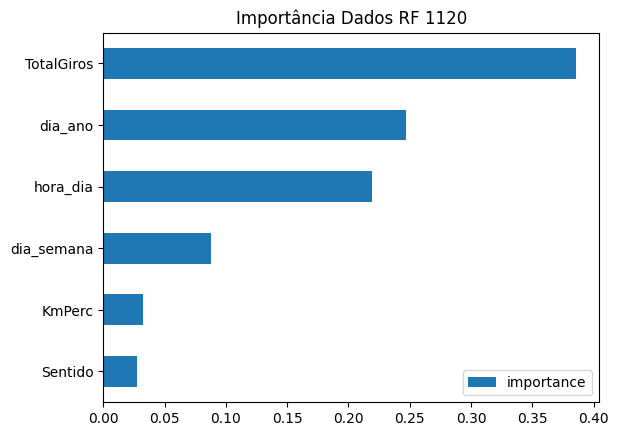

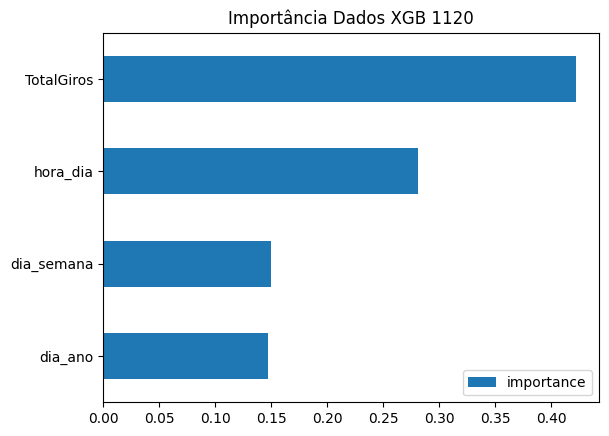

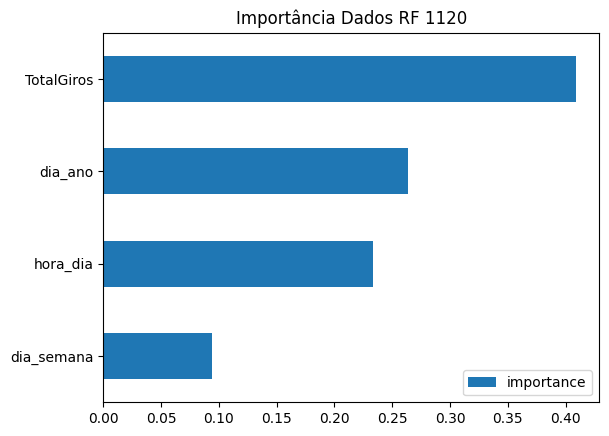

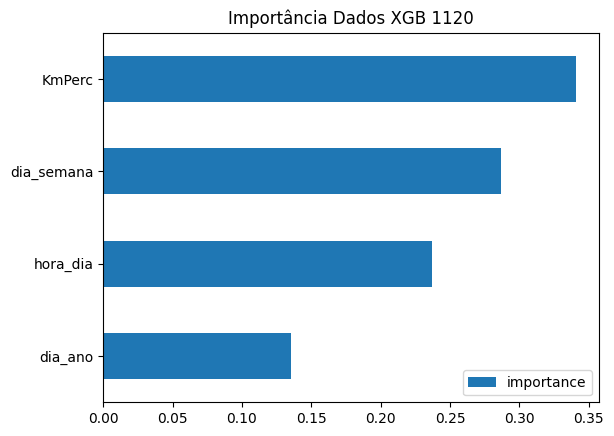

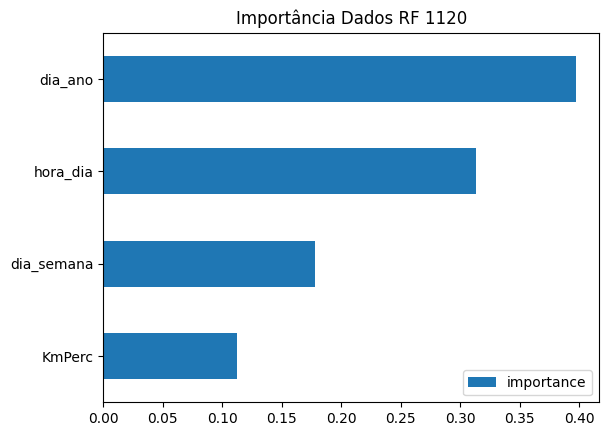

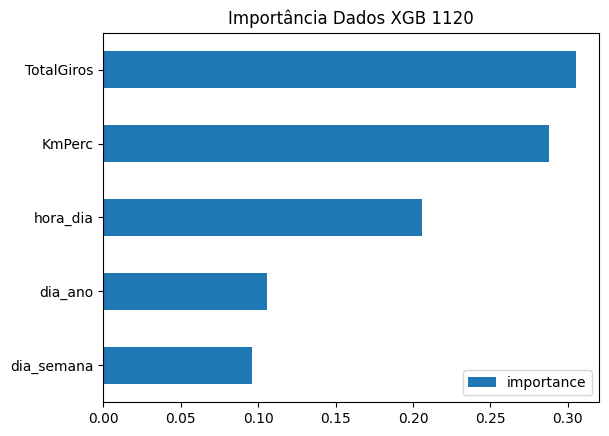

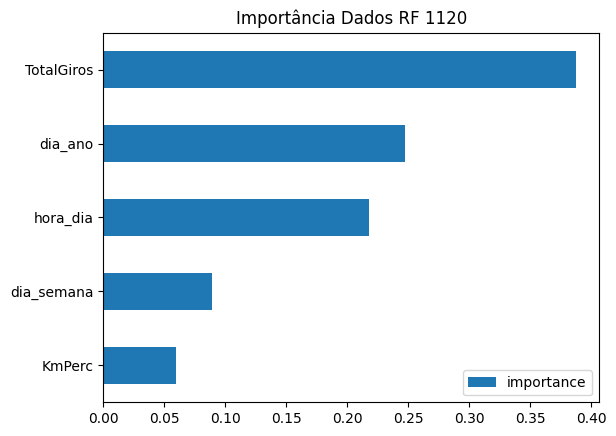

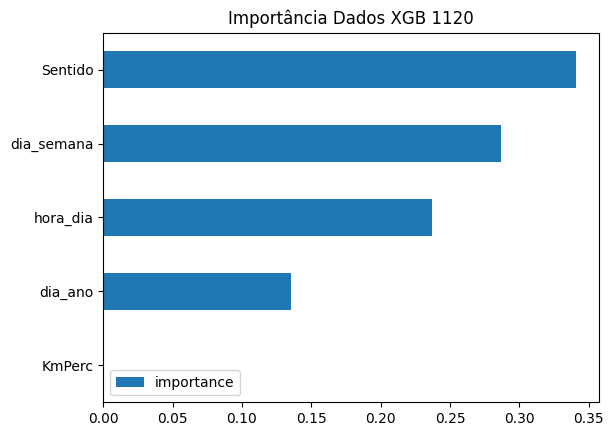

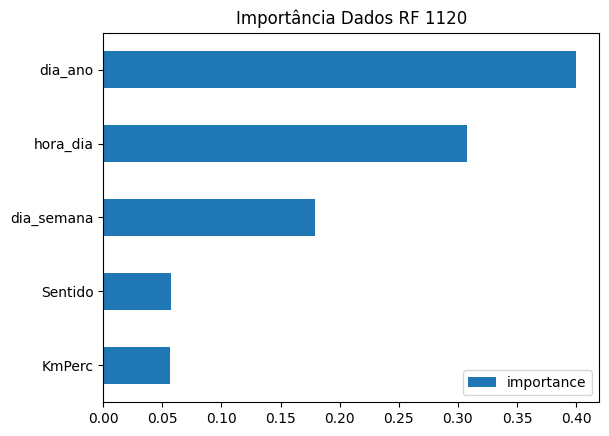

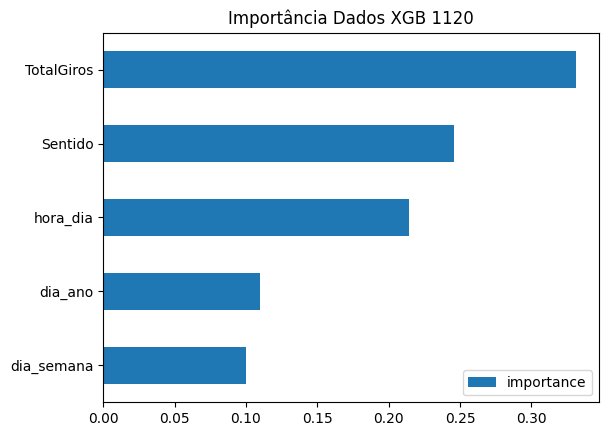

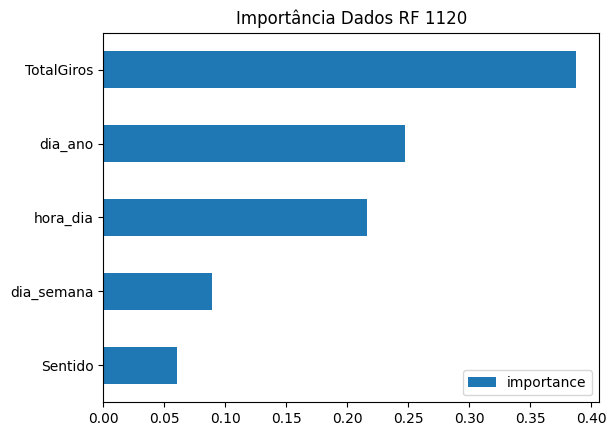

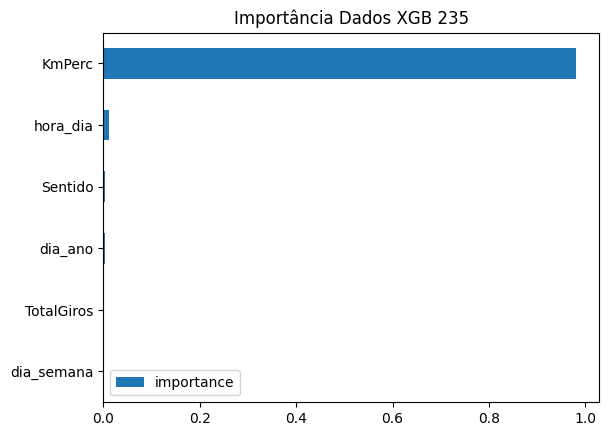

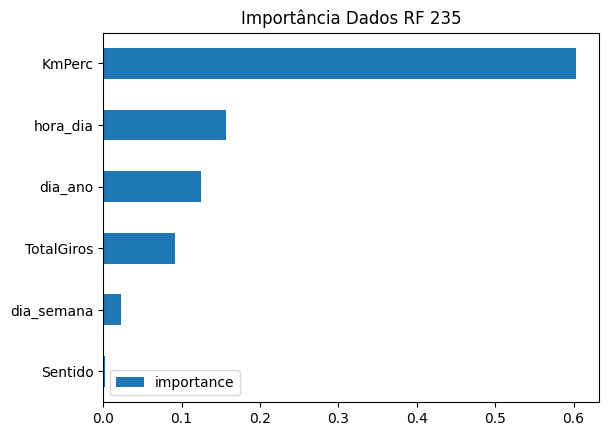

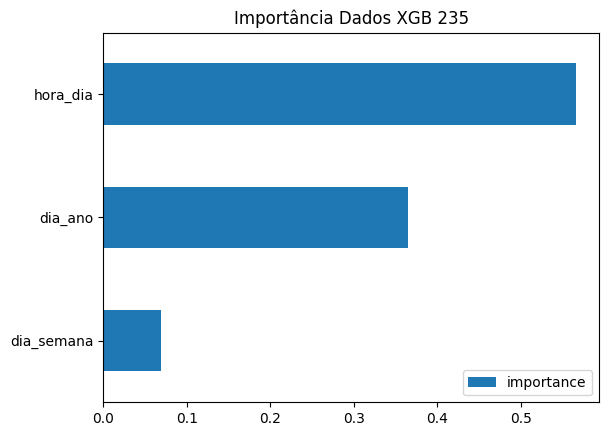

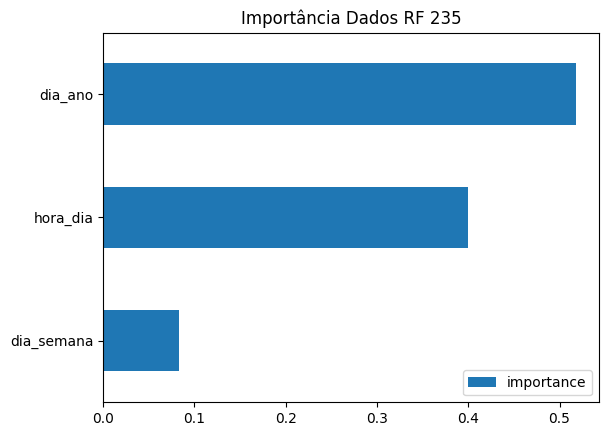

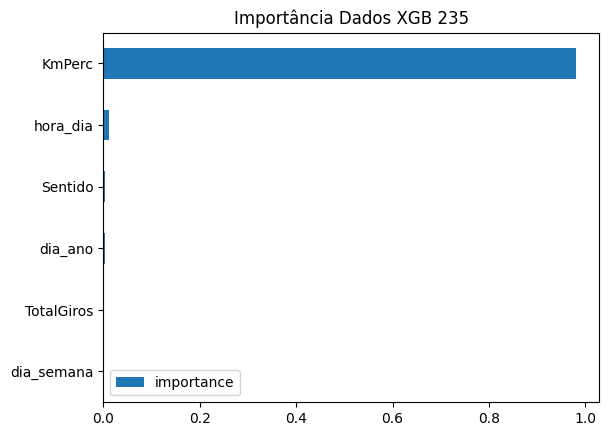

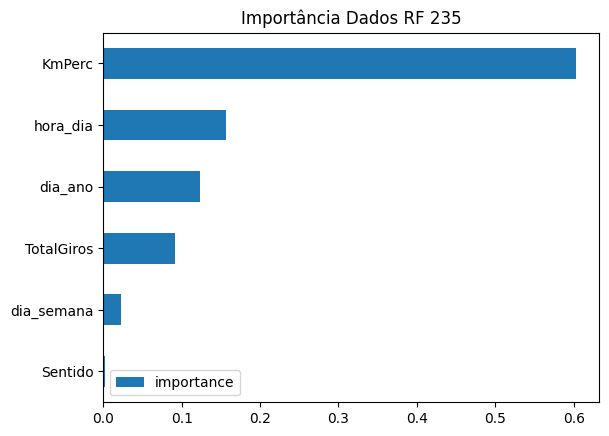

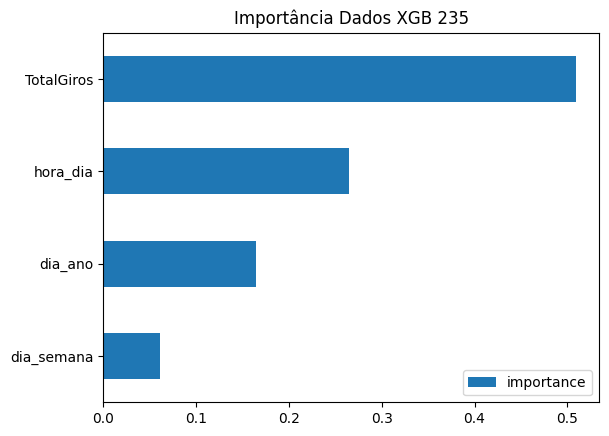

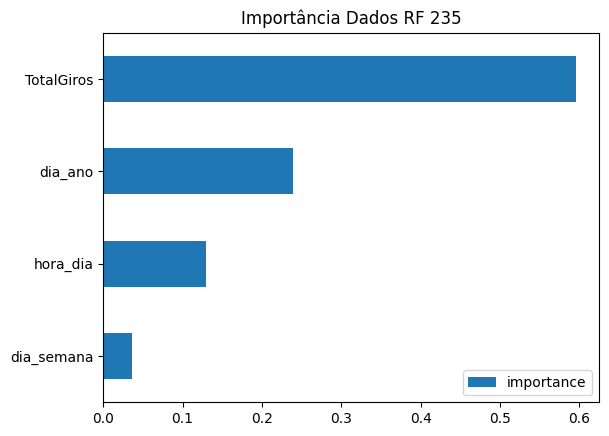

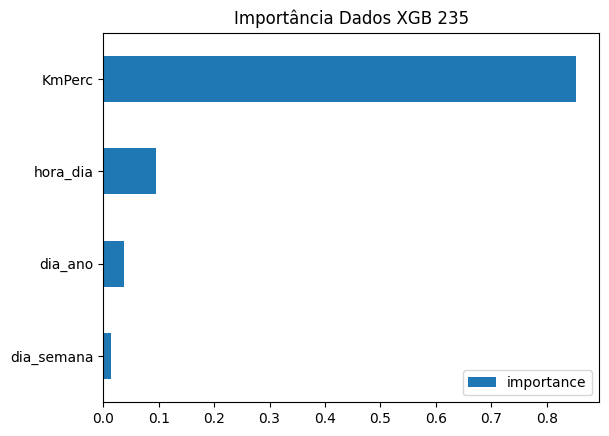

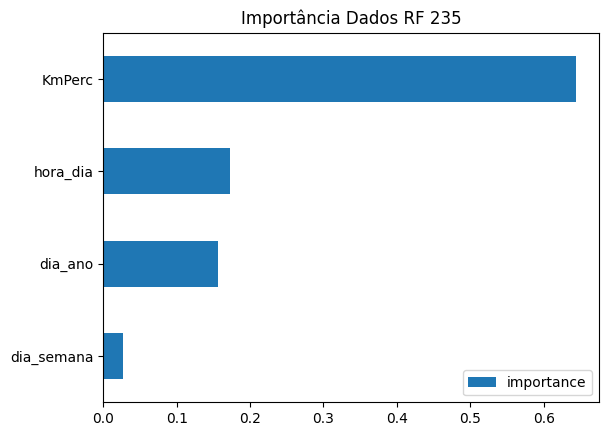

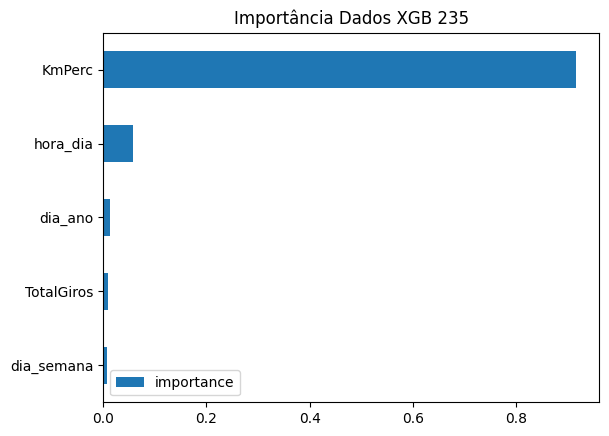

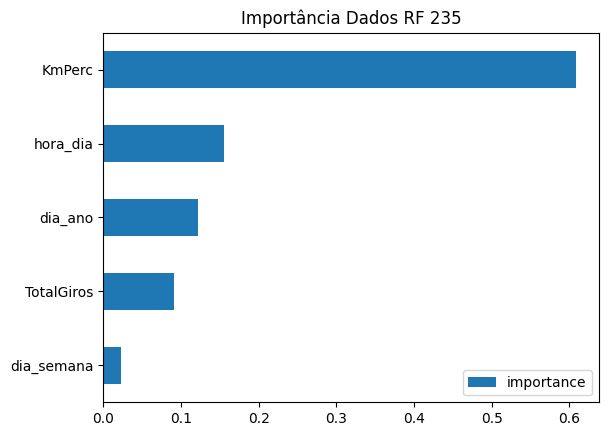

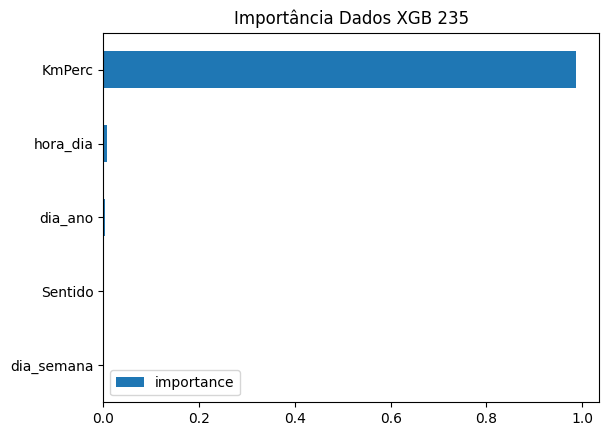

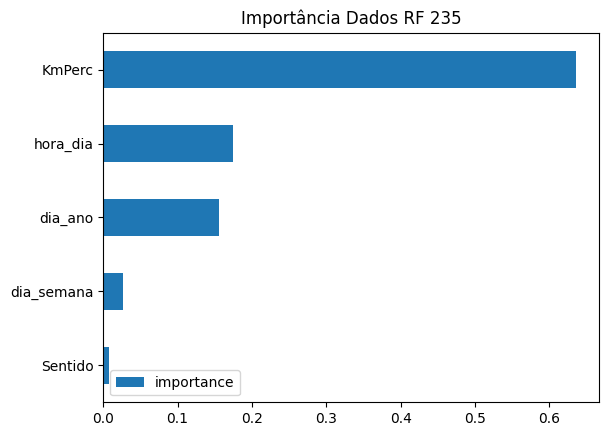

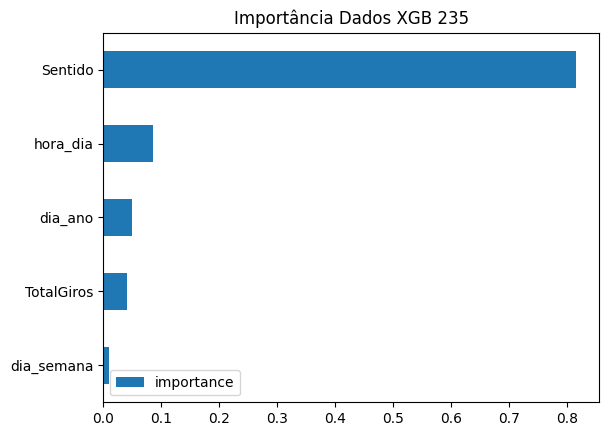

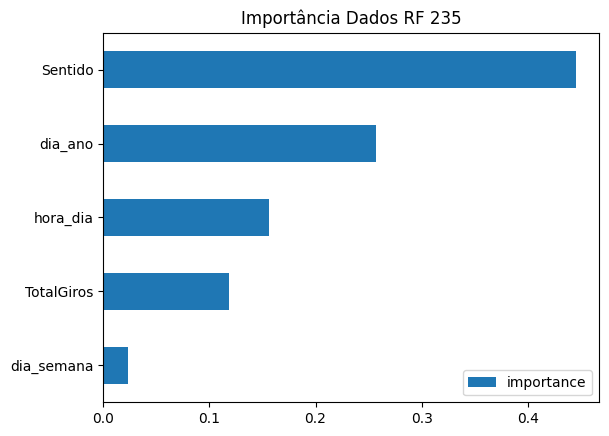

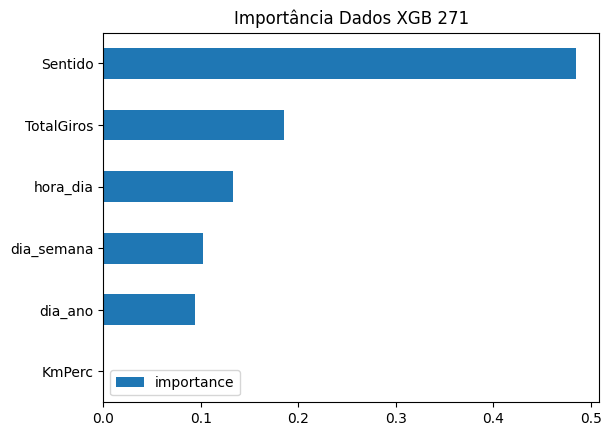

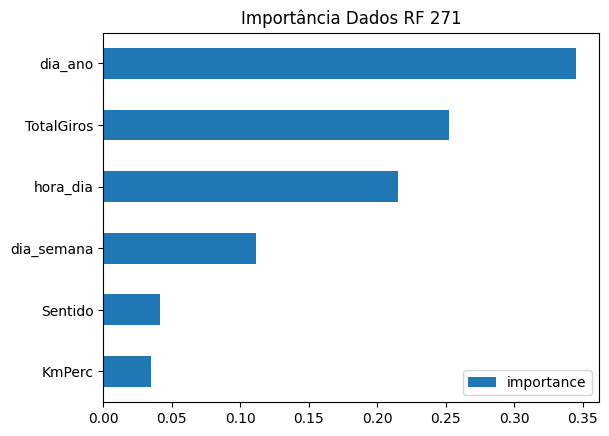

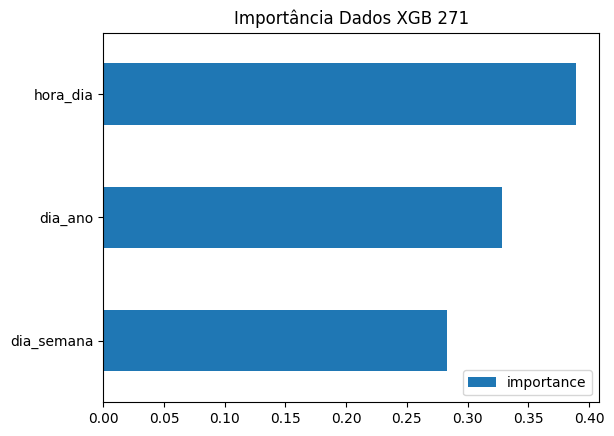

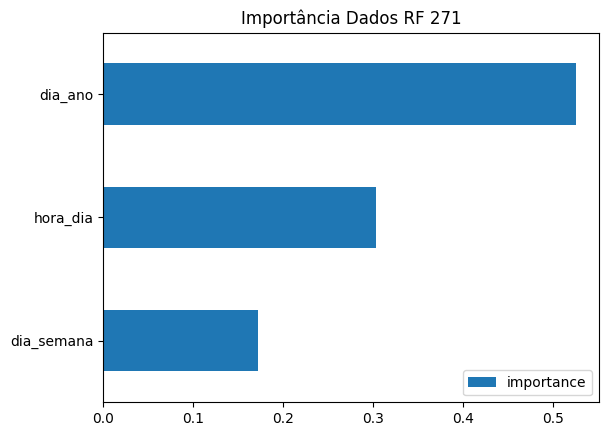

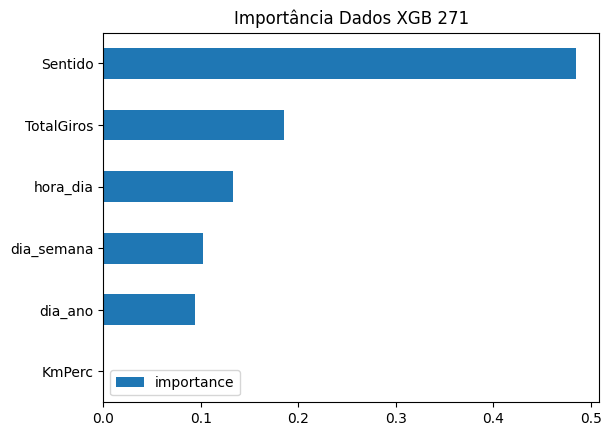

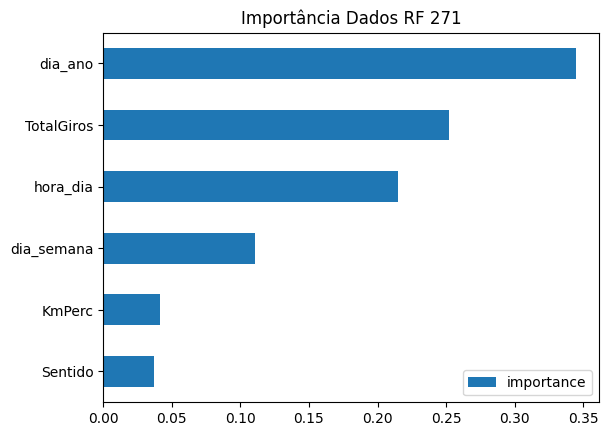

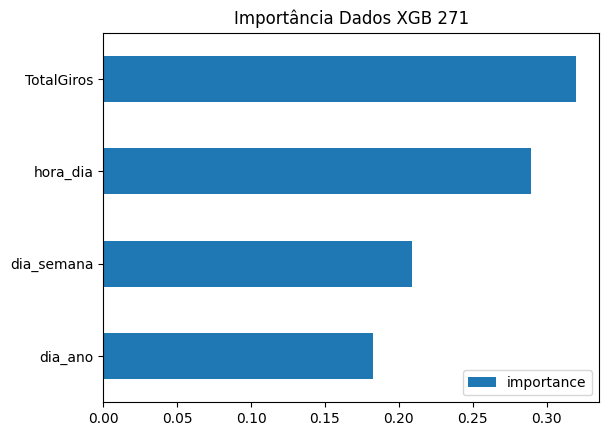

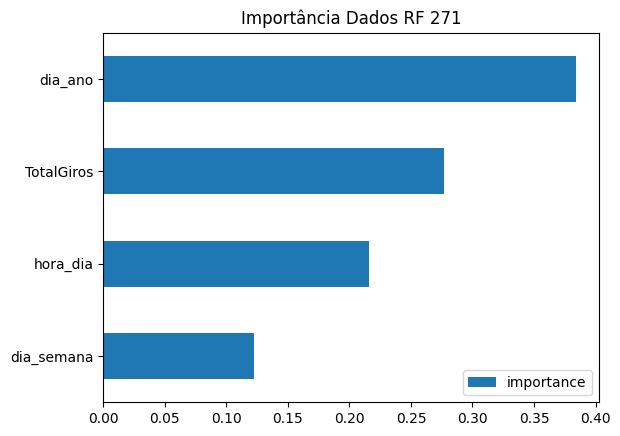

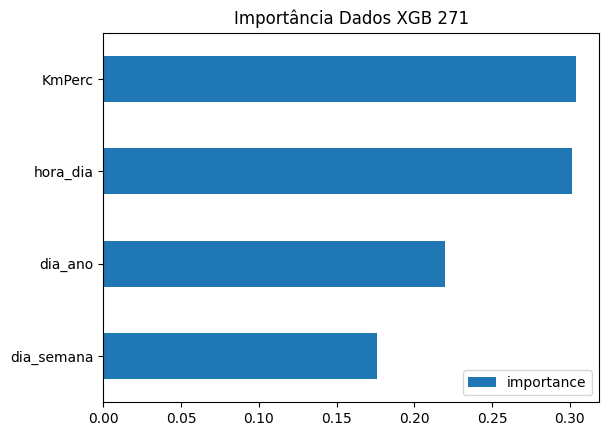

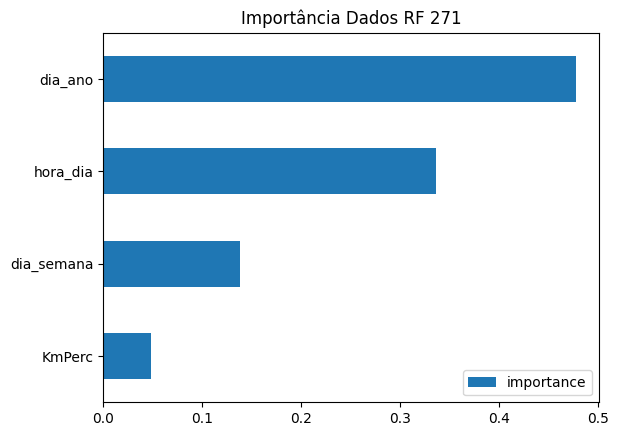

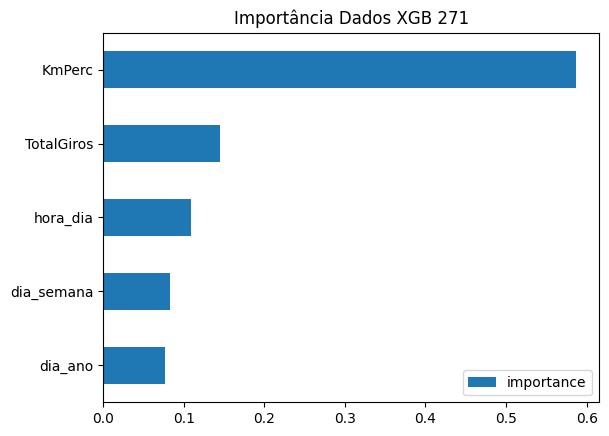

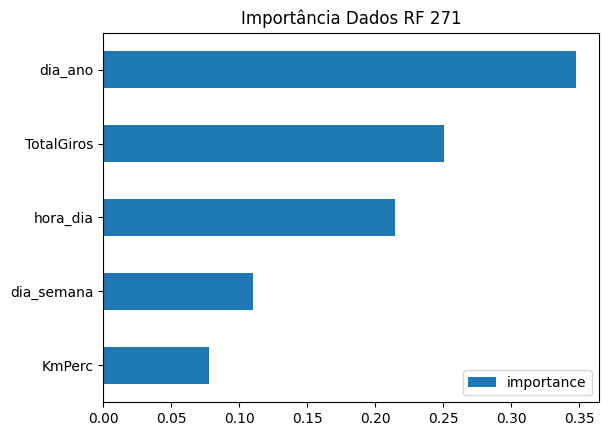

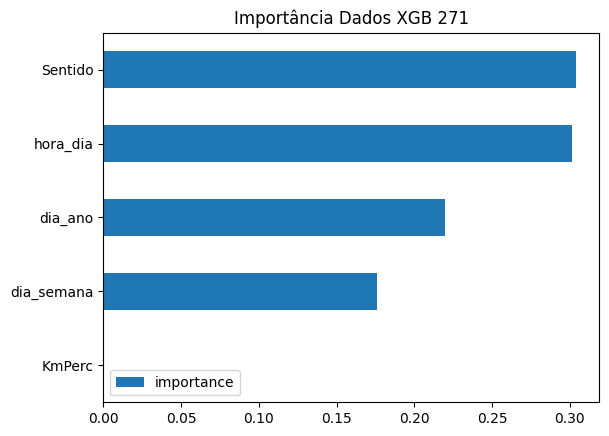

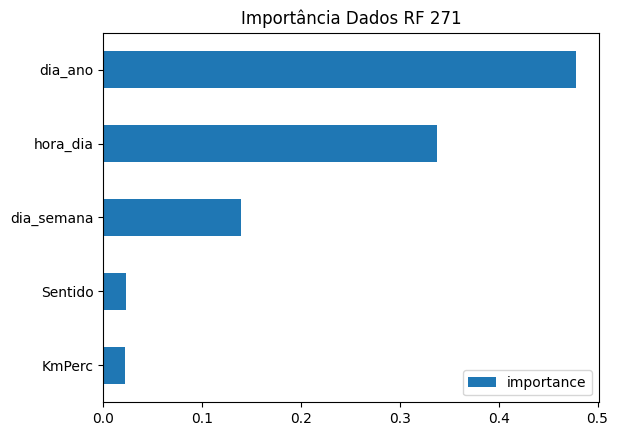

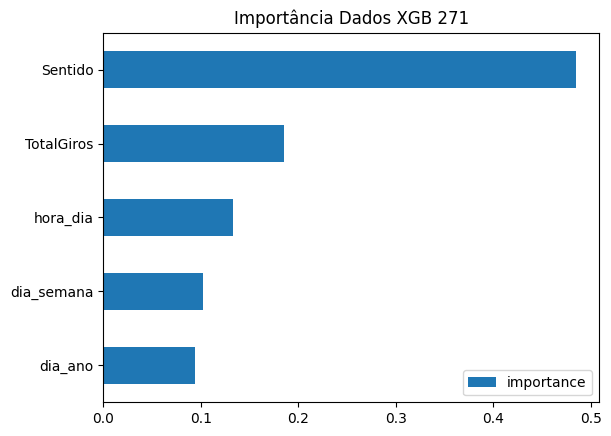

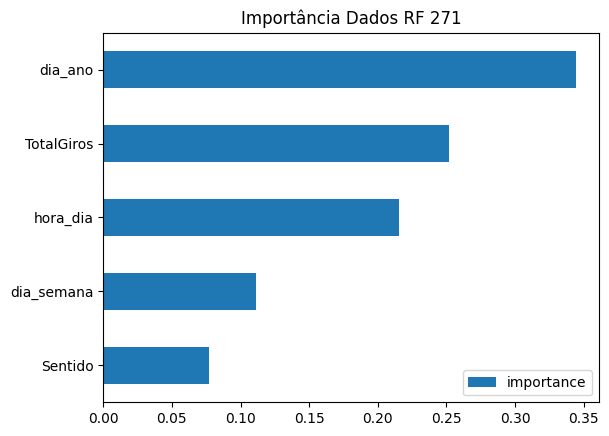

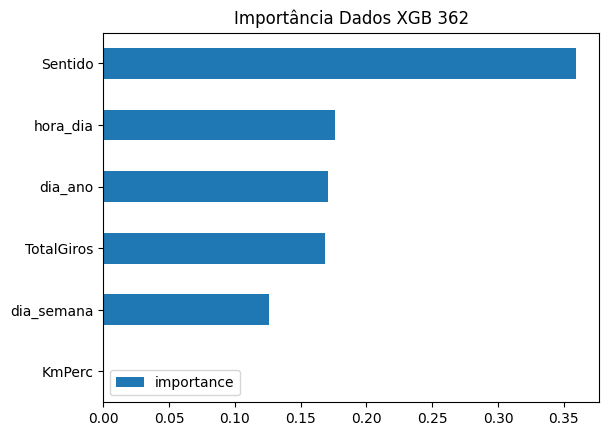

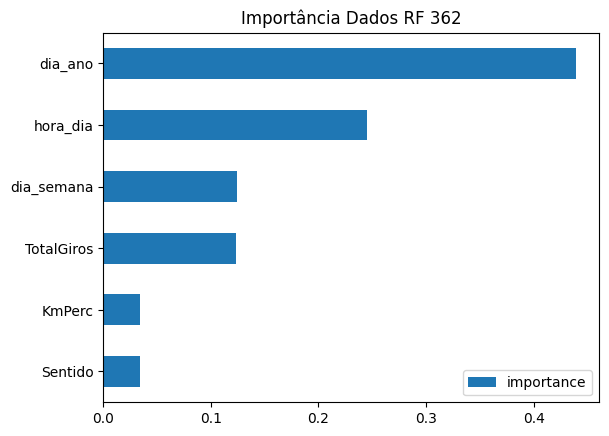

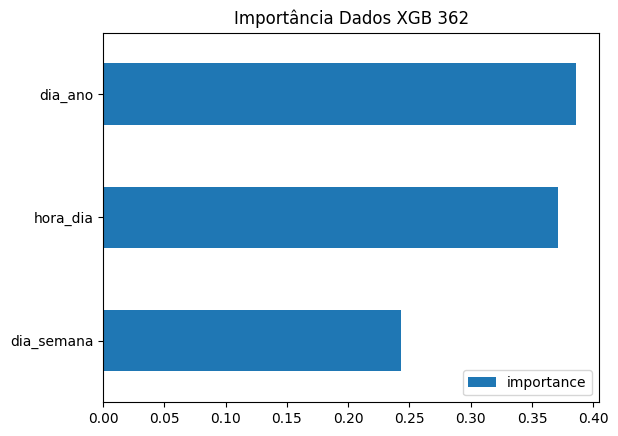

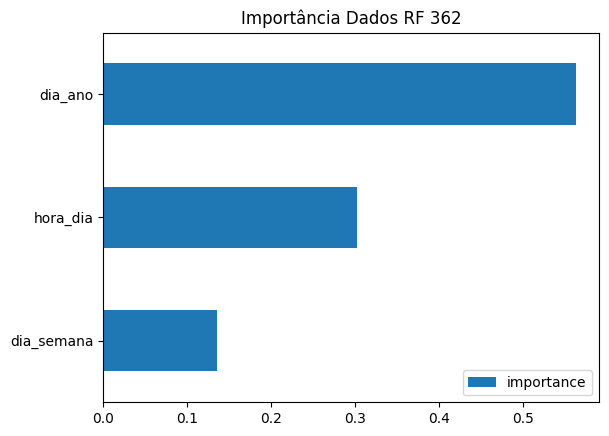

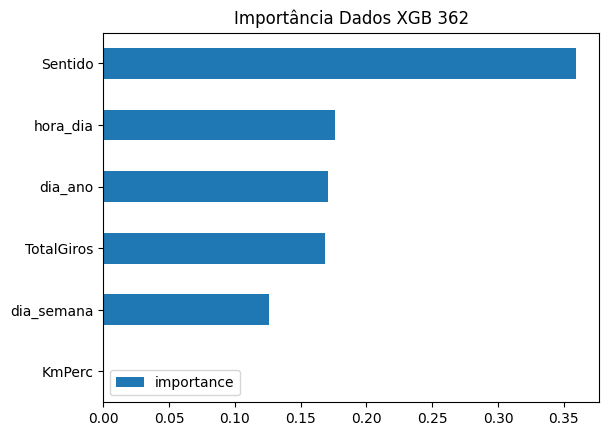

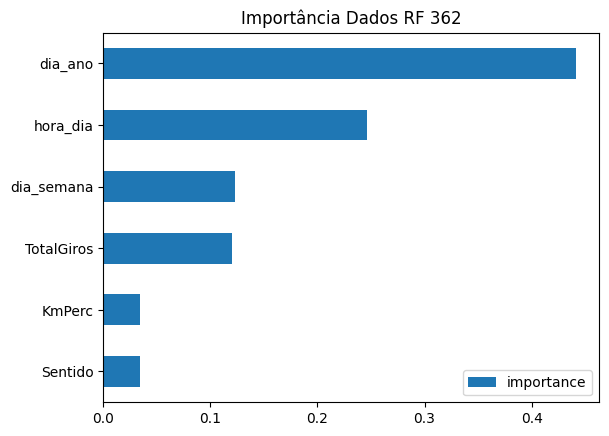

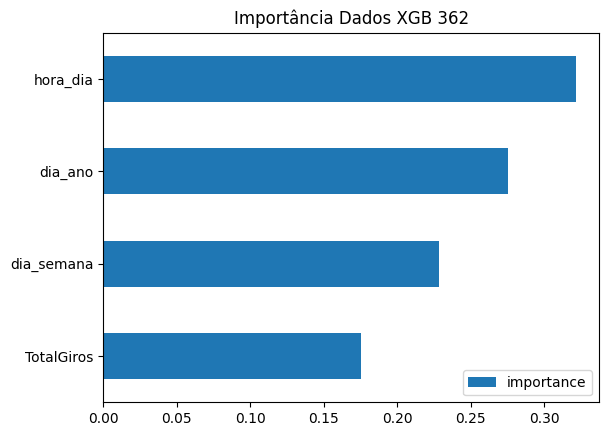

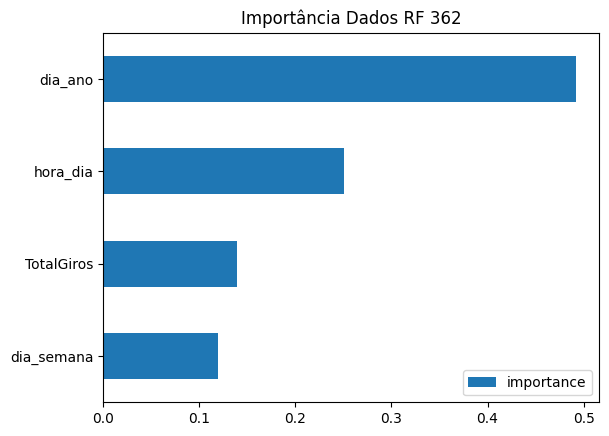

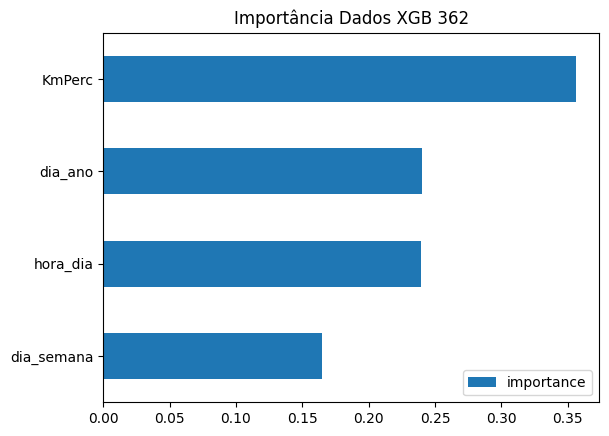

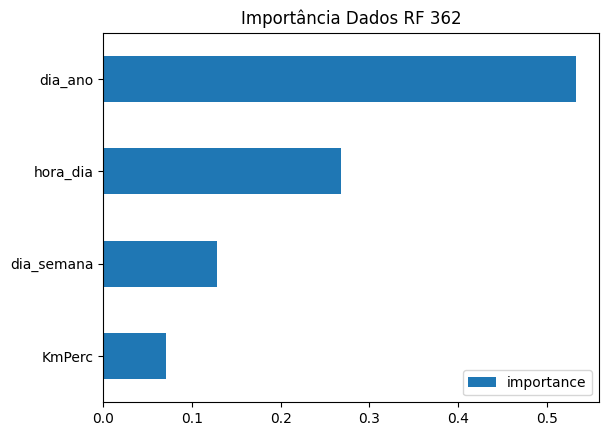

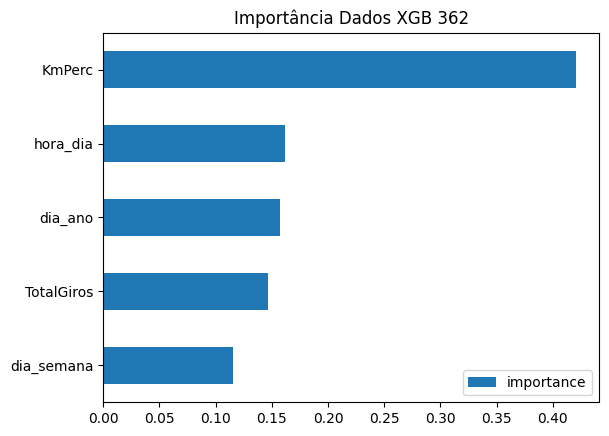

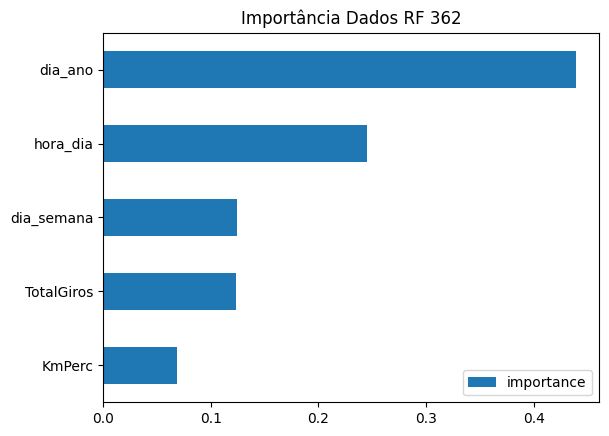

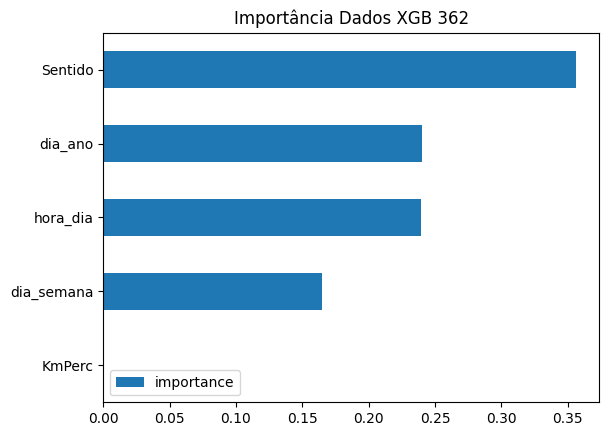

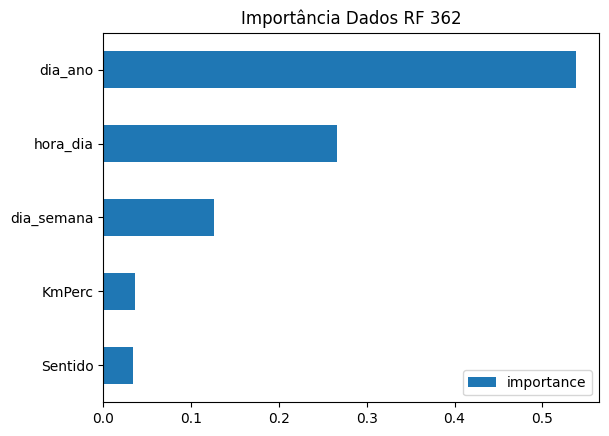

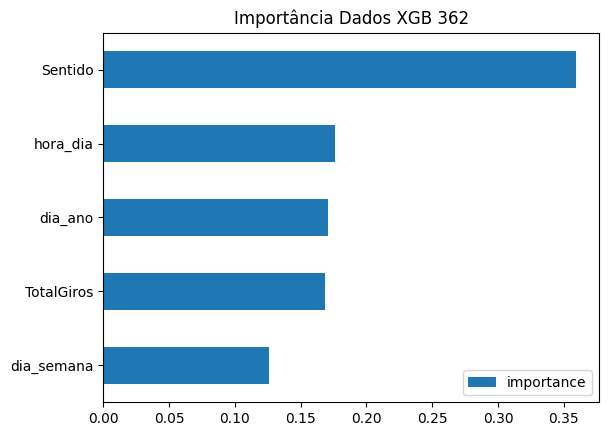

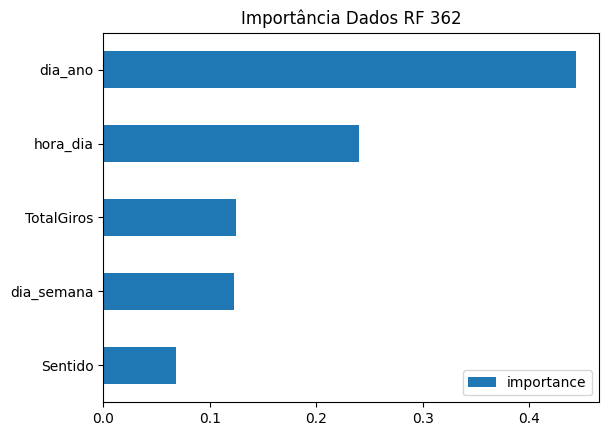

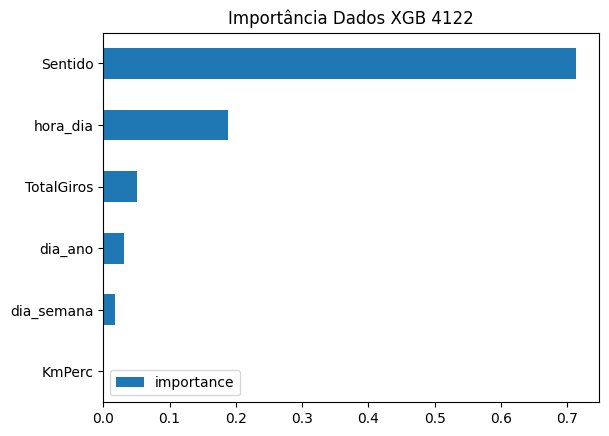

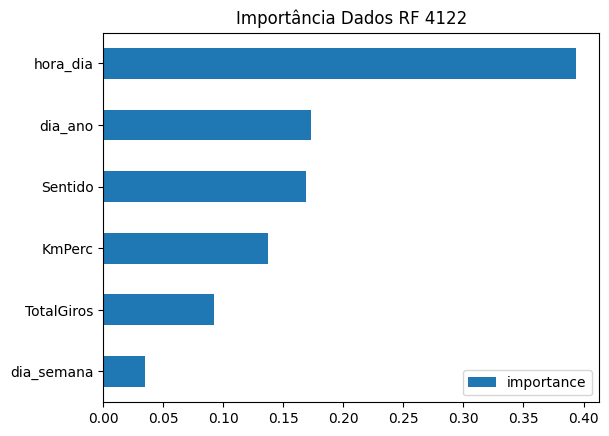

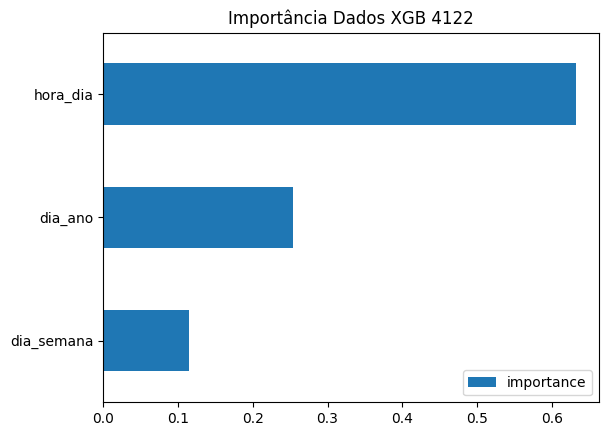

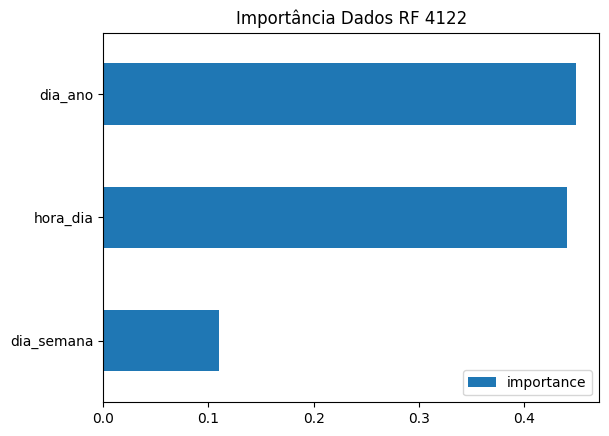

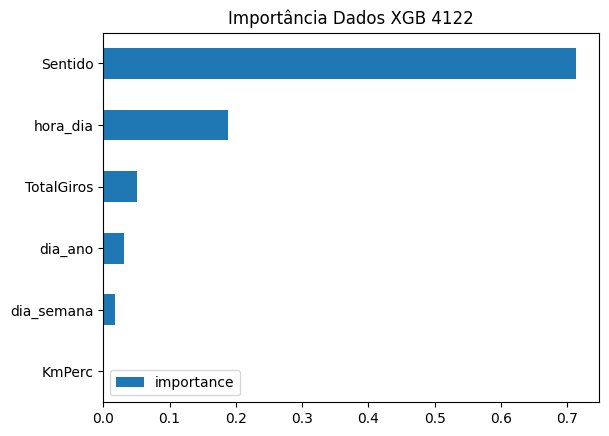

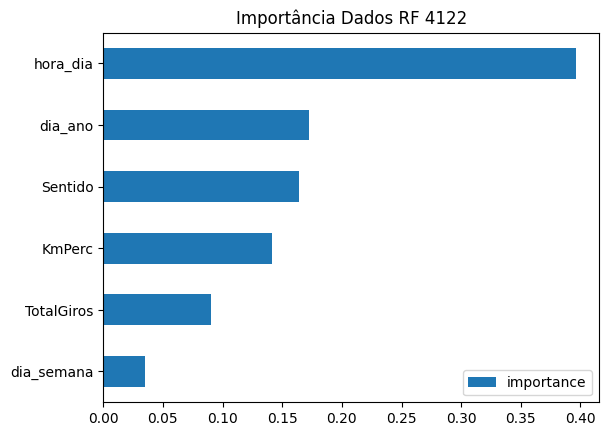

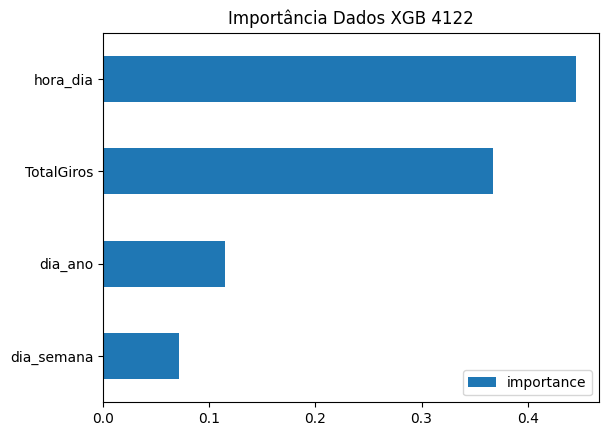

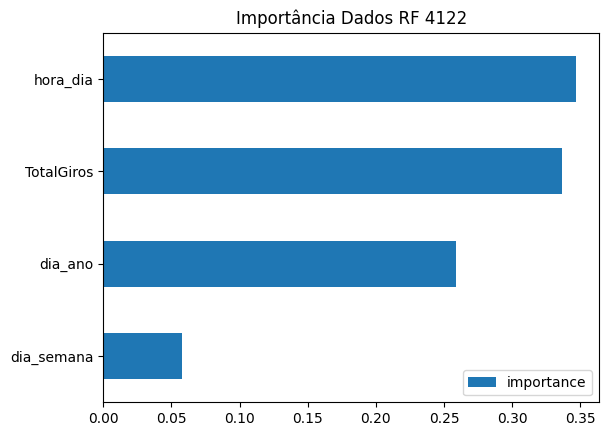

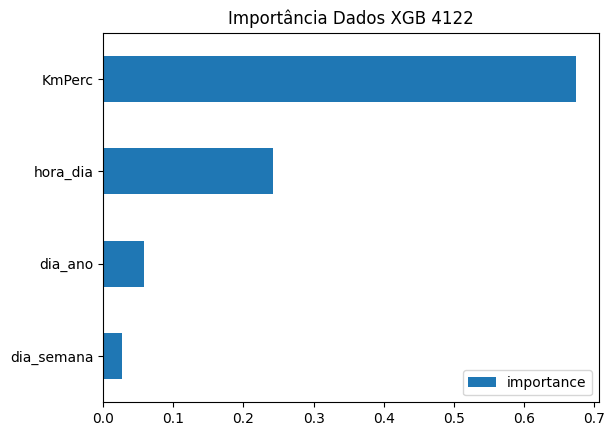

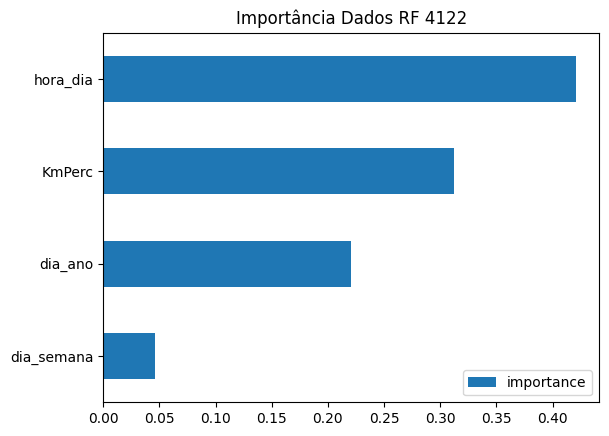

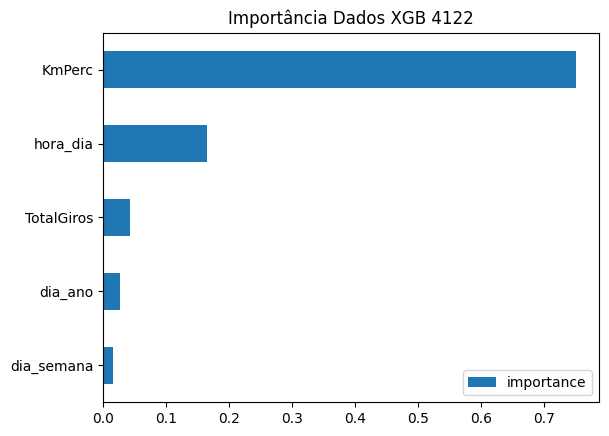

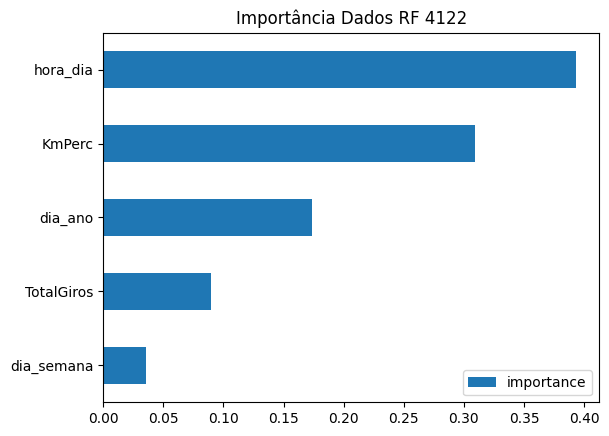

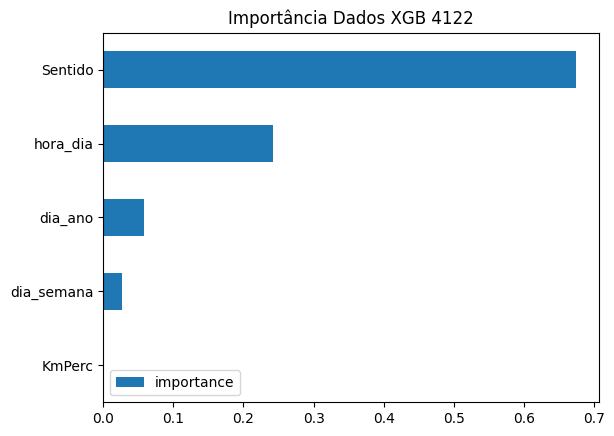

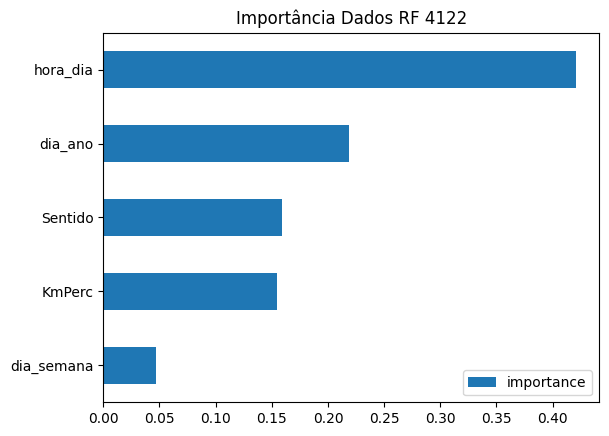

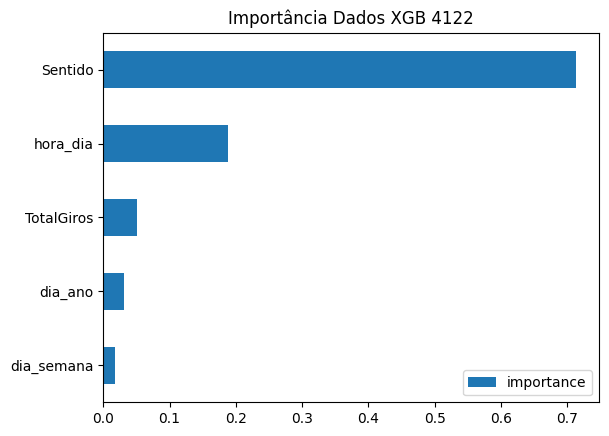

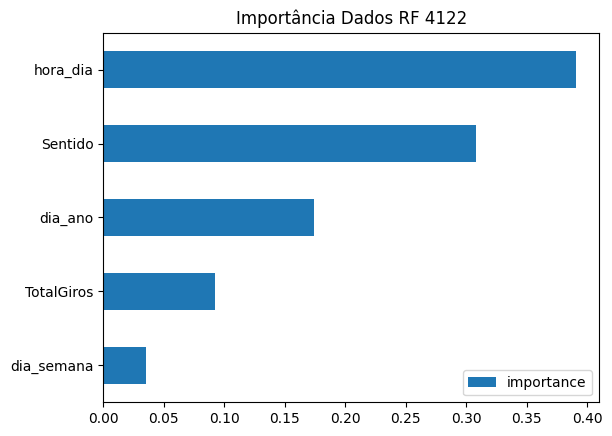

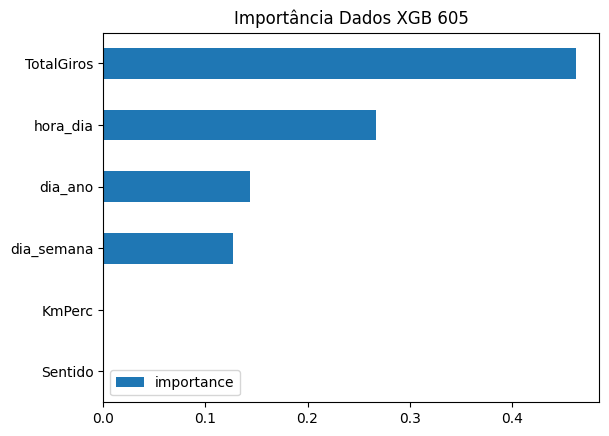

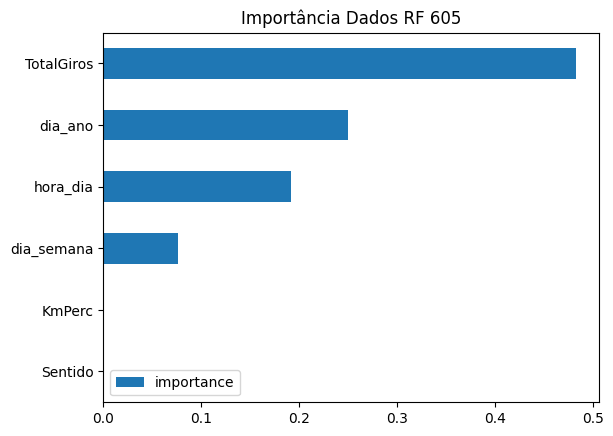

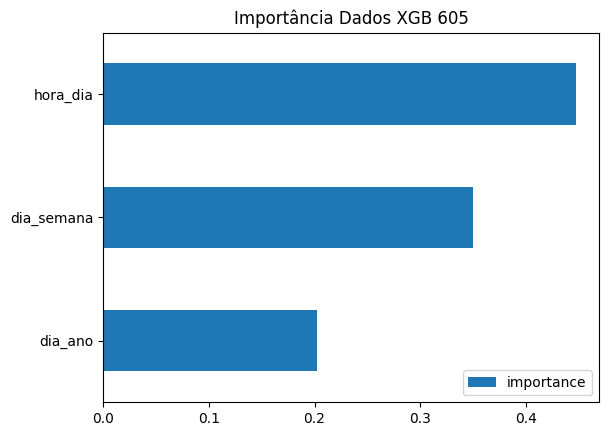

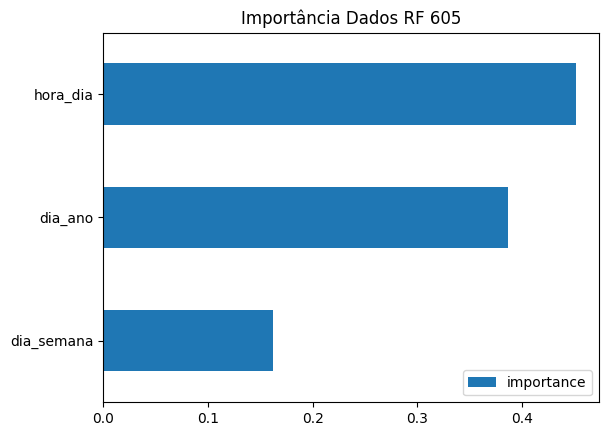

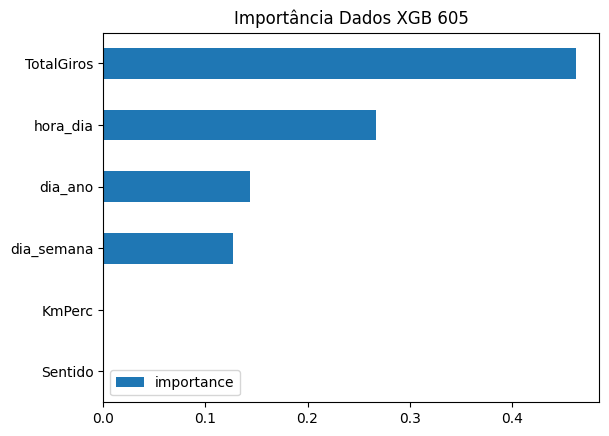

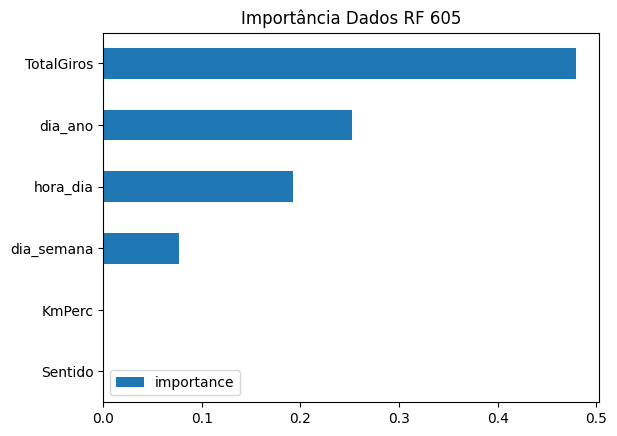

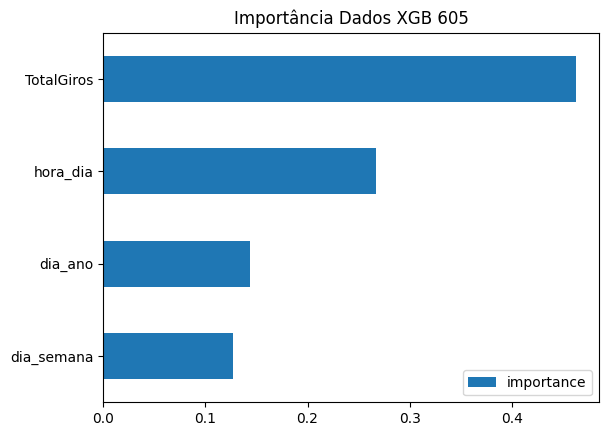

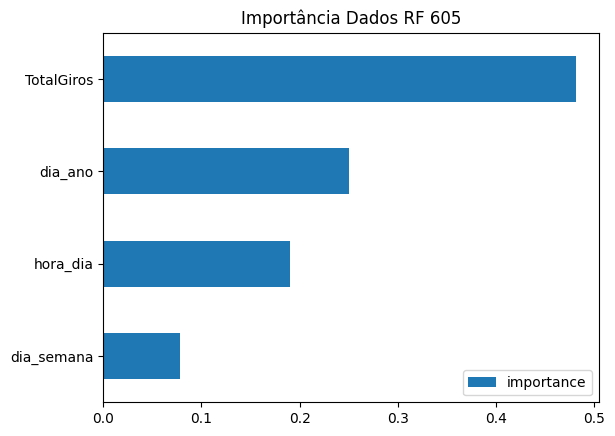

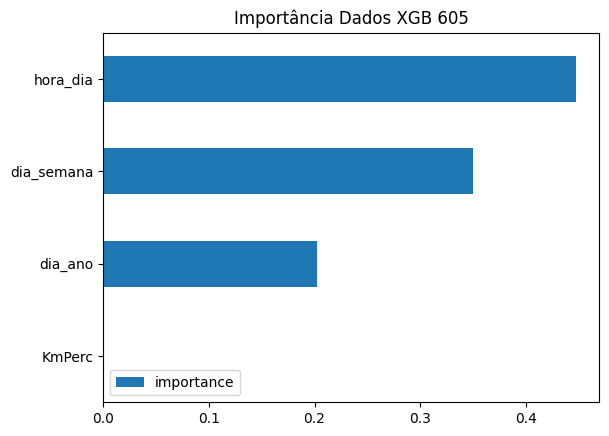

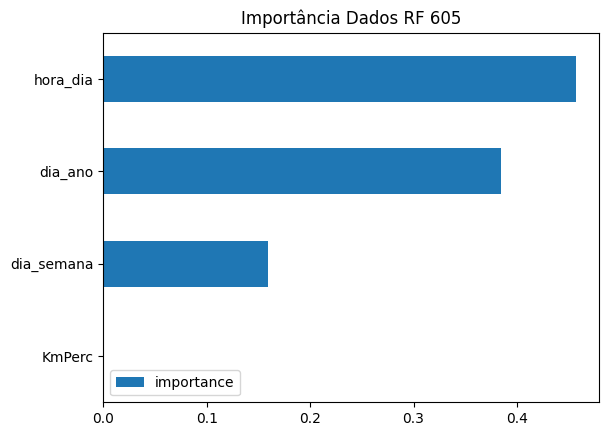

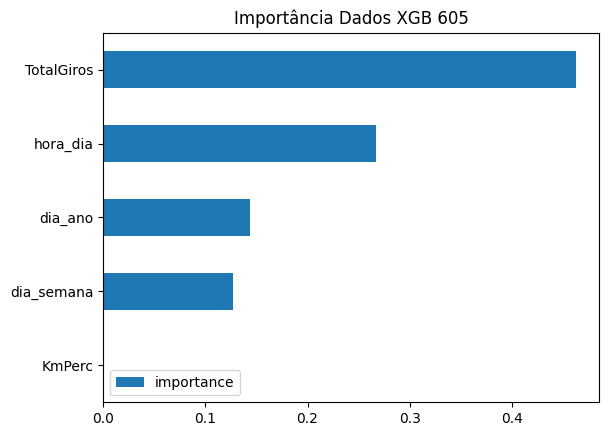

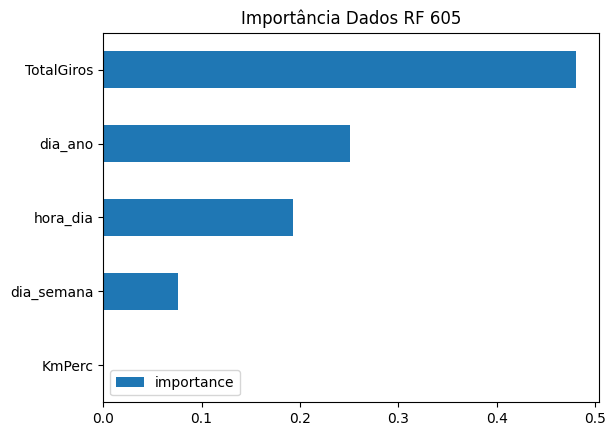

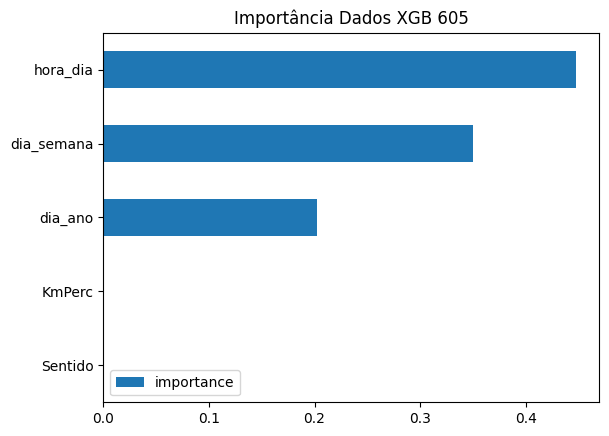

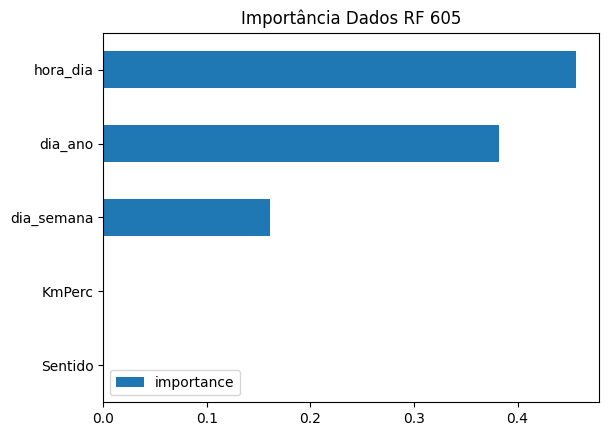

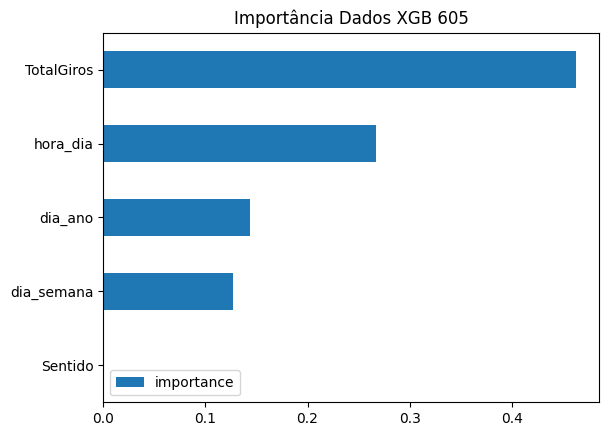

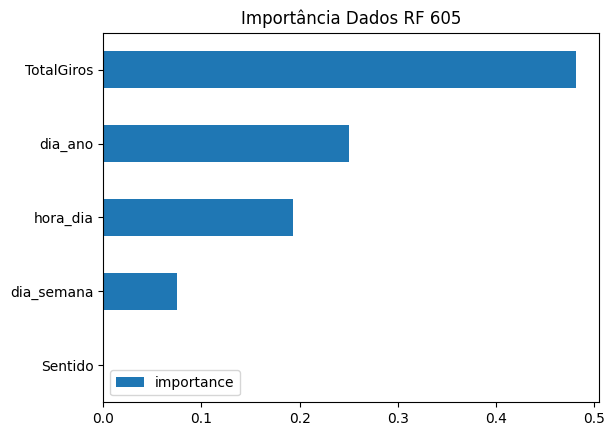

In [41]:
Colunas = [
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano'],
    ['dia_semana','hora_dia','dia_ano'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano'],
    ['TotalGiros','dia_semana','hora_dia','dia_ano'],
    ['KmPerc','dia_semana','hora_dia','dia_ano'],
    ['TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano'],
    ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano'],
    ['Sentido','TotalGiros','dia_semana','hora_dia','dia_ano']
]
TestesNome = [
    "1 Teste de Colunas - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['TotalGiros','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['Sentido','TotalGiros','dia_semana','hora_dia','dia_ano']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

# Teste com clima

## Tratando dados de clima

In [42]:
# Lendo os csv do Inmet e juntando os dois anos
clima2019 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2019_A_31-12-2019.CSV', sep=';', header=8, encoding='utf-8')
clima2018 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2018_A_31-12-2018.CSV', sep=';', header=8, encoding='utf-8')
clima2018.rename(columns = {'DATA (YYYY-MM-DD)': 'Data', 'HORA (UTC)':'Hora UTC'} ,inplace=True)
clima = pd.concat([clima2018,clima2019])
clima

Data  Hora UTC PRECIPITACAO TOTAL, HORARIO (mm)  \
0     2018-01-01     00:00                                0   
1     2018-01-01     01:00                                0   
2     2018-01-01     02:00                                0   
3     2018-01-01     03:00                                0   
4     2018-01-01     04:00                                0   
...          ...       ...                              ...   
8755  2019/12/31  1900 UTC                                0   
8756  2019/12/31  2000 UTC                                0   
8757  2019/12/31  2100 UTC                                0   
8758  2019/12/31  2200 UTC                                0   
8759  2019/12/31  2300 UTC                                0   

     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                                1009,5      
1                                                1010,2      
2                                                1010,7      
3                                                1010,5      
4                                                  1010      
...                                                 ...      
8755                                             1005,8      
8756                                             1005,7      
8757                                             1005,9      
8758                                             1006,4      
8759                                             1007,7      

     PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                             1009,5   
1                                             1010,2   
2                                             1010,7   
3                                             1010,7   
4                                             1010,5   
...                                              ...   
8755                                          1006,4   
8756                                            1006   
8757                                          1005,9   
8758                                          1006,4   
8759                                          1007,7   

     PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB) RADIACAO GLOBAL (KJ/m²)  \
0                                                1009                   -9999   
1                                              1009,5                   -9999   
2                                              1010,2                   -9999   
3                                              1010,5                   -9999   
4                                              1009,9                   -9999   
...                                               ...                     ...   
8755                                           1005,8                  2590,4   
8756                                           1005,6                  1864,7   
8757                                           1005,7                   772,7   
8758                                           1005,9                   164,2   
8759                                           1006,4                     1,4   

     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                            24,7   
1                                            24,7   
2                                            24,4   
3                                            23,9   
4                                            23,8   
...                                           ...   
8755                                         29,3   
8756                                           28   
8757                                         27,2   
8758                                         26,2   
8759                                         26,3   

     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                    19,9   
1                                    19,9   
2                                    20,1   
3                                    20,5   
4 

In [43]:
#Convertendo a data e a hora em um datetime
clima['Datetime'] = pd.to_datetime(clima['Data']+' '+clima['Hora UTC'],utc=True)
clima['Datetime'] = clima['Datetime'].dt.tz_convert(pytz.timezone('America/Sao_Paulo'))
clima['Datetime'] = clima['Datetime'].dt.tz_localize(None)
clima

Data  Hora UTC PRECIPITACAO TOTAL, HORARIO (mm)  \
0     2018-01-01     00:00                                0   
1     2018-01-01     01:00                                0   
2     2018-01-01     02:00                                0   
3     2018-01-01     03:00                                0   
4     2018-01-01     04:00                                0   
...          ...       ...                              ...   
8755  2019/12/31  1900 UTC                                0   
8756  2019/12/31  2000 UTC                                0   
8757  2019/12/31  2100 UTC                                0   
8758  2019/12/31  2200 UTC                                0   
8759  2019/12/31  2300 UTC                                0   

     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                                1009,5      
1                                                1010,2      
2                                                1010,7      
3                                                1010,5      
4                                                  1010      
...                                                 ...      
8755                                             1005,8      
8756                                             1005,7      
8757                                             1005,9      
8758                                             1006,4      
8759                                             1007,7      

     PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                             1009,5   
1                                             1010,2   
2                                             1010,7   
3                                             1010,7   
4                                             1010,5   
...                                              ...   
8755                                          1006,4   
8756                                            1006   
8757                                          1005,9   
8758                                          1006,4   
8759                                          1007,7   

     PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB) RADIACAO GLOBAL (KJ/m²)  \
0                                                1009                   -9999   
1                                              1009,5                   -9999   
2                                              1010,2                   -9999   
3                                              1010,5                   -9999   
4                                              1009,9                   -9999   
...                                               ...                     ...   
8755                                           1005,8                  2590,4   
8756                                           1005,6                  1864,7   
8757                                           1005,7                   772,7   
8758                                           1005,9                   164,2   
8759                                           1006,4                     1,4   

     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                            24,7   
1                                            24,7   
2                                            24,4   
3                                            23,9   
4                                            23,8   
...                                           ...   
8755                                         29,3   
8756                                           28   
8757                                         27,2   
8758                                         26,2   
8759                                         26,3   

     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                    19,9   
1                                    19,9   
2                                    20,1   
3                                    20,5   
4 

In [44]:
#Pegando apenas colunas com informações de data, precipitação e temperatudo. E o intervalo de tempo apenas dos nossos dados
clima = clima[['Datetime','PRECIPITACAO TOTAL, HORARIO (mm)','TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)']]
clima = clima.loc[(clima['Datetime'] >= '2018-10-01') & (clima['Datetime'] <= '2019-11-30')].sort_values(by='Datetime')
clima

Datetime PRECIPITACAO TOTAL, HORARIO (mm)  \
6555 2018-10-01 00:00:00                                0   
6556 2018-10-01 01:00:00                                0   
6557 2018-10-01 02:00:00                                0   
6558 2018-10-01 03:00:00                                0   
6559 2018-10-01 04:00:00                                0   
...                  ...                              ...   
7991 2019-11-29 20:00:00                              NaN   
7992 2019-11-29 21:00:00                              NaN   
7993 2019-11-29 22:00:00                              NaN   
7994 2019-11-29 23:00:00                              NaN   
7995 2019-11-30 00:00:00                              NaN   

     TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)  \
6555                                       23,3   
6556                                       23,3   
6557                                       22,9   
6558                                       22,9   
6559                                       22,7   
...                                         ...   
7991                                       22,8   
7992                                       22,5   
7993                                       21,9   
7994                                       20,8   
7995                                       21,4   

     TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)  
6555                                       23,2  
6556                                       22,6  
6557                                       22,5  
6558                                       22,7  
6559                                       22,4  
...                                         ...  
7991                                       22,4  
7992                                       21,9  
7993                                       20,6  
7994                                       20,6  
7995                                       20,8  

[10201 rows x 4 columns]

In [45]:
# Tirando a média das temperaturas mínima e máxima
clima["Temperatura Media"] = (clima["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float) + clima["TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float))/2

In [46]:
#Transformando a precipitação em um valor categorico - Usamos apenas 3 Sem, Fraco e Forte pois com mais categorias algumas ficavam pouco representativas
clima["PRECIPITACAO TOTAL, HORARIO (mm)"] = clima["PRECIPITACAO TOTAL, HORARIO (mm)"].str.replace(",", ".").astype(float)
clima['Descricao Chuva'] = clima['PRECIPITACAO TOTAL, HORARIO (mm)'].apply(lambda x: 1 if (x > 0) & (x <= 2.5) else \
2 if (x > 2.5) & (x <= 10) else \
3 if (x > 10) else 0)

In [47]:
#Transformando a Temperatura em um valor categorico - Usamos apenas 2 Frio ou Quente pois com mais categorias algumas ficavam pouco representativas
clima['Calor'] = clima['Temperatura Media'].apply(lambda x: 1 if (x > 16) & (x <= 25) else \
2 if (x > 25) else 0)

In [48]:
#Dropando as colunas desnecessárias
clima.drop(["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)"], axis=1, inplace=True)
clima.rename({"PRECIPITACAO TOTAL, HORARIO (mm)": "Precipitacao", "Temperatura Media": "Temperatura", "Descricao Chuva": "Chuva"}, axis=1, inplace=True)

In [49]:
clima

Datetime  Precipitacao  Temperatura  Chuva  Calor
6555 2018-10-01 00:00:00           0.0        23.25      0      1
6556 2018-10-01 01:00:00           0.0        22.95      0      1
6557 2018-10-01 02:00:00           0.0        22.70      0      1
6558 2018-10-01 03:00:00           0.0        22.80      0      1
6559 2018-10-01 04:00:00           0.0        22.55      0      1
...                  ...           ...          ...    ...    ...
7991 2019-11-29 20:00:00           NaN        22.60      0      1
7992 2019-11-29 21:00:00           NaN        22.20      0      1
7993 2019-11-29 22:00:00           NaN        21.25      0      1
7994 2019-11-29 23:00:00           NaN        20.70      0      1
7995 2019-11-30 00:00:00           NaN        21.10      0      1

[10201 rows x 5 columns]

In [ ]:
#Mudanças na data_partida para conseguir fazer o merge
df["Ini2"] = df["Ini"]
df["Ini2"] = df["Ini2"].dt.round("H")
#Merge dos dados e exclusão da coluna auxiliar
df = df.merge(clima, left_on="Ini2", right_on="Datetime", how="left")
df.drop(['Ini2','Datetime'],axis=1,inplace=True)
df.dropna(subset=['Precipitacao','Temperatura'] ,inplace=True)
df

## Executando Testes

In [ ]:
df

In [ ]:
Colunas = [
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Precipitacao','Temperatura'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Precipitacao'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Temperatura'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Calor'],
]
TestesNome = [
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Precipitacao','Temperatura']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Precipitacao']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Temperatura']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Calor']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)


In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RRSE'].sort_values(by='Valor')

In [ ]:
a.to_excel('asdf.xlsx')

# Testes tempos anteriores

In [ ]:
df["DuraçãoViagem_1"] = df["DuraçãoViagem"]
df["DuraçãoViagem_2"] = df["DuraçãoViagem"]
df["DuraçãoViagem_3"] = df["DuraçãoViagem"]
df["DuraçãoViagem_4"] = df["DuraçãoViagem"]
df["DuraçãoViagem_5"] = df["DuraçãoViagem"]

df['DuraçãoViagem_1'] = df.groupby('Linha')['DuraçãoViagem'].shift(1)
df['DuraçãoViagem_2'] = df.groupby('Linha')['DuraçãoViagem'].shift(2)
df['DuraçãoViagem_3'] = df.groupby('Linha')['DuraçãoViagem'].shift(3)
df['DuraçãoViagem_4'] = df.groupby('Linha')['DuraçãoViagem'].shift(4)
df['DuraçãoViagem_5'] = df.groupby('Linha')['DuraçãoViagem'].shift(5)

df.dropna(subset=['DuraçãoViagem_5'] ,inplace=True)

df

In [ ]:
Colunas = [
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1"],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1","DuraçãoViagem_2"],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3"],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4"],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4","DuraçãoViagem_5"]
]
TestesNome = [
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1]",
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1','DuraçãoViagem_2']",
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3']",
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4']",
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4','DuraçãoViagem_5']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RRSE'].sort_values(by='Valor')

In [ ]:
a.to_excel('asdfg.xlsx')

# Teste com intervalor de treino diferentes

In [ ]:
Intervalos = ['2019-01-01','2019-03-01','2019-05-01','2019-07-01','2019-09-01']

TestesNome = [
    "4 Teste de Intervalos - Janeiro",
    "4 Teste de Intervalos - Março",
    "4 Teste de Intervalos - Maio",
    "4 Teste de Intervalos - Julho",
    "4 Teste de Intervalos - Setembro"
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    for i in range(len(Intervalos)):
        df_teste = df_modelo.loc[df_modelo['Ini'] > Intervalos[i]]
        df_treino = df_modelo.loc[df_modelo['Ini'] <= Intervalos[i]]
        teste_nome = TestesNome[i]

        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1"]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1"]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RRSE'].sort_values(by='Valor')

In [ ]:
a.to_excel('cdsfg.xlsx')

In [ ]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Treino do Modelo XGB
modelo_xgb = xgb.XGBRegressor()
modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

#Treino do Modelo RF
modelo_rf = RandomForestRegressor()
modelo_rf.fit(x_treino, y_treino)

#Treino do Modelo LR
modelo_lr = LinearRegression()
modelo_lr.fit(x_treino, y_treino)

#Predição do XGB e salvamento do tempo
prev_xgb = modelo_xgb.predict(x_teste)

#Predição do RF e salvamento do tempo
prev_rf = modelo_rf.predict(x_teste)

#Predição do LR e salvamento do tempo
prev_lr = modelo_lr.predict(x_teste)
